<a href="https://colab.research.google.com/github/YangchenHuang/Algorithmic_Trading/blob/master/ES_v3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install bayesian-optimization

  Created wheel for bayesian-optimization: filename=bayesian_optimization-1.0.1-cp36-none-any.whl size=10032 sha256=cbcd4b264504dd0630c28168c174865fdb9e06fe8933e51a04b56c72e2eab161
  Stored in directory: /root/.cache/pip/wheels/1d/0d/3b/6b9d4477a34b3905f246ff4e7acf6aafd4cc9b77d473629b77
Successfully built bayesian-optimization


In [0]:
import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt
import seaborn as sns
import random
from bayes_opt import BayesianOptimization

In [81]:
!rm -rf Algorithmic_Trading
!git clone https://github.com/YangchenHuang/Algorithmic_Trading

Cloning into 'Algorithmic_Trading'...
remote: Enumerating objects: 90, done.
remote: Counting objects: 100% (90/90), done.
remote: Compressing objects: 100% (87/87), done.
remote: Total 90 (delta 32), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (90/90), done.


In [84]:
df = pd.read_csv('./Algorithmic_Trading/dataset/PEIX.csv')
df.head()

PERMNO      date      VOL          PRC      OPENPRC
0   86165  1/3/2007  1317136  1574.968501  1608.567829
1   86165  1/4/2007  2134999  1513.019740  1574.968501
2   86165  1/5/2007  1123941  1493.070139  1538.219236
3   86165  1/8/2007  1440659  1527.719446  1509.869803
4   86165  1/9/2007  1002601  1522.469551  1515.119698

In [0]:
data = df[['PRC', 'VOL', 'OPENPRC']].to_numpy().flatten()
data = data.tolist()
close = df['PRC'].tolist()
window_size = 30
skip = 5
l = len(close) - 1
test_size=l//2
dev_size=0

In [0]:
def get_state(data, t, n):
    d = t - n + 1
    block = data[d*3 : (t + 1)*3] if d >= 0 else -d * [data[0], data[1], data[2]] + data[0 : (t + 1)*3]
    res = []
    for i in range(n - 1):
        for j in range(3):
            if block[i*3+j]==0:
                res.append(0)
            else:
                res.append((block[(i + 1)*3+j] - block[i*3+j])/block[i*3+j])
    return np.array([res])

In [0]:
class Deep_Evolution_Strategy:

    inputs = None

    def __init__(
        self, weights, reward_function, population_size, sigma, learning_rate, validate, buy, model
    ):
        self.weights = weights
        self.reward_function = reward_function
        self.population_size = population_size
        self.sigma = sigma
        self.learning_rate = learning_rate
        self.fsigma = sigma
        self.validate = validate
        self.buy = buy
        self.model=model

    def _get_weight_from_population(self, weights, population):
        weights_population = []
        for index, i in enumerate(population):
            jittered = self.sigma * i
            weights_population.append(weights[index] + jittered)
        return weights_population

    def get_weights(self):
        return self.weights

    def train(self, epoch = 100, print_every = 1):
        lasttime = time.time()
        reward_list=[]
        max_validate=0
        best_model=self.model
        for i in range(epoch):
            population = []
            rewards = np.zeros(self.population_size)
            for k in range(self.population_size):
                x = []
                for w in self.weights:
                    x.append(np.random.randn(*w.shape))
                population.append(x)
            for k in range(self.population_size):
                weights_population = self._get_weight_from_population(
                    self.weights, population[k]
                )
                rewards[k] = self.reward_function(weights_population)
            rewards = (rewards - np.mean(rewards)) / np.std(rewards)
            # for k in range(self.population_size):
            #     if rewards[k]>0:
            #         self.siglist[k] = np.clip(self.sigma*(rmax-rewards[k])/rran, 0.00001*self.sigma, self.sigma)
            #     if rewards[k]<=0:
            #         self.siglist[k]=self.sigma
            # print(self.siglist)
            for index, w in enumerate(self.weights):
                A = np.array([p[index] for p in population])
                self.weights[index] = (
                    w
                    + self.learning_rate
                    * np.dot(A.T, rewards).T
                )
            final_reward=self.reward_function(self.weights)
            if i>0:
                if final_reward<=0:
                    self.sigma = self.fsigma
                if self.sigma > self.fsigma/2:
                    if final_reward>max(reward_list):
                        self.sigma=self.sigma*np.clip((final_reward-max(reward_list))/(final_reward+1e-10),0.95, 0.999)
                    if final_reward<np.average(reward_list):
                        self.sigma=min(self.sigma*np.clip(np.average(reward_list)/(np.average(reward_list)-final_reward+1e-10),1.001, 1.05),min(2*self.fsigma, 0.99))
                elif self.sigma > self.fsigma/4:
                    if final_reward>max(reward_list):
                        self.sigma=self.sigma*np.clip((final_reward-max(reward_list))/(final_reward+1e-10),0.9, 0.95)
                elif self.sigma > self.fsigma/10:
                    if final_reward>max(reward_list):
                        self.sigma=self.sigma*(np.random.random()*0.4+0.5)
                else:
                    if final_reward>max(reward_list):
                        self.sigma=self.sigma*(np.random.random()*0.5)
                # if final_reward<reward_list[i-1]:
                #     self.sigma=np.clip(self.sigma*(reward_list[i-1])/(final_reward-reward_list))
            print(self.sigma)
            reward_list.append(final_reward)
            # v=self.validate()
            # if (i + 1) % print_every == 0:
            #     print(
            #         'iter %d. reward: %f validate: %f %%'
            #         % (i + 1, final_reward, v)
            #     )
            if (i + 1) % print_every == 0:
                print(
                    'iter %d. reward: %f'
                    % (i + 1, final_reward)
                )
                self.buy()
            # if v > max_validate:
            #     best_model.set_weights=self.weights
            if i==epoch-1:
                self.buy()
            
        print('time taken to train:', time.time() - lasttime, 'seconds')


class Model:
    def __init__(self, input_size, layer_size, output_size):
        self.weights = [
            np.random.randn(input_size, layer_size)*0.01,
            np.random.randn(layer_size, output_size)*0.01,
            np.random.randn(layer_size+1, 1)*0.01,
            np.zeros((1, layer_size)),
            np.zeros((1, output_size)),
            np.zeros((1,1))
        ]

    def predict(self, inputs):
        feed = np.dot(inputs, self.weights[0]) + self.weights[-3]
        a1=np.tanh(feed)
        decision = np.dot(a1, self.weights[1]) + self.weights[-2]
        z = np.append(np.argmax(decision[0]), a1)
        trade = np.dot(z, self.weights[2]) + self.weights[-1]
        return decision, trade

    def get_weights(self):
        return self.weights

    def set_weights(self, weights):
        self.weights = weights

In [0]:
class Agent:
    def __init__(
        self,
        population_size,
        sigma,
        learning_rate,
        model,
        money,
        skip,
        window_size,
    ):
        self.window_size = window_size
        self.skip = skip
        self.POPULATION_SIZE = population_size
        self.SIGMA = sigma
        self.LEARNING_RATE = learning_rate
        self.model = model
        self.initial_money = money
        self.es = Deep_Evolution_Strategy(
            self.model.get_weights(),
            self.get_reward,
            self.POPULATION_SIZE,
            self.SIGMA,
            self.LEARNING_RATE,
            self.validate,
            self.buy,
            self.model
        )

    def act(self, sequence):
        decision, buy = self.model.predict(np.array(sequence))
        return np.argmax(decision[0]), int(buy[0])

    def get_reward(self, weights):
        initial_money = self.initial_money
        starting_money = initial_money
        self.model.weights = weights
        state = get_state(data, 0, self.window_size + 1)
        inventory = []
        quantity = 0
        # final_money = starting_money
        for t in range(30, l-test_size-dev_size, self.skip):
            action, trade = self.act(state)
            next_state = get_state(data, t + 1, self.window_size + 1)
            max_buy = min(trade, starting_money//close[t]//2, initial_money//close[t])
            if action == 1 and initial_money >= close[t]:
                buy_units = max(1, max_buy)
                total_buy = buy_units * close[t]
                initial_money -= total_buy
                inventory.append(total_buy)
                quantity += buy_units
            elif action == 2 and len(inventory) > 0:
                bought_price = inventory.pop(0)
                sell_units = quantity
                if sell_units < 1:
                    continue
                quantity -= sell_units
                total_sell = sell_units * close[t]
                initial_money += total_sell
                # final_money = initial_money

            state = next_state
        if quantity>0:
            initial_money=initial_money+quantity*close[l-test_size-dev_size-1]
        return ((initial_money - starting_money) / starting_money) * 100

    def fit(self, iterations, checkpoint):
        self.es.train(iterations, print_every = checkpoint)

    def validate(self):
        initial_money = self.initial_money
        state = get_state(data, 0, self.window_size + 1)
        starting_money = initial_money
        states_sell = []
        states_buy = []
        inventory = []
        quantity = 0
        for t in range(l-dev_size-test_size, l-test_size, self.skip):
            action, trade = self.act(state)
            next_state = get_state(data, t + 1, self.window_size + 1)
            max_buy = min(trade, starting_money//close[t]//2, initial_money//close[t])
            if action == 1 and initial_money >= close[t]:
                buy_units = max(1, max_buy)
                total_buy = buy_units * close[t]
                initial_money -= total_buy
                inventory.append(total_buy)
                quantity += buy_units
            elif action == 2 and len(inventory) > 0:
                bought_price = inventory.pop(0)
                sell_units = quantity
                if sell_units < 1:
                    continue
                quantity -= sell_units
                total_sell = sell_units * close[t]
                initial_money += total_sell
            state = next_state
        if quantity>0:
            initial_money=initial_money+quantity*close[l-test_size]
        return ((initial_money - starting_money) / starting_money) * 100


    def buy(self):
        initial_money = self.initial_money
        state = get_state(data, 0, self.window_size + 1)
        starting_money = initial_money
        states_sell = []
        states_buy = []
        inventory = []
        quantity = 0
        now_money = initial_money
        pnl=[]
        # final_money = starting_money
        for t in range(l-test_size, l, self.skip):
            action, trade = self.act(state)
            next_state = get_state(data, t + 1, self.window_size + 1)
            max_buy = min(trade, starting_money//close[t]//2, initial_money//close[t])
            if action == 1 and initial_money >= close[t]:
                buy_units = max(1, max_buy)
                total_buy = buy_units * close[t]
                initial_money -= total_buy
                inventory.append(total_buy)
                quantity += buy_units
                states_buy.append(t)
                print(
                    'day %d: buy %d units at price %f, total balance %f'
                    % (t, buy_units, total_buy, initial_money)
                )
            elif action == 2 and len(inventory) > 0:
                bought_price = inventory.pop(0)
                sell_units = quantity
                if sell_units < 1:
                    continue
                quantity -= sell_units
                total_sell = sell_units * close[t]
                initial_money += total_sell
                # final_money = initial_money
                states_sell.append(t)
                print(
                    'day %d, sell %d units at price %f, total balance %f,'
                    % (t, sell_units, total_sell, initial_money)
                )
            now_money=initial_money+quantity*close[t]
            pnl.append(((now_money - starting_money) / starting_money) * 100)
            state = next_state
        invest = ((now_money - starting_money) / starting_money) * 100
        print(
            '\ntotal gained %f, total investment %f %%'
            % (now_money - starting_money, invest)
        )
        plt.figure(figsize = (20, 10))
        plt.plot(close, label = 'true close', c = 'g')
        plt.plot(
            close, 'X', label = 'predict buy', markevery = states_buy, c = 'b'
        )
        plt.plot(
            close, 'o', label = 'predict sell', markevery = states_sell, c = 'r'
        )
        plt.legend()
        plt.figure(figsize = (20, 10))
        plt.plot(pnl, label = 'pnl', c = 'r')
        plt.show()

In [0]:
def best_agent(
    window_size, skip, population_size, sigma, learning_rate, size_network
):
    model = Model(window_size*4, size_network, 3)
    agent = Agent(
        population_size,
        sigma,
        learning_rate,
        model,
        100000,
        skip,
        window_size,
    )
    agent.fit(5, 5)
    return agent.es.reward_function(agent.es.weights)

In [0]:
def find_best_agent(
    window_size, skip, population_size, sigma, learning_rate, size_network
):
    global accbest
    param = {
        'window_size': int(np.around(window_size))*4,
        'skip': int(np.around(skip)),
        'population_size': int(np.around(population_size)),
        'sigma': max(min(sigma, 1), 0.0001),
        'learning_rate': max(min(learning_rate, 0.5), 0.000001),
        'size_network': int(np.around(size_network)),
    }
    print('\nSearch parameters %s' % (param))
    investment = best_agent(**param)
    print('stop after 100 iteration with investment %f' % (investment))
    if investment > accbest:
        costbest = investment
    return investment

In [0]:
accbest = 0.0
NN_BAYESIAN = BayesianOptimization(
    find_best_agent,
    {
        'window_size': (7, 90),
        'skip': (1, 7),
        'population_size': (1, 150),
        'sigma': (0.01, 0.99),
        'learning_rate': (0.000001, 0.49),
        'size_network': (10, 1000),
    },
)
NN_BAYESIAN.maximize(init_points = 30, n_iter = 50, acq = 'ei', xi = 0.0)

|   iter    |  target   | learni... | popula... |   sigma   | size_n... |   skip    | window... |
-------------------------------------------------------------------------------------------------

Search parameters {'window_size': 308, 'skip': 6, 'population_size': 135, 'sigma': 0.5005567900865452, 'learning_rate': 0.2327320663695231, 'size_network': 657}


KeyboardInterrupt: ignored

0.5
0.475
0.5
0.475
0.475
iter 5. reward: -0.405915
day 1517: buy 1 units at price 5.174974, total balance 99994.825026
day 1518, sell 1 units at price 4.994975, total balance 99999.820001,
day 1524: buy 1 units at price 4.949975, total balance 99994.870026
day 1526, sell 1 units at price 4.874976, total balance 99999.745001,
day 1531: buy 1 units at price 5.729971, total balance 99994.015030
day 1536, sell 1 units at price 6.299968, total balance 100000.314998,
day 1539: buy 1 units at price 5.947470, total balance 99994.367528
day 1540: buy 1 units at price 6.314968, total balance 99988.052560
day 1541: buy 1 units at price 6.074970, total balance 99981.977590
day 1542, sell 3 units at price 18.854906, total balance 100000.832496,
day 1549: buy 1 units at price 5.744971, total balance 99995.087525
day 1550, sell 1 units at price 5.714971, total balance 100000.802496,
day 1552: buy 1 units at price 5.566472, total balance 99995.236024
day 1554: buy 1 units at price 5.692472, total bal

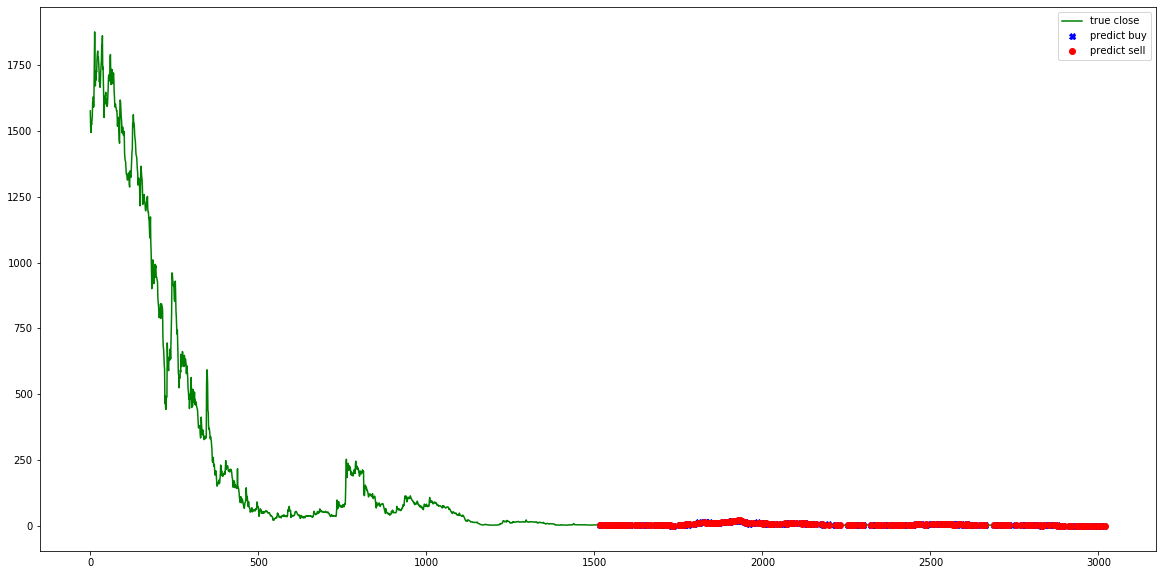

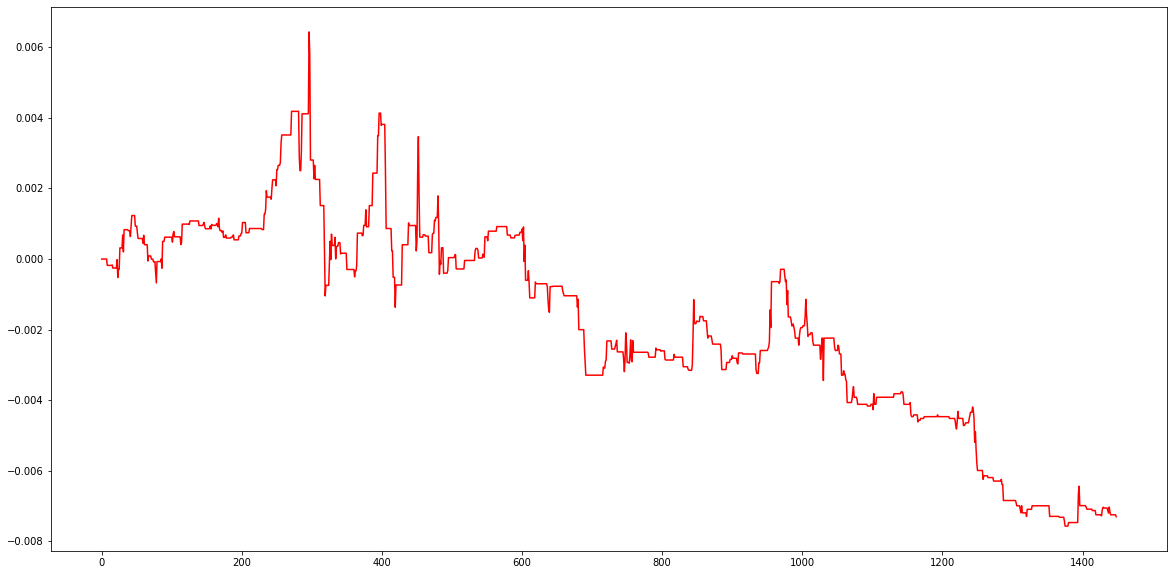

0.474525
0.5
0.5005
0.5
0.5
iter 10. reward: -0.793096
day 1510: buy 1 units at price 5.099975, total balance 99994.900025
day 1512, sell 1 units at price 5.264974, total balance 100000.164999,
day 1519: buy 1 units at price 4.949975, total balance 99995.215024
day 1521: buy 2 units at price 10.109949, total balance 99985.105074
day 1522: buy 1 units at price 5.024975, total balance 99980.080100
day 1523, sell 4 units at price 19.811901, total balance 99999.892001,
day 1530: buy 1 units at price 5.399973, total balance 99994.492028
day 1533, sell 1 units at price 5.459973, total balance 99999.952000,
day 1541: buy 1 units at price 6.074970, total balance 99993.877031
day 1542, sell 1 units at price 6.284969, total balance 100000.161999,
day 1546: buy 1 units at price 5.590472, total balance 99994.571527
day 1547, sell 1 units at price 5.249974, total balance 99999.821501,
day 1549: buy 1 units at price 5.744971, total balance 99994.076530
day 1550, sell 1 units at price 5.714971, total

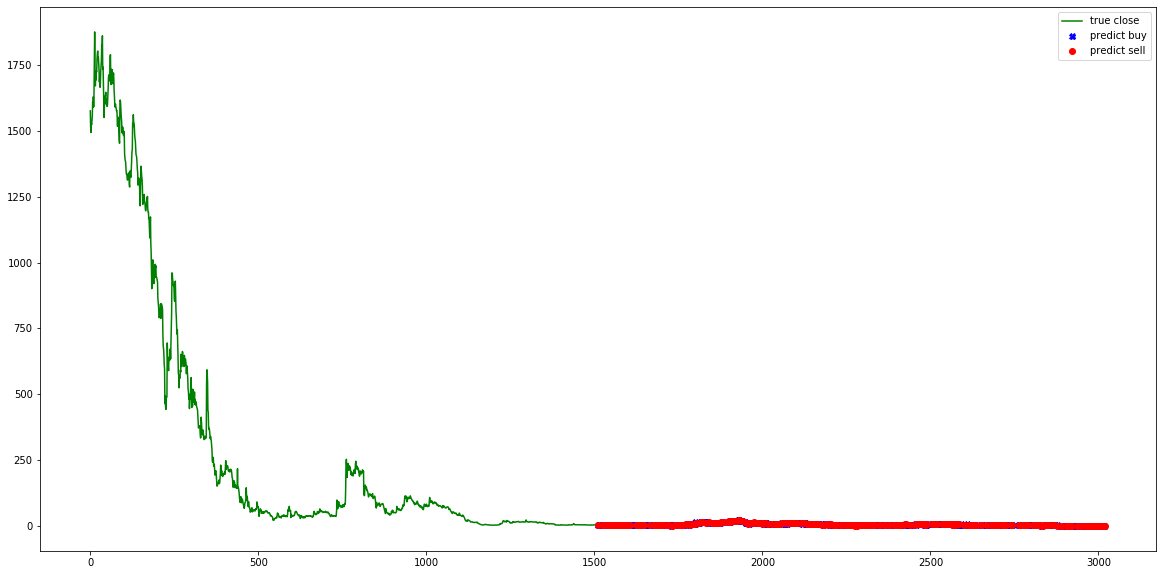

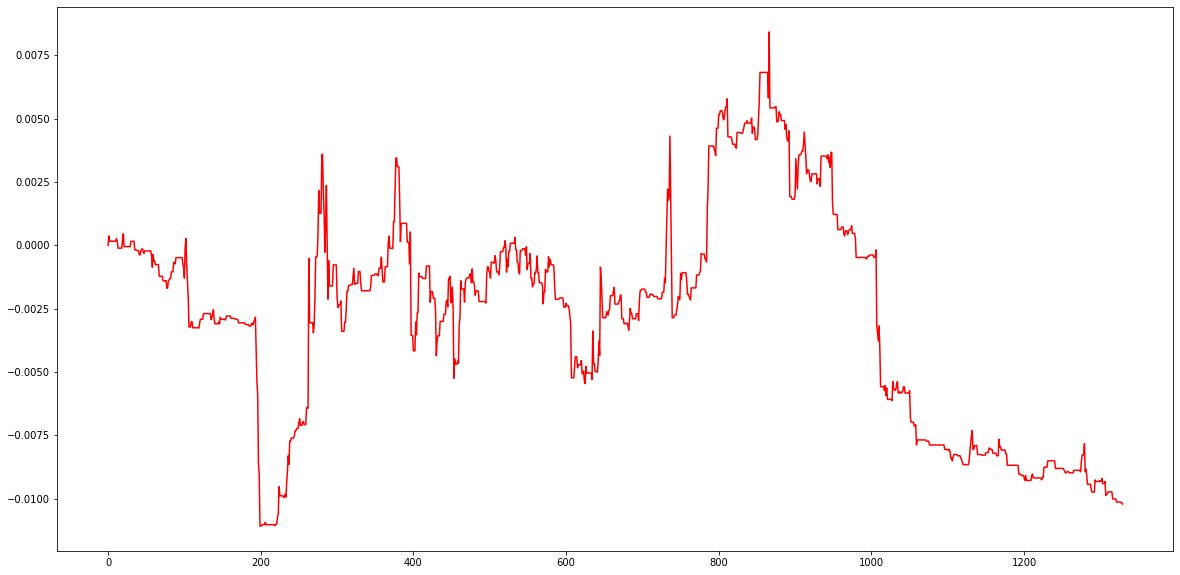

0.475
0.45125
0.45125
0.45125
0.5005
iter 15. reward: -0.710735
day 1521: buy 7 units at price 35.384823, total balance 99964.615177
day 1522: buy 1 units at price 5.024975, total balance 99959.590202
day 1523, sell 8 units at price 39.623802, total balance 99999.214004,
day 1530: buy 1 units at price 5.399973, total balance 99993.814031
day 1532, sell 1 units at price 5.966970, total balance 99999.781001,
day 1534: buy 1 units at price 5.699971, total balance 99994.081030
day 1536, sell 1 units at price 6.299968, total balance 100000.380998,
day 1539: buy 1 units at price 5.947470, total balance 99994.433528
day 1540, sell 1 units at price 6.314968, total balance 100000.748496,
day 1544: buy 1 units at price 5.767471, total balance 99994.981025
day 1546: buy 1 units at price 5.590472, total balance 99989.390553
day 1547, sell 2 units at price 10.499947, total balance 99999.890501,
day 1552: buy 1 units at price 5.566472, total balance 99994.324028
day 1553, sell 1 units at price 5.399

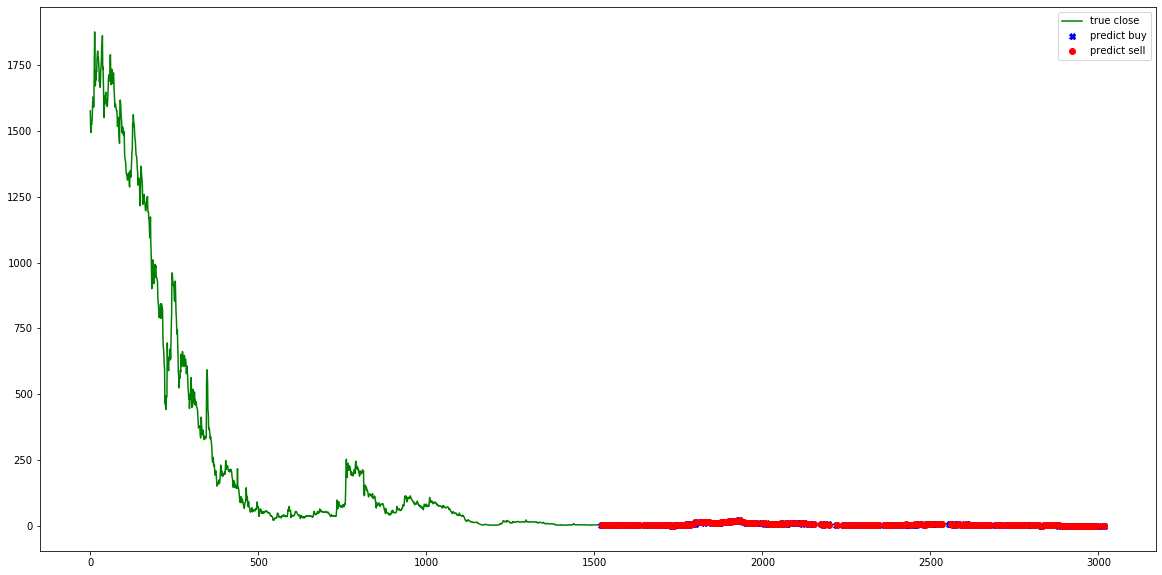

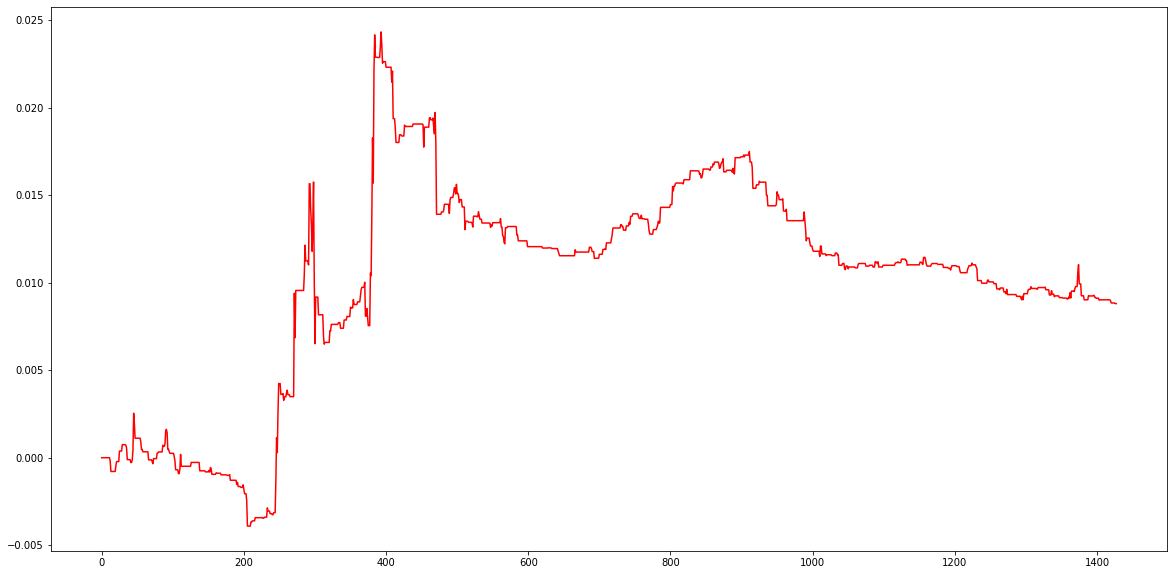

0.5005
0.5005
0.5005
0.5005
0.5005
iter 20. reward: -1.343777
day 1517: buy 3 units at price 15.524922, total balance 99984.475078
day 1518, sell 3 units at price 14.984925, total balance 99999.460003,
day 1519: buy 1 units at price 4.949975, total balance 99994.510027
day 1520, sell 1 units at price 4.964975, total balance 99999.475003,
day 1521: buy 4 units at price 20.219899, total balance 99979.255104
day 1522: buy 5 units at price 25.124874, total balance 99954.130229
day 1523, sell 9 units at price 44.576777, total balance 99998.707006,
day 1530: buy 1 units at price 5.399973, total balance 99993.307033
day 1531, sell 1 units at price 5.729971, total balance 99999.037005,
day 1532: buy 3 units at price 17.900910, total balance 99981.136094
day 1533, sell 3 units at price 16.379918, total balance 99997.516012,
day 1541: buy 1 units at price 6.074970, total balance 99991.441043
day 1542, sell 1 units at price 6.284969, total balance 99997.726011,
day 1546: buy 1 units at price 5.59

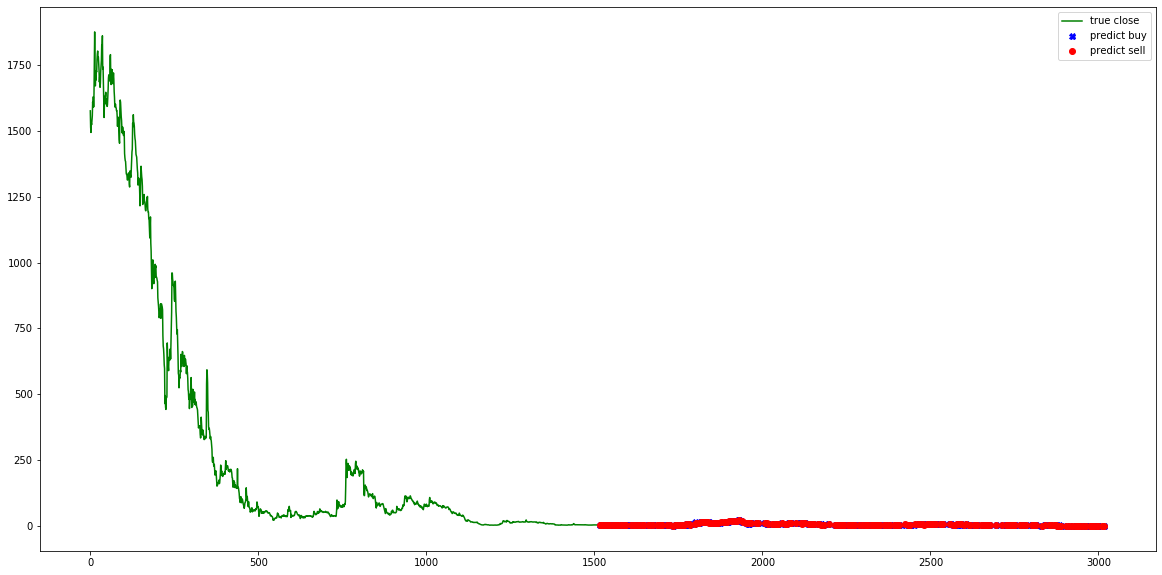

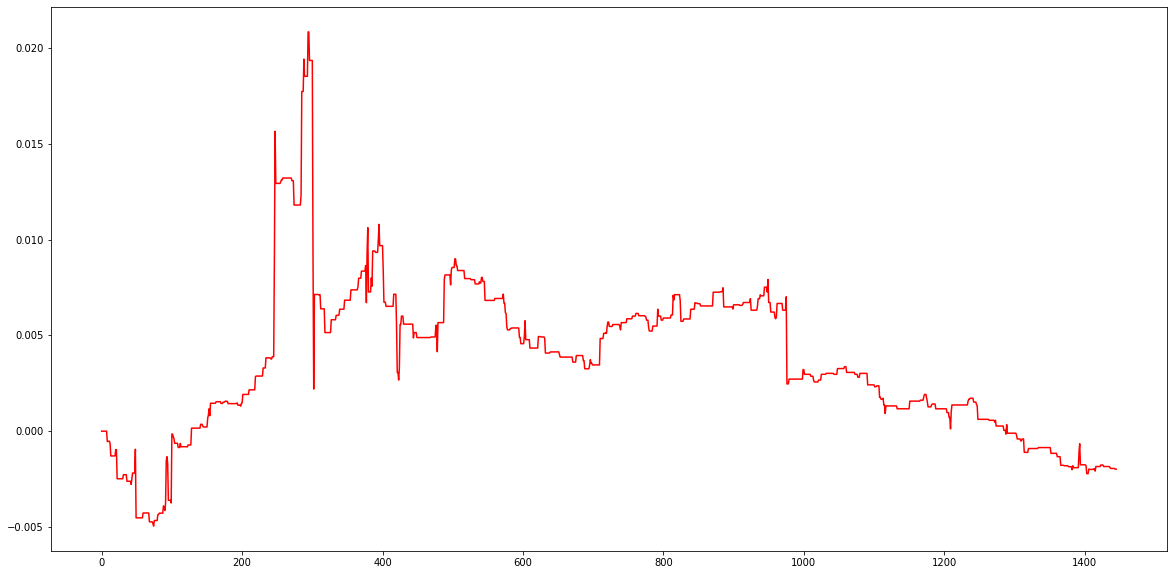

0.5005
0.5005
0.5005
0.5005
0.5
iter 25. reward: -0.371488
day 1522: buy 1 units at price 5.024975, total balance 99994.975025
day 1523, sell 1 units at price 4.952975, total balance 99999.928000,
day 1530: buy 1 units at price 5.399973, total balance 99994.528027
day 1532, sell 1 units at price 5.966970, total balance 100000.494998,
day 1535: buy 1 units at price 5.699971, total balance 99994.795026
day 1537, sell 1 units at price 6.269969, total balance 100001.064995,
day 1546: buy 1 units at price 5.590472, total balance 99995.474523
day 1547, sell 1 units at price 5.249974, total balance 100000.724496,
day 1552: buy 1 units at price 5.566472, total balance 99995.158024
day 1553, sell 1 units at price 5.399973, total balance 100000.557997,
day 1559: buy 2 units at price 12.092940, total balance 99988.465058
day 1561, sell 2 units at price 11.702941, total balance 100000.167999,
day 1565: buy 1 units at price 5.549972, total balance 99994.618027
day 1566, sell 1 units at price 5.5499

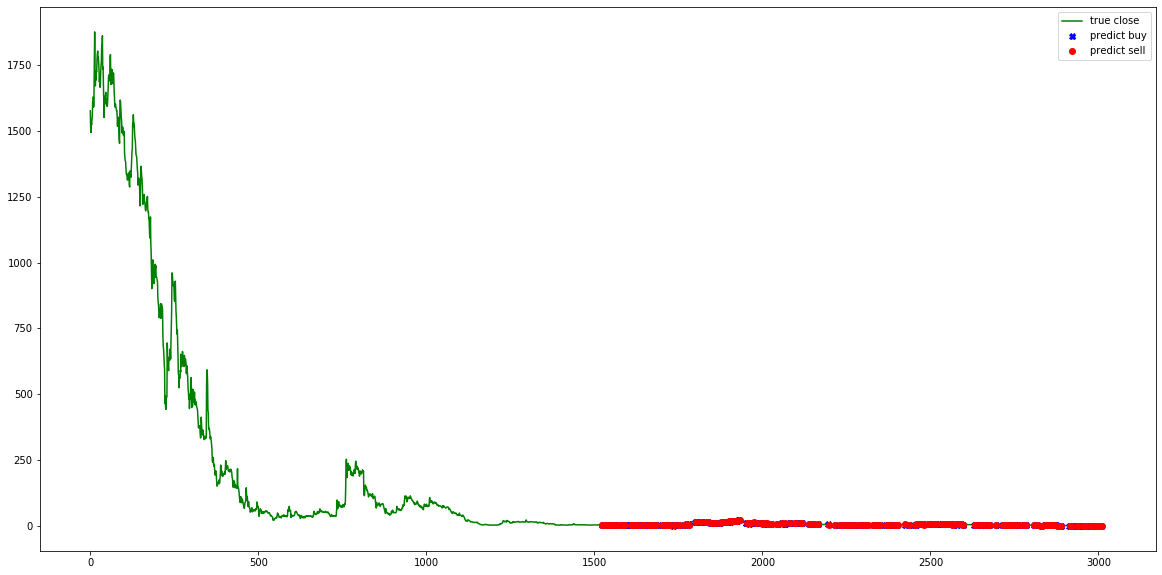

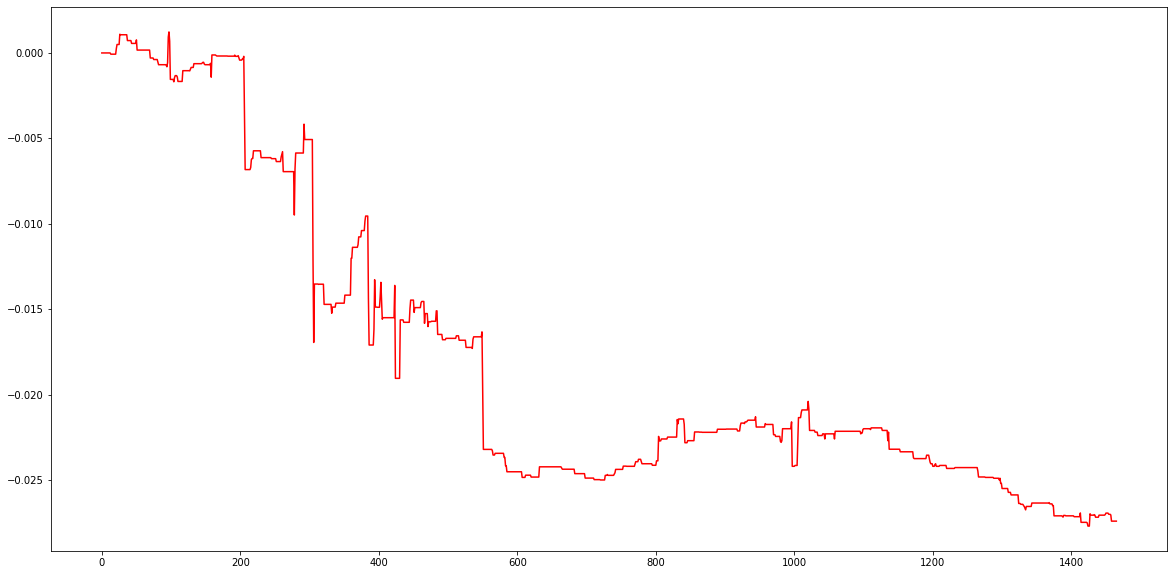

0.5005
0.5005
0.5
0.5
0.5
iter 30. reward: 0.158491
day 1522: buy 1 units at price 5.024975, total balance 99994.975025
day 1523, sell 1 units at price 4.952975, total balance 99999.928000,
day 1559: buy 1 units at price 6.046470, total balance 99993.881531
day 1561, sell 1 units at price 5.851471, total balance 99999.733001,
day 1584: buy 1 units at price 4.349978, total balance 99995.383023
day 1585, sell 1 units at price 4.259979, total balance 99999.643002,
day 1590: buy 5 units at price 20.999895, total balance 99978.643107
day 1591, sell 5 units at price 20.257399, total balance 99998.900506,
day 1608: buy 1 units at price 4.950000, total balance 99993.950506
day 1609, sell 1 units at price 4.630000, total balance 99998.580506,
day 1631: buy 10 units at price 39.400000, total balance 99959.180506
day 1632, sell 10 units at price 41.500000, total balance 100000.680506,
day 1647: buy 1 units at price 3.810000, total balance 99996.870506
day 1649, sell 1 units at price 4.130000, tot

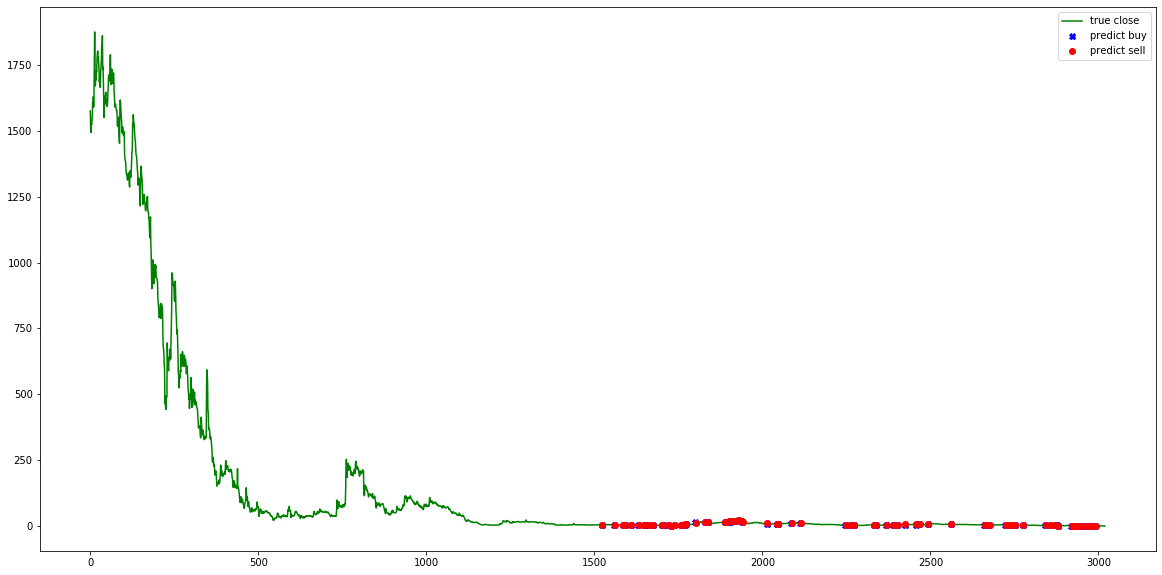

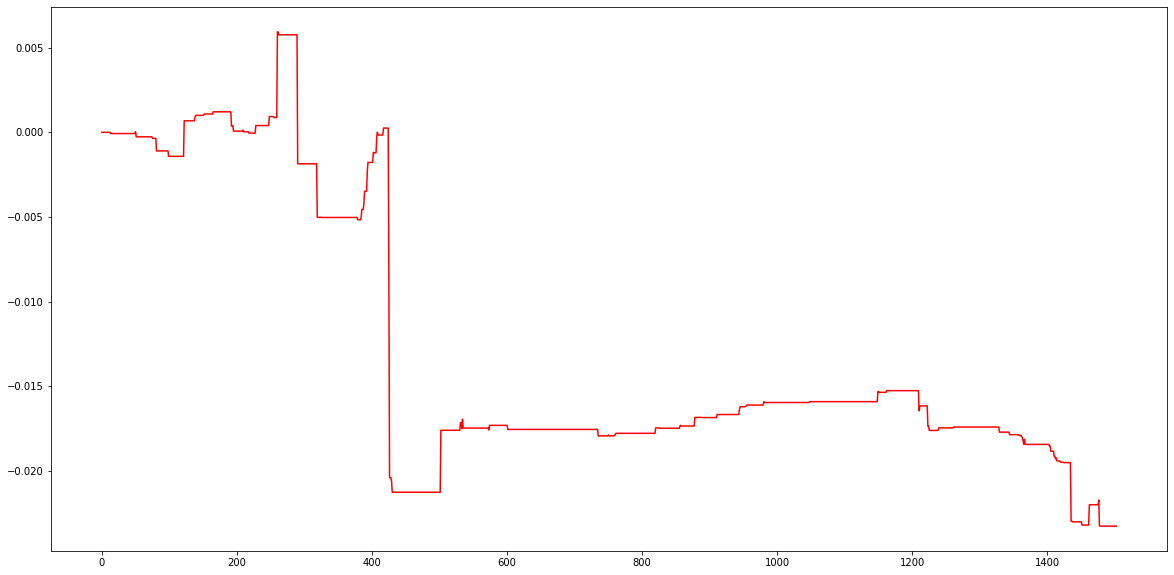

0.5
0.5
0.5
0.5
0.5
iter 35. reward: 0.121840
day 1521: buy 1 units at price 5.054975, total balance 99994.945025
day 1522, sell 1 units at price 5.024975, total balance 99999.970000,
day 1534: buy 1 units at price 5.699971, total balance 99994.270029
day 1535, sell 1 units at price 5.699971, total balance 99999.970000,
day 1540: buy 1 units at price 6.314968, total balance 99993.655032
day 1542, sell 1 units at price 6.284969, total balance 99999.940000,
day 1550: buy 2 units at price 11.429943, total balance 99988.510057
day 1551, sell 2 units at price 11.129944, total balance 99999.640002,
day 1584: buy 1 units at price 4.349978, total balance 99995.290024
day 1585, sell 1 units at price 4.259979, total balance 99999.550002,
day 1608: buy 1 units at price 4.950000, total balance 99994.600002
day 1609, sell 1 units at price 4.630000, total balance 99999.230002,
day 1620: buy 1 units at price 3.960000, total balance 99995.270002
day 1622, sell 1 units at price 3.790000, total balance 

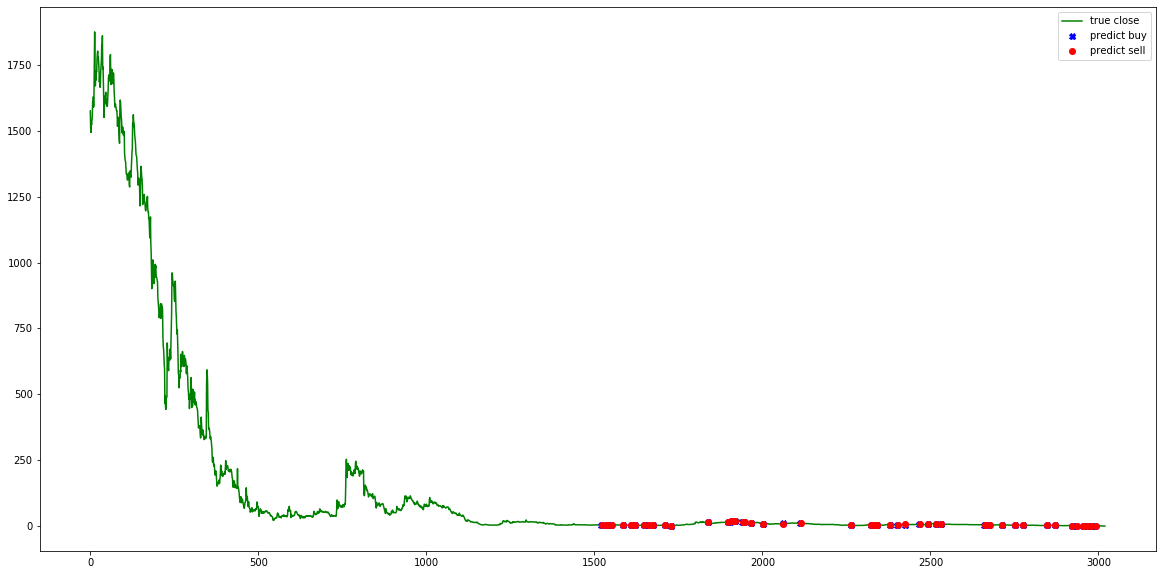

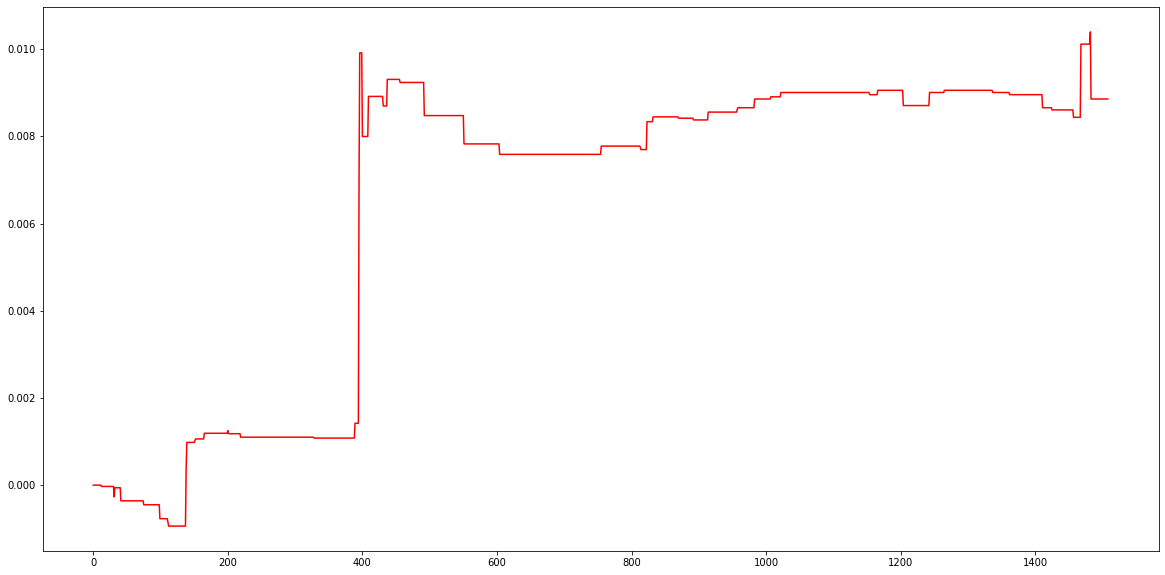

0.5
0.5
0.5
0.5
0.5
iter 40. reward: 0.641271
day 1550: buy 1 units at price 5.714971, total balance 99994.285029
day 1551, sell 1 units at price 5.564972, total balance 99999.850001,
day 1555: buy 7 units at price 40.907795, total balance 99958.942205
day 1556: buy 10 units at price 59.234704, total balance 99899.707501
day 1558, sell 17 units at price 104.549477, total balance 100004.256979,
day 1606: buy 1 units at price 4.990000, total balance 99999.266979
day 1607, sell 1 units at price 5.040000, total balance 100004.306979,
day 1608: buy 1 units at price 4.950000, total balance 99999.356979
day 1609, sell 1 units at price 4.630000, total balance 100003.986979,
day 1626: buy 1 units at price 3.670000, total balance 100000.316979
day 1628, sell 1 units at price 3.840000, total balance 100004.156979,
day 1645: buy 1 units at price 3.830000, total balance 100000.326979
day 1647, sell 1 units at price 3.810000, total balance 100004.136979,
day 1657: buy 4 units at price 15.960000, tot

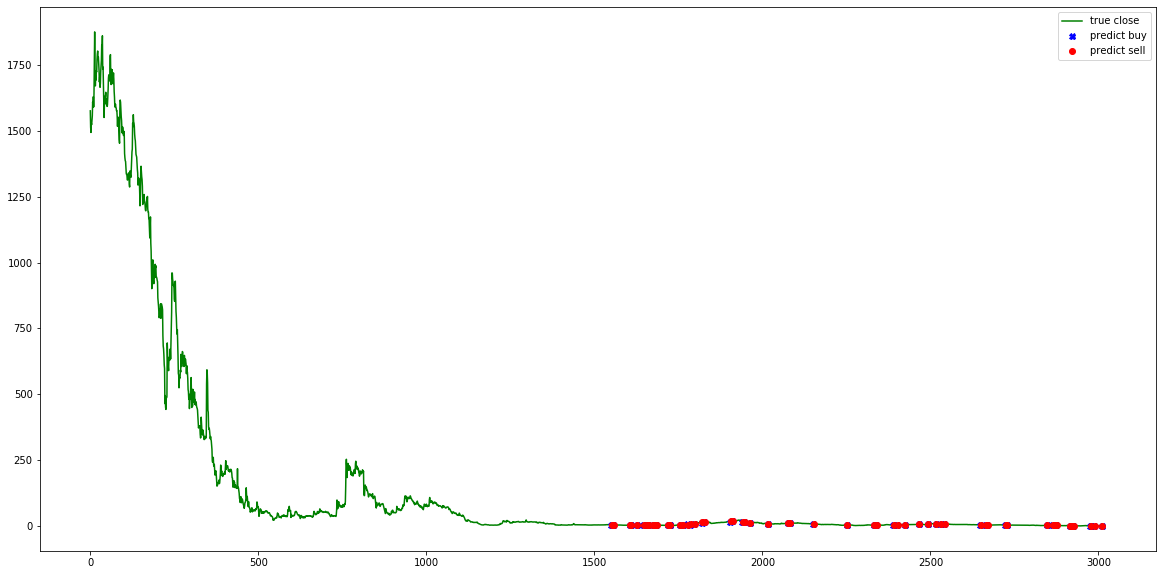

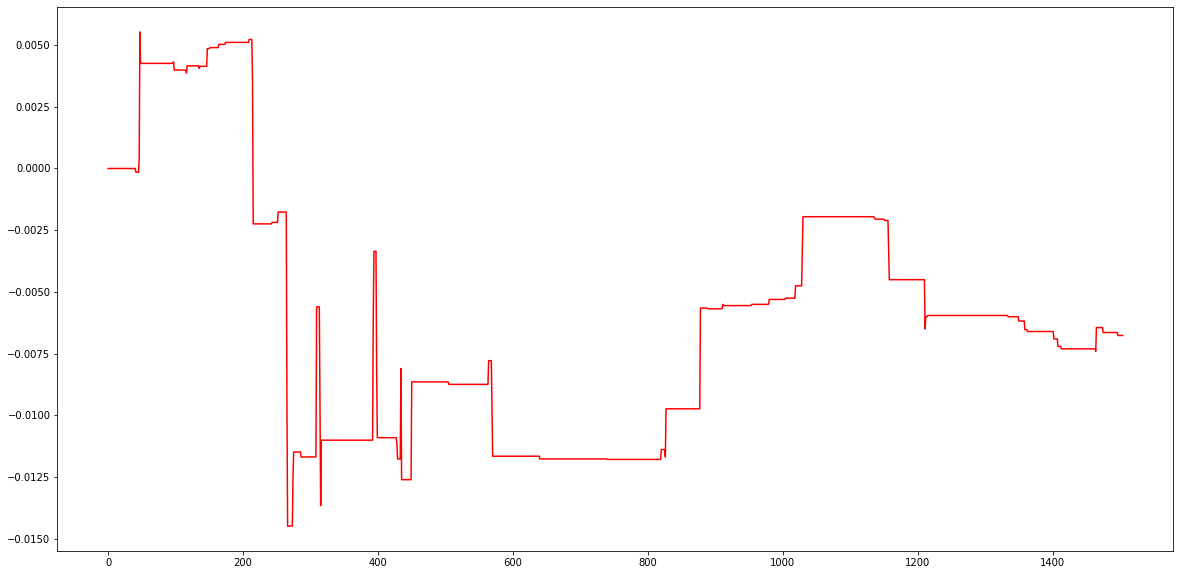

0.5
0.475
0.45125
0.42868749999999994
0.40725312499999994
iter 45. reward: 7.246761
day 1534: buy 1 units at price 5.699971, total balance 99994.300029
day 1535: buy 1 units at price 5.699971, total balance 99988.600057
day 1536, sell 2 units at price 12.599937, total balance 100001.199994,
day 1550: buy 1 units at price 5.714971, total balance 99995.485023
day 1551, sell 1 units at price 5.564972, total balance 100001.049995,
day 1555: buy 24 units at price 140.255299, total balance 99860.794696
day 1556: buy 16 units at price 94.775526, total balance 99766.019170
day 1558, sell 40 units at price 245.998770, total balance 100012.017940,
day 1590: buy 2 units at price 8.399958, total balance 100003.617982
day 1591, sell 2 units at price 8.102959, total balance 100011.720941,
day 1606: buy 1 units at price 4.990000, total balance 100006.730941
day 1607, sell 1 units at price 5.040000, total balance 100011.770941,
day 1617: buy 15 units at price 57.150000, total balance 99954.620941
day 

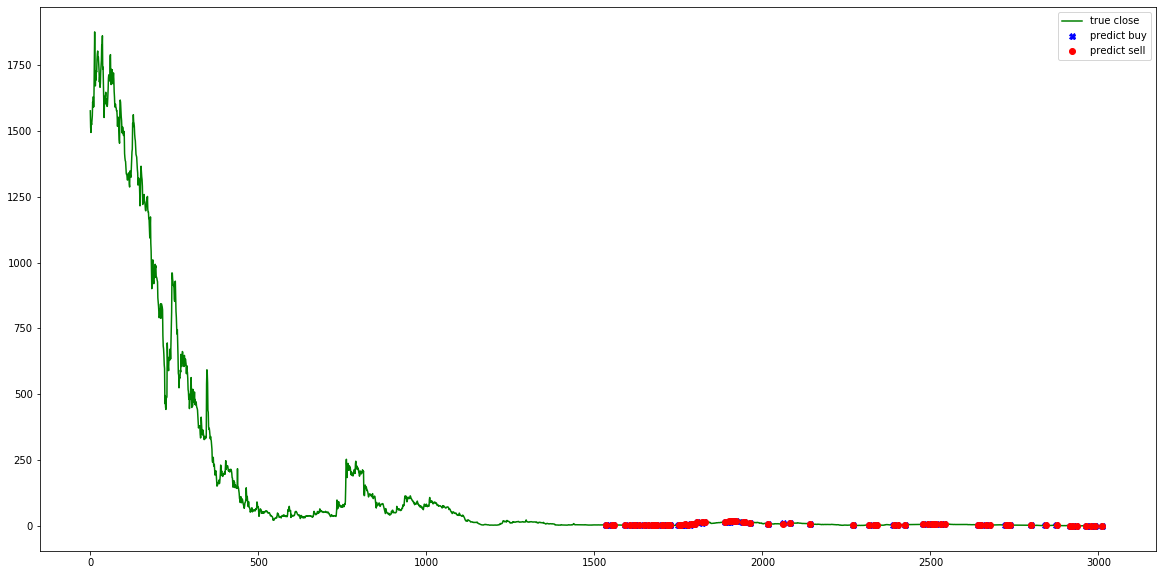

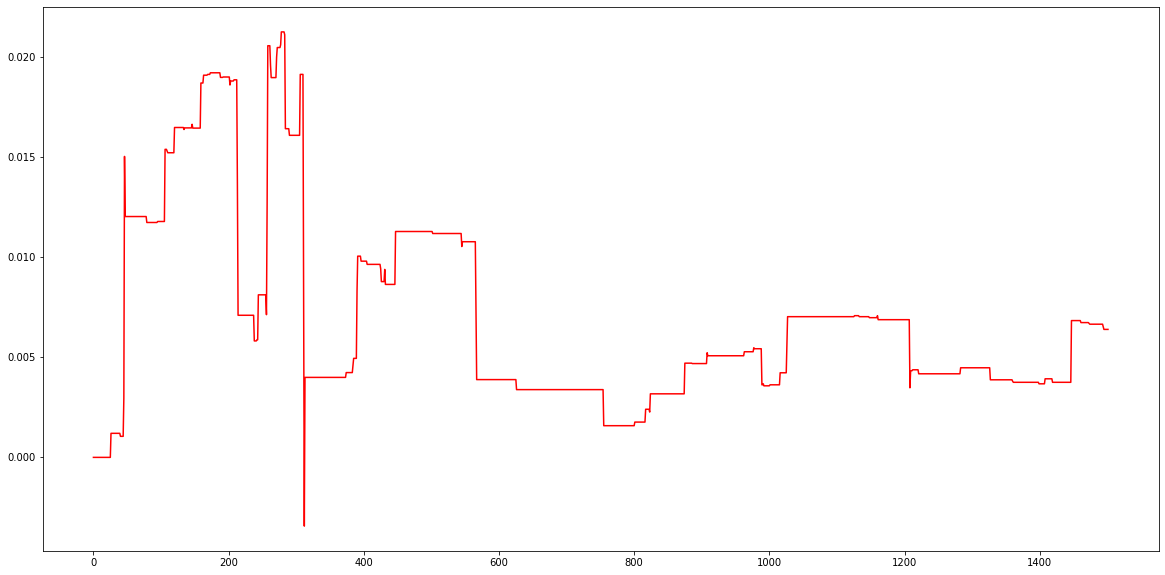

0.38689046874999994
0.3675459453124999
0.34916864804687486
0.34916864804687486
0.34916864804687486
iter 50. reward: 11.530459
day 1530: buy 23 units at price 124.199379, total balance 99875.800621
day 1531, sell 23 units at price 131.789341, total balance 100007.589962,
day 1550: buy 1 units at price 5.714971, total balance 100001.874991
day 1554, sell 1 units at price 5.692472, total balance 100007.567462,
day 1556: buy 10 units at price 59.234704, total balance 99948.332758
day 1557: buy 11 units at price 68.474658, total balance 99879.858101
day 1558, sell 21 units at price 129.149354, total balance 100009.007455,
day 1590: buy 1 units at price 4.199979, total balance 100004.807476
day 1591, sell 1 units at price 4.051480, total balance 100008.858956,
day 1606: buy 1 units at price 4.990000, total balance 100003.868956
day 1607, sell 1 units at price 5.040000, total balance 100008.908956,
day 1617: buy 25 units at price 95.250000, total balance 99913.658956
day 1618, sell 25 units a

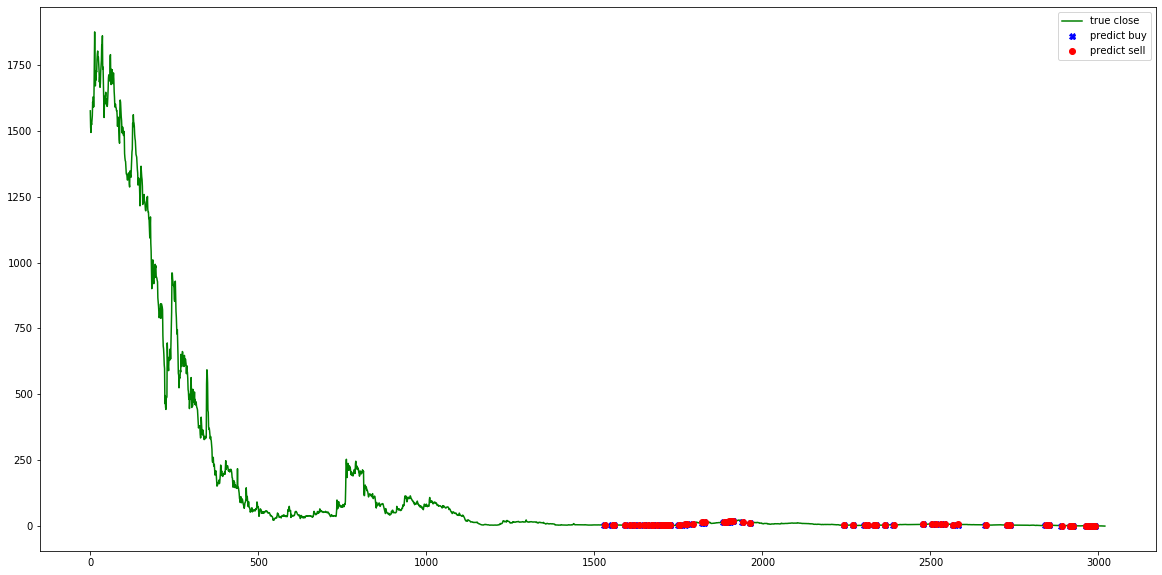

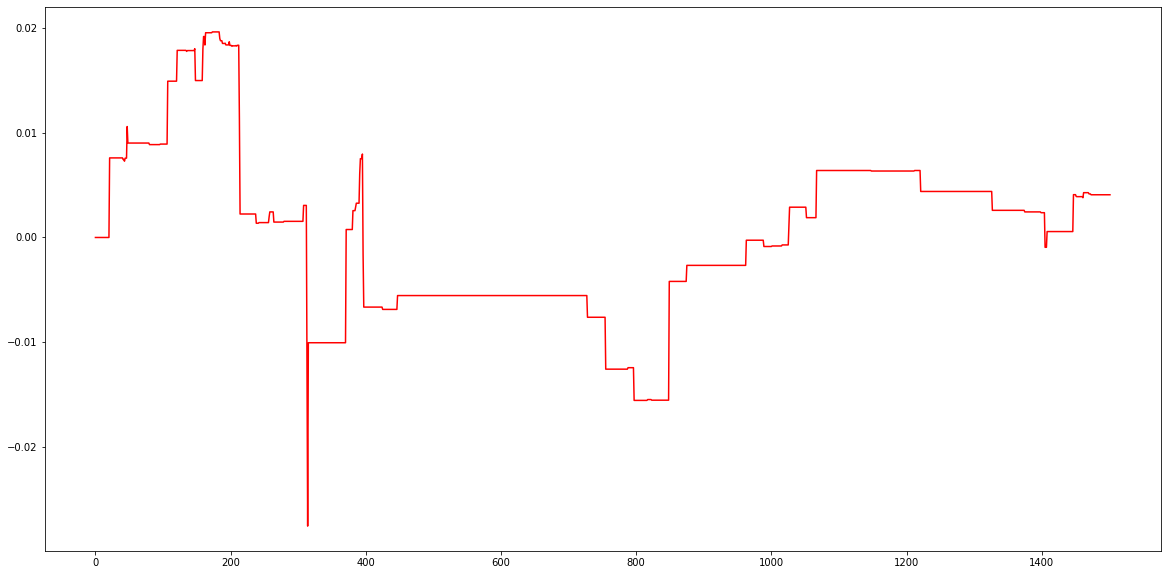

0.3317102156445311
0.3317102156445311
0.31512470486230454
0.2993684696191893
0.2844000461382298
iter 55. reward: 16.185317
day 1530: buy 27 units at price 145.799271, total balance 99854.200729
day 1531, sell 27 units at price 154.709226, total balance 100008.909955,
day 1550: buy 1 units at price 5.714971, total balance 100003.194984
day 1552, sell 1 units at price 5.566472, total balance 100008.761456,
day 1555: buy 19 units at price 111.035445, total balance 99897.726011
day 1556: buy 9 units at price 53.311233, total balance 99844.414778
day 1557: buy 20 units at price 124.499378, total balance 99719.915400
day 1558, sell 48 units at price 295.198524, total balance 100015.113924,
day 1575: buy 6 units at price 29.096855, total balance 99986.017070
day 1576, sell 6 units at price 28.349858, total balance 100014.366928,
day 1579: buy 1 units at price 4.669477, total balance 100009.697452
day 1580, sell 1 units at price 4.205979, total balance 100013.903430,
day 1590: buy 1 units at p

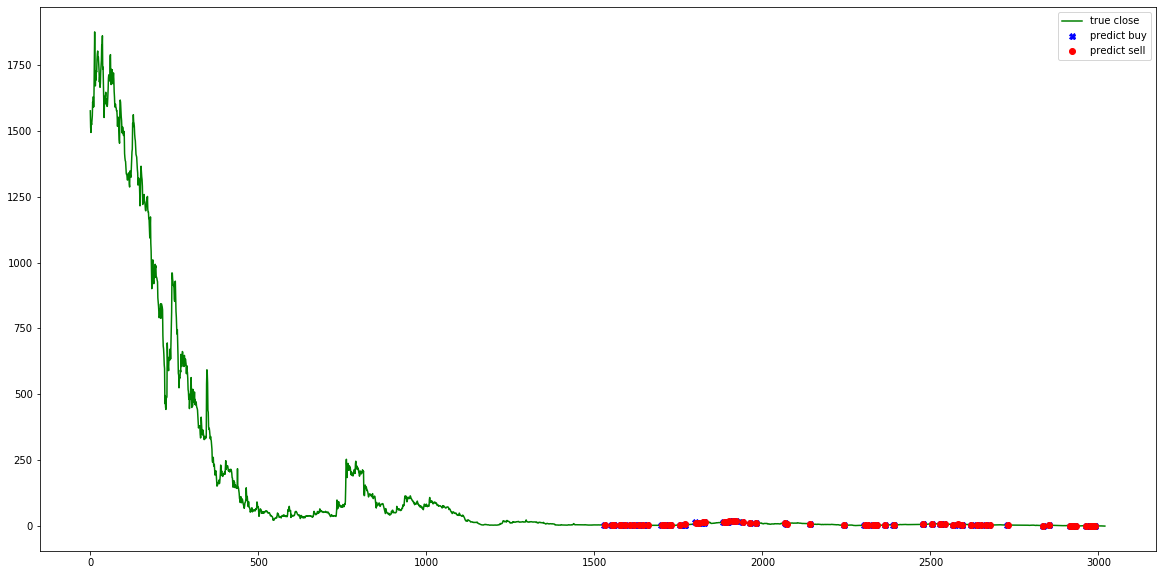

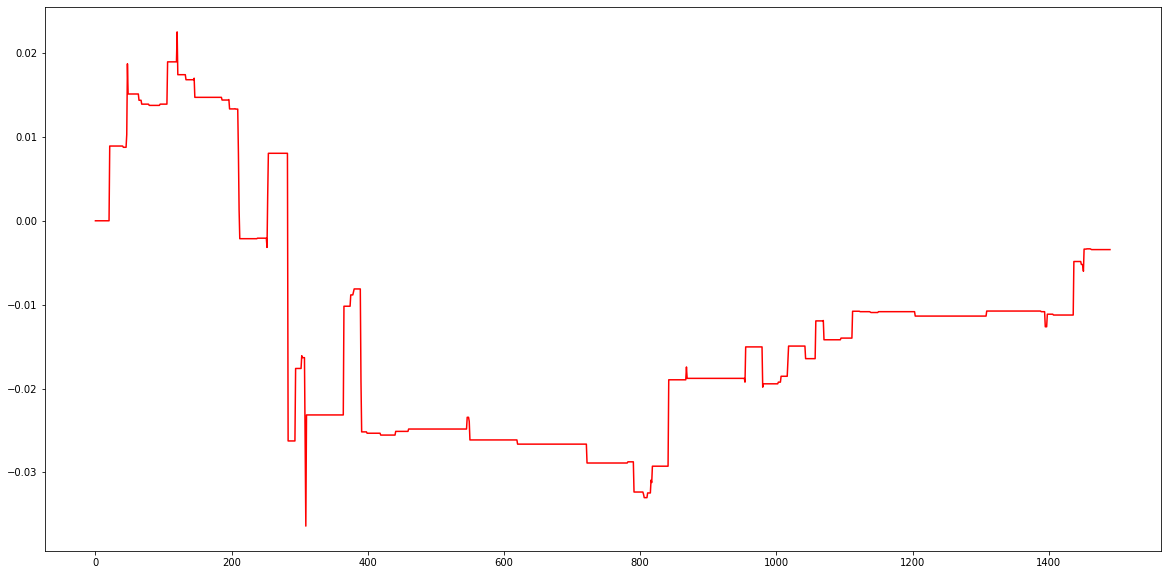

0.2701800438313183
0.25667104163975235
0.24383748955776471
0.21945374060198825
0.21945374060198825
iter 60. reward: 22.954674
day 1517: buy 28 units at price 144.899276, total balance 99855.100724
day 1518, sell 28 units at price 139.859301, total balance 99994.960025,
day 1519: buy 1 units at price 4.949975, total balance 99990.010050
day 1520, sell 1 units at price 4.964975, total balance 99994.975025,
day 1530: buy 35 units at price 188.999055, total balance 99805.975970
day 1531, sell 35 units at price 200.548997, total balance 100006.524967,
day 1541: buy 2 units at price 12.149939, total balance 99994.375028
day 1542, sell 2 units at price 12.569937, total balance 100006.944965,
day 1550: buy 1 units at price 5.714971, total balance 100001.229994
day 1551: buy 1 units at price 5.564972, total balance 99995.665022
day 1552, sell 2 units at price 11.132944, total balance 100006.797966,
day 1556: buy 5 units at price 29.617352, total balance 99977.180614
day 1557: buy 22 units at pr

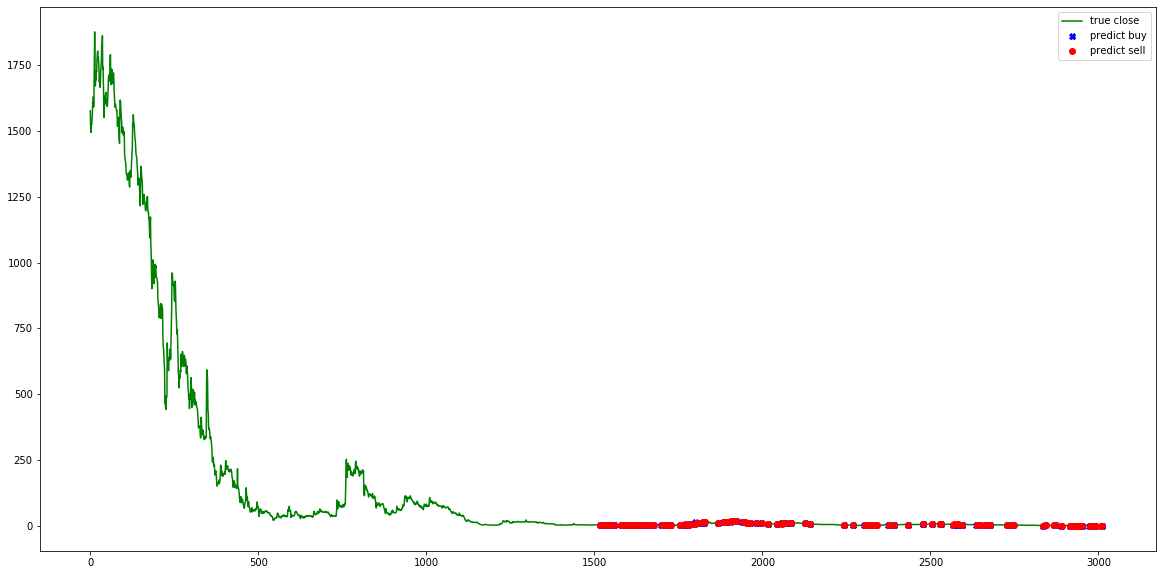

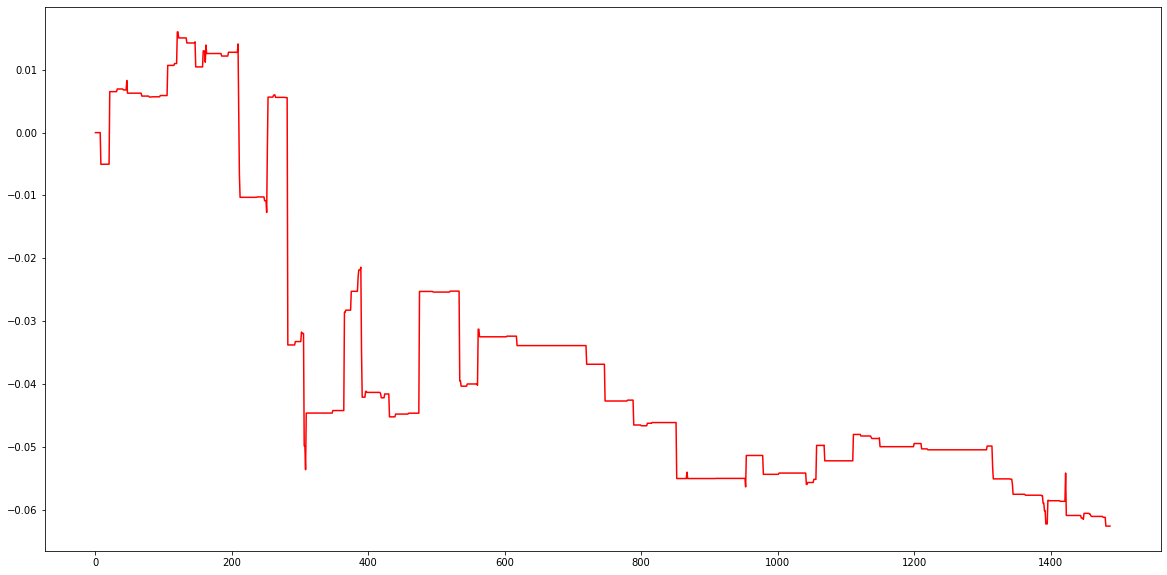

0.19750836654178944
0.1777575298876105
0.15998177689884946
0.14398359920896453
0.1295852392880681
iter 65. reward: 38.244037
day 1517: buy 28 units at price 144.899276, total balance 99855.100724
day 1518, sell 28 units at price 139.859301, total balance 99994.960025,
day 1519: buy 1 units at price 4.949975, total balance 99990.010050
day 1520, sell 1 units at price 4.964975, total balance 99994.975025,
day 1530: buy 41 units at price 221.398893, total balance 99773.576132
day 1531, sell 41 units at price 234.928825, total balance 100008.504957,
day 1532: buy 1 units at price 5.966970, total balance 100002.537987
day 1533, sell 1 units at price 5.459973, total balance 100007.997960,
day 1550: buy 1 units at price 5.714971, total balance 100002.282989
day 1552, sell 1 units at price 5.566472, total balance 100007.849461,
day 1555: buy 32 units at price 187.007065, total balance 99820.842396
day 1556: buy 6 units at price 35.540822, total balance 99785.301573
day 1557: buy 27 units at pr

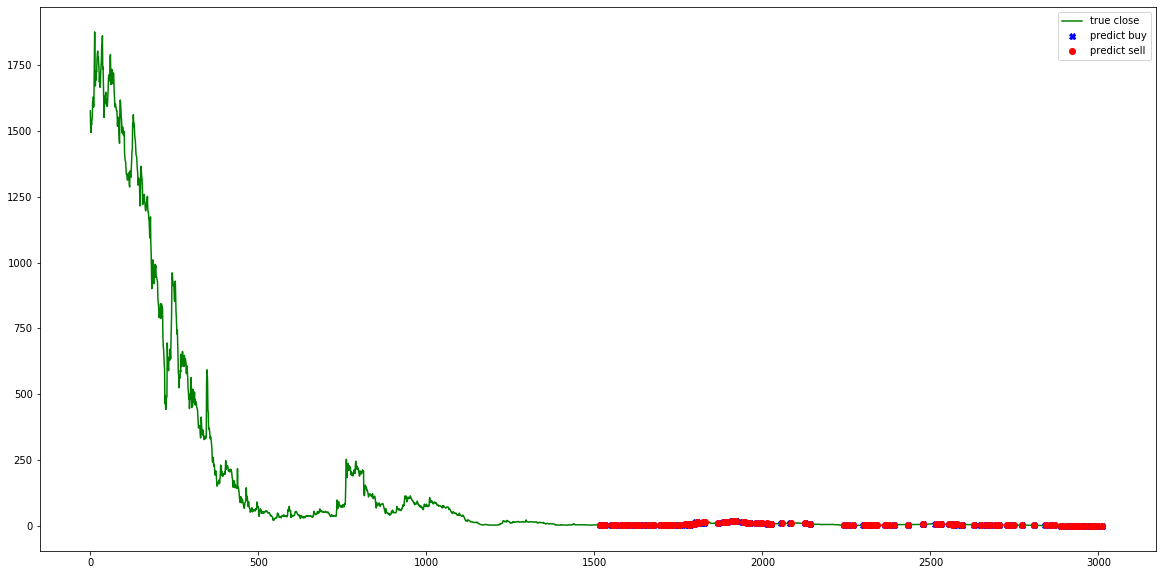

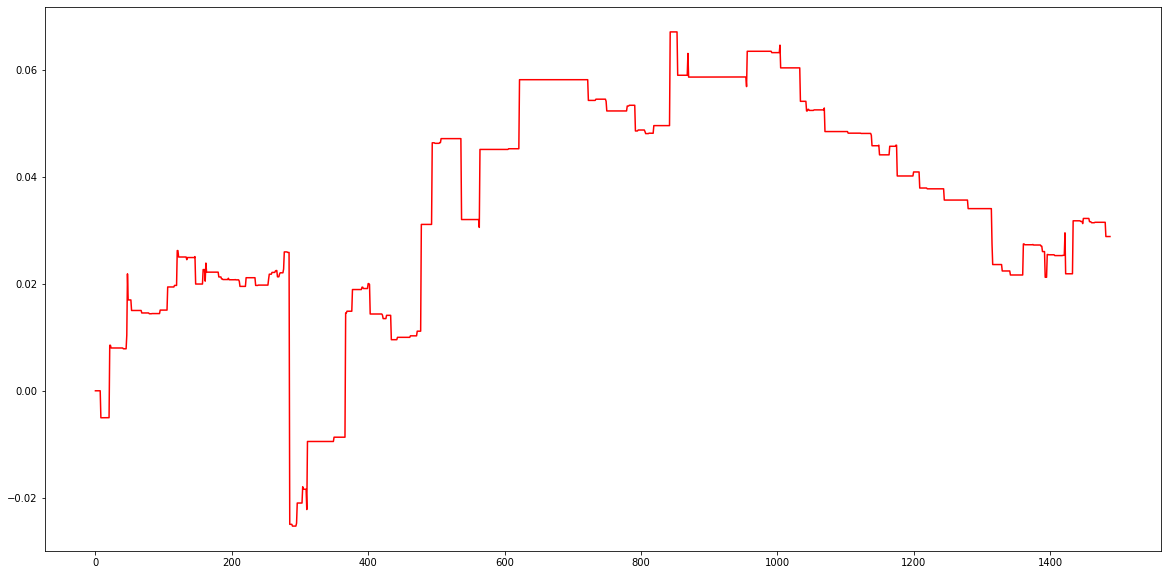

0.11662671535926128
0.11662671535926128
0.08192784397271521
0.061481555845341346
0.03756494928338863
iter 70. reward: 56.708488
day 1520: buy 9 units at price 44.684777, total balance 99955.315223
day 1521, sell 9 units at price 45.494773, total balance 100000.809996,
day 1532: buy 1 units at price 5.966970, total balance 99994.843026
day 1533, sell 1 units at price 5.459973, total balance 100000.302998,
day 1541: buy 3 units at price 18.224909, total balance 99982.078090
day 1542, sell 3 units at price 18.854906, total balance 100000.932995,
day 1550: buy 5 units at price 28.574857, total balance 99972.358138
day 1554, sell 5 units at price 28.462358, total balance 100000.820496,
day 1556: buy 15 units at price 88.852056, total balance 99911.968440
day 1557: buy 37 units at price 230.323848, total balance 99681.644592
day 1558, sell 52 units at price 319.798401, total balance 100001.442993,
day 1564: buy 14 units at price 79.820601, total balance 99921.622392
day 1565, sell 14 units a

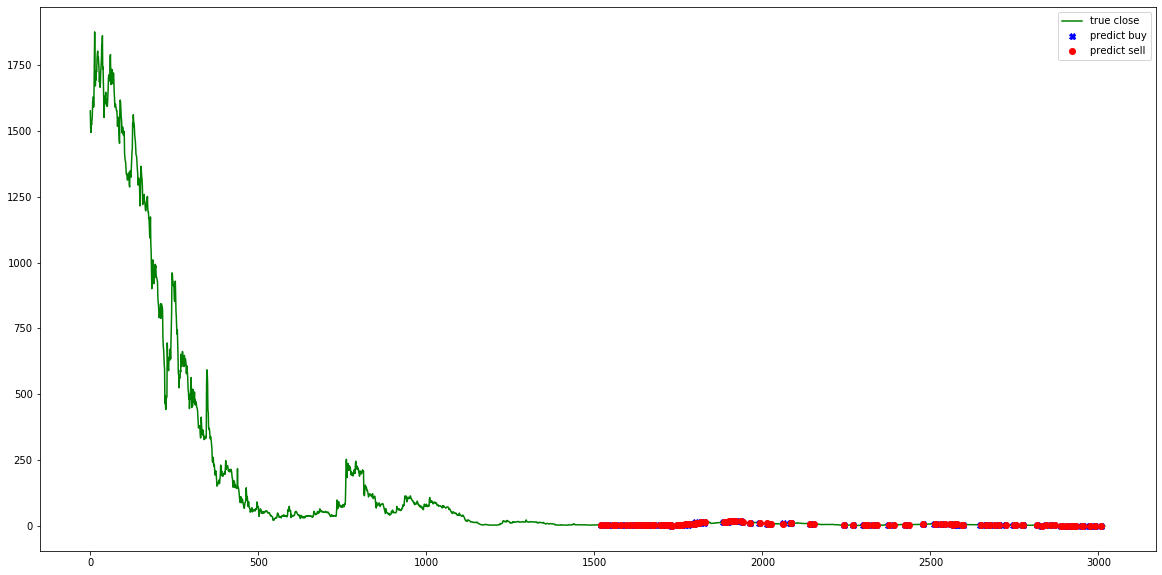

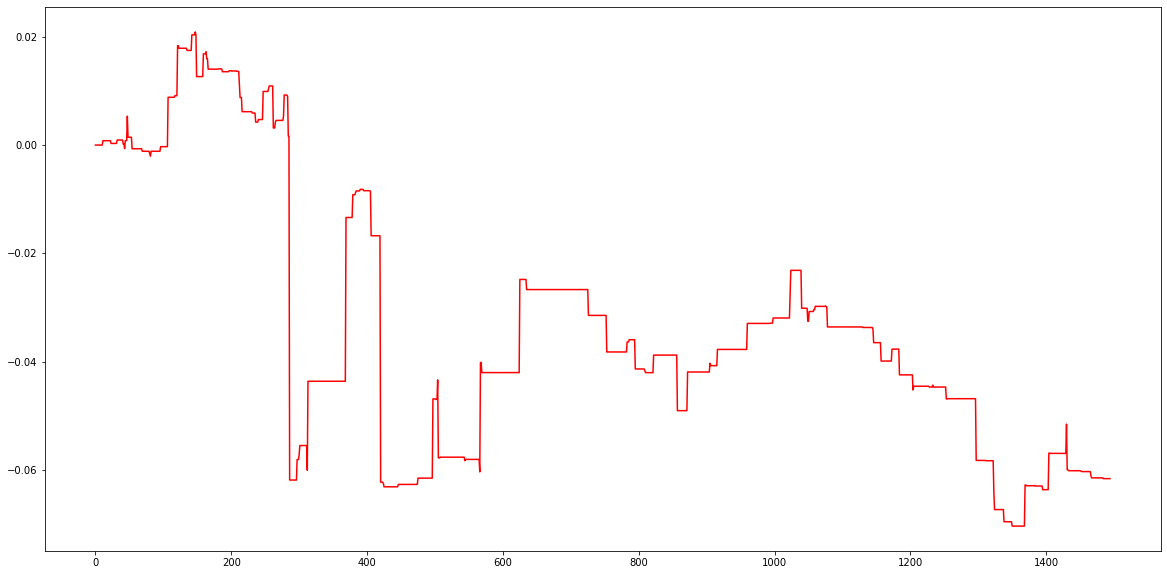

0.000651283317631096
0.000651283317631096
0.000651283317631096
0.000651283317631096
0.00018125491315340328
iter 75. reward: 68.328782
day 1519: buy 1 units at price 4.949975, total balance 99995.050025
day 1520: buy 21 units at price 104.264479, total balance 99890.785546
day 1521, sell 22 units at price 111.209444, total balance 100001.994990,
day 1530: buy 54 units at price 291.598542, total balance 99710.396448
day 1531, sell 54 units at price 309.418453, total balance 100019.814901,
day 1532: buy 1 units at price 5.966970, total balance 100013.847931
day 1533, sell 1 units at price 5.459973, total balance 100019.307903,
day 1556: buy 11 units at price 65.158174, total balance 99954.149729
day 1557: buy 33 units at price 205.423973, total balance 99748.725756
day 1558, sell 44 units at price 270.598647, total balance 100019.324403,
day 1559: buy 1 units at price 6.046470, total balance 100013.277934
day 1560, sell 1 units at price 6.149969, total balance 100019.427903,
day 1562: buy

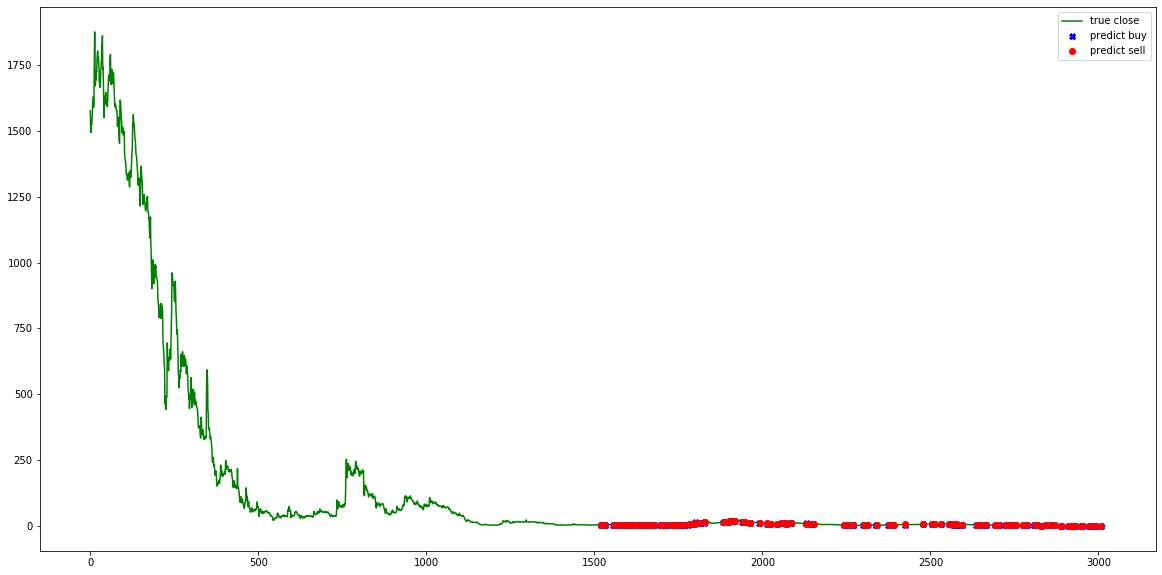

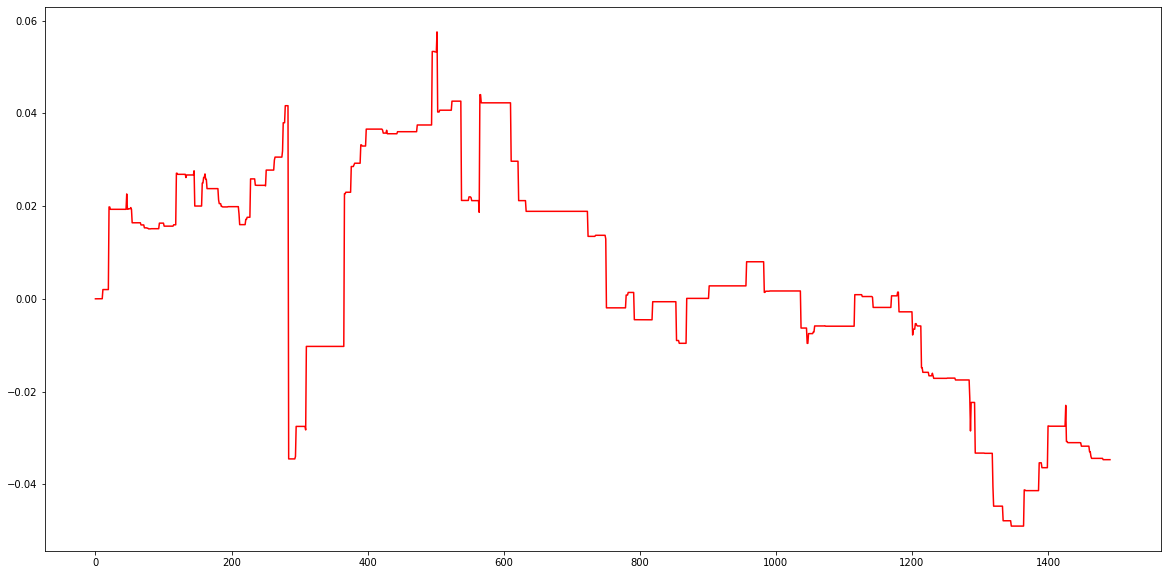

0.00018125491315340328
0.00018125491315340328
0.00018125491315340328
0.00018125491315340328
0.00018125491315340328
iter 80. reward: 39.225173
day 1530: buy 58 units at price 313.198434, total balance 99686.801566
day 1531, sell 58 units at price 332.338338, total balance 100019.139904,
day 1532: buy 1 units at price 5.966970, total balance 100013.172934
day 1533, sell 1 units at price 5.459973, total balance 100018.632907,
day 1553: buy 1 units at price 5.399973, total balance 100013.232934
day 1554, sell 1 units at price 5.692472, total balance 100018.925405,
day 1556: buy 22 units at price 130.316348, total balance 99888.609057
day 1557: buy 39 units at price 242.773786, total balance 99645.835271
day 1558, sell 61 units at price 375.148124, total balance 100020.983395,
day 1559: buy 1 units at price 6.046470, total balance 100014.936925
day 1560, sell 1 units at price 6.149969, total balance 100021.086895,
day 1562: buy 7 units at price 40.424798, total balance 99980.662097
day 1564

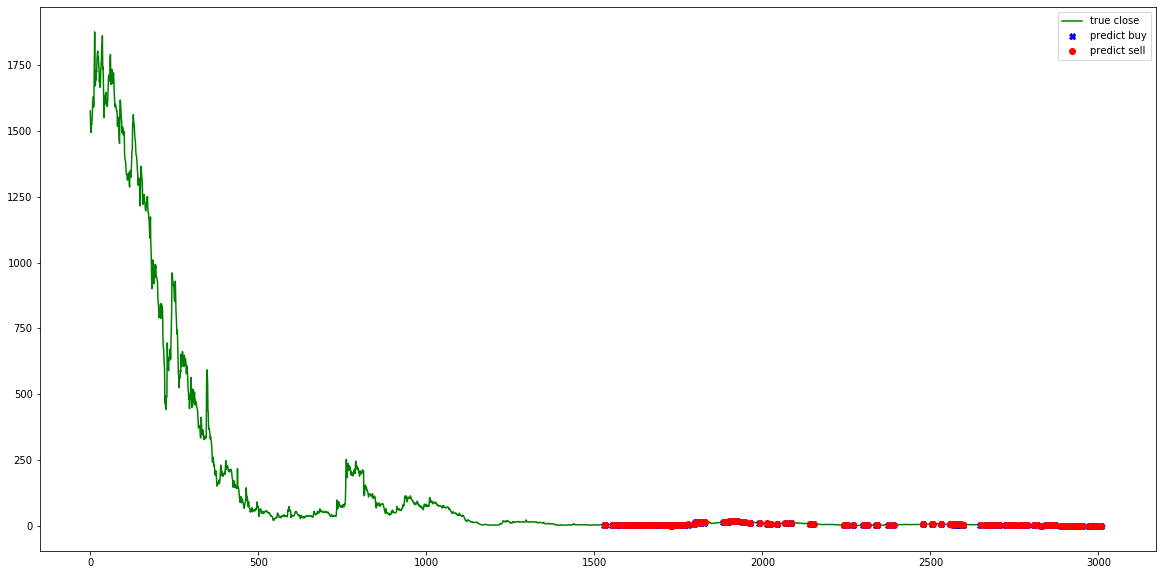

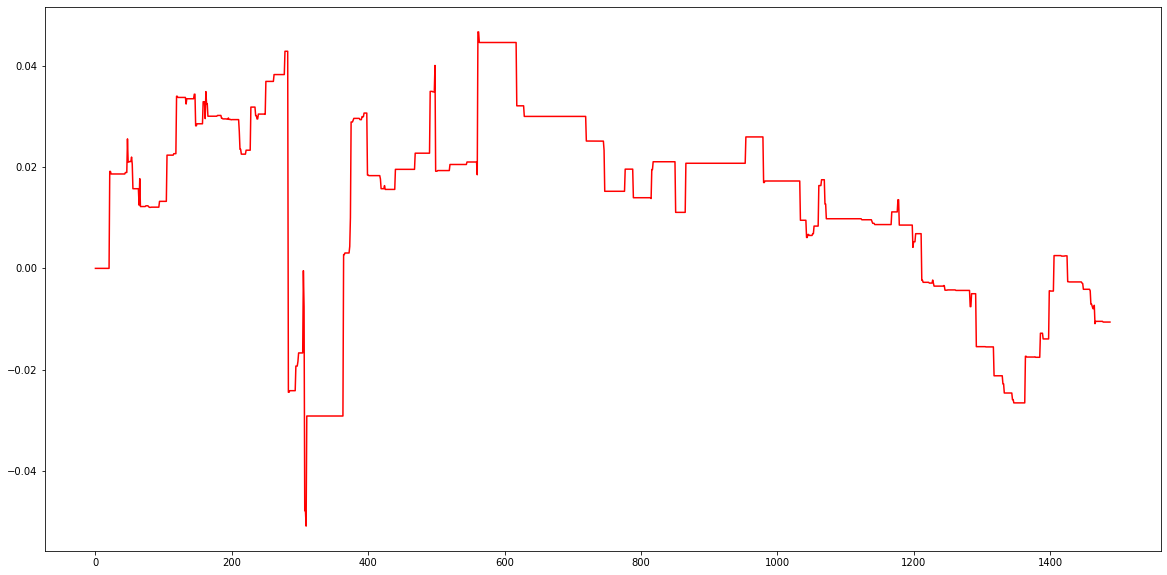

0.00018125491315340328
0.00018125491315340328
0.00018125491315340328
0.00018125491315340328
0.00018125491315340328
iter 85. reward: 42.610811
day 1519: buy 1 units at price 4.949975, total balance 99995.050025
day 1520, sell 1 units at price 4.964975, total balance 100000.015000,
day 1530: buy 62 units at price 334.798326, total balance 99665.216674
day 1531, sell 62 units at price 355.258224, total balance 100020.474898,
day 1532: buy 1 units at price 5.966970, total balance 100014.507927
day 1533, sell 1 units at price 5.459973, total balance 100019.967900,
day 1541: buy 4 units at price 24.299878, total balance 99995.668022
day 1542, sell 4 units at price 25.139874, total balance 100020.807896,
day 1554: buy 9 units at price 51.232244, total balance 99969.575652
day 1555, sell 9 units at price 52.595737, total balance 100022.171389,
day 1556: buy 17 units at price 100.698997, total balance 99921.472393
day 1557: buy 32 units at price 199.199004, total balance 99722.273389
day 1558, 

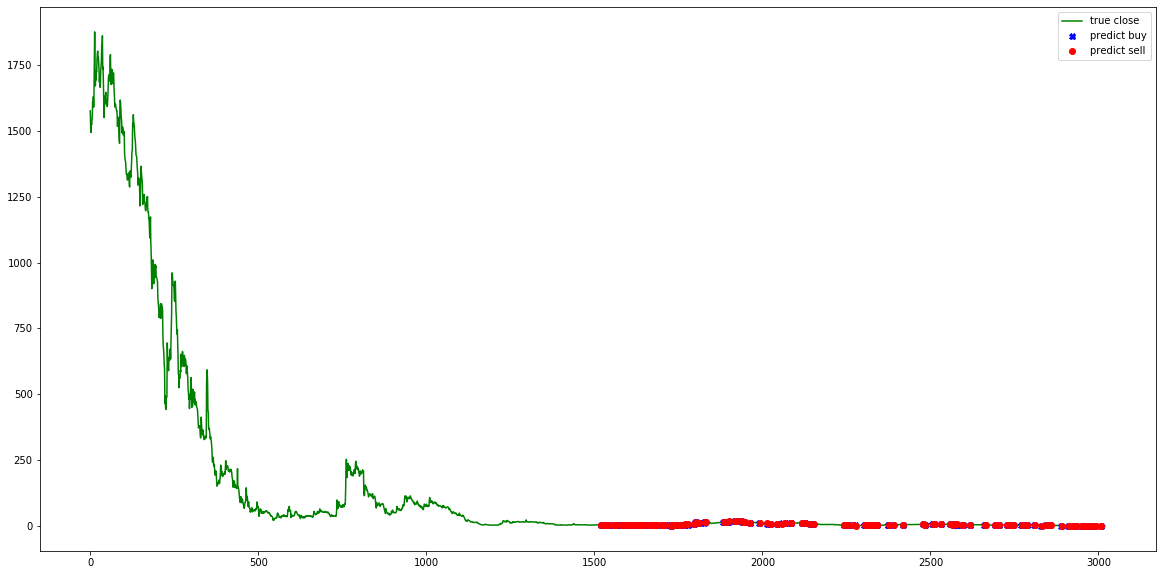

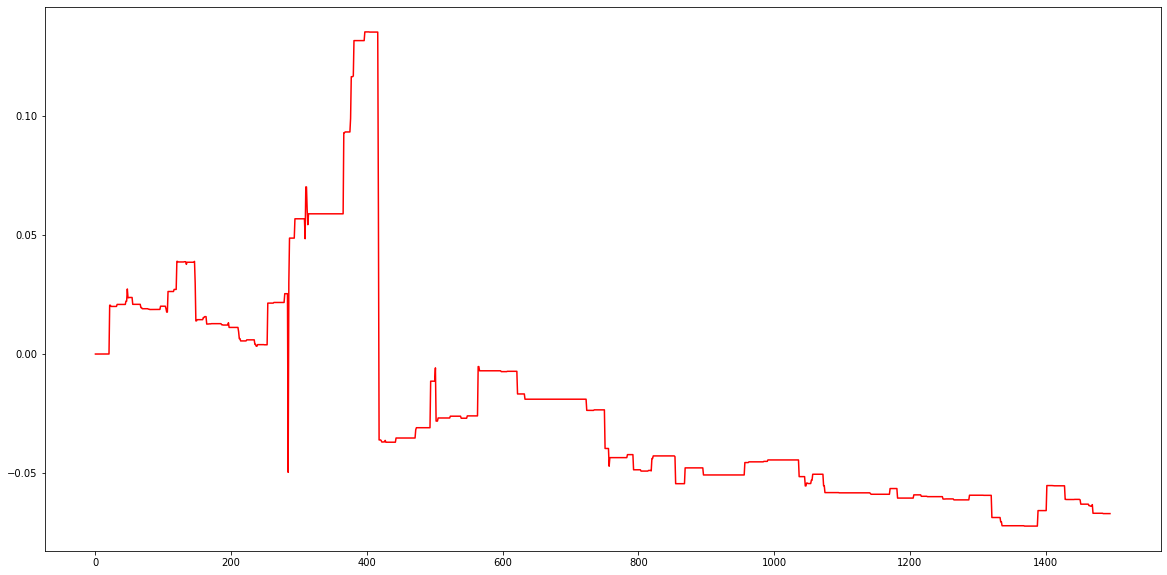

0.00018125491315340328
0.00018125491315340328
0.00018125491315340328
0.00018125491315340328
0.00018125491315340328
iter 90. reward: 29.900031
day 1517: buy 37 units at price 191.474043, total balance 99808.525957
day 1518, sell 37 units at price 184.814076, total balance 99993.340033,
day 1532: buy 1 units at price 5.966970, total balance 99987.373063
day 1533, sell 1 units at price 5.459973, total balance 99992.833036,
day 1541: buy 10 units at price 60.749696, total balance 99932.083340
day 1542, sell 10 units at price 62.849686, total balance 99994.933025,
day 1554: buy 11 units at price 62.617187, total balance 99932.315838
day 1555, sell 11 units at price 64.283679, total balance 99996.599517,
day 1556: buy 17 units at price 100.698997, total balance 99895.900520
day 1557: buy 42 units at price 261.448693, total balance 99634.451828
day 1558, sell 59 units at price 362.848186, total balance 99997.300013,
day 1559: buy 1 units at price 6.046470, total balance 99991.253544
day 1560,

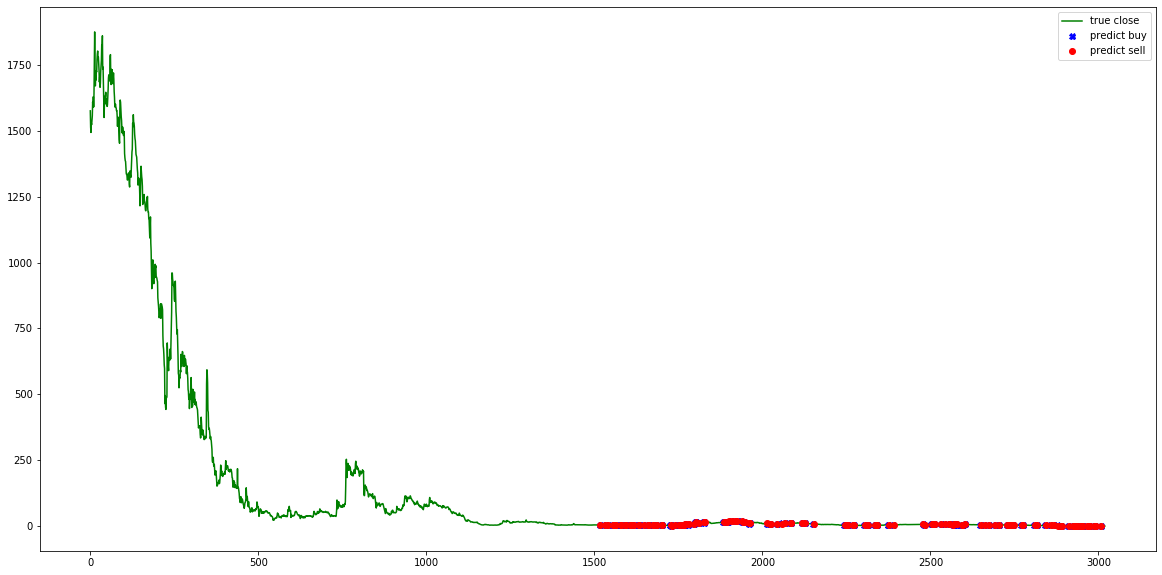

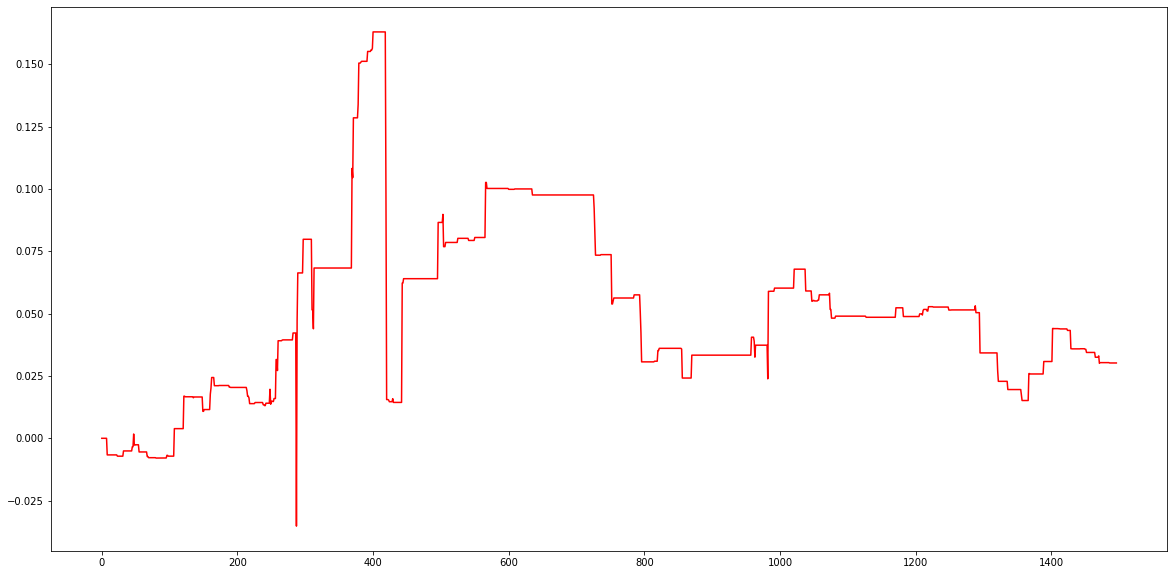

0.00018125491315340328
0.00018125491315340328
0.00018125491315340328
0.00018125491315340328
0.00018125491315340328
iter 95. reward: 23.074591
day 1517: buy 37 units at price 191.474043, total balance 99808.525957
day 1518, sell 37 units at price 184.814076, total balance 99993.340033,
day 1532: buy 1 units at price 5.966970, total balance 99987.373063
day 1534, sell 1 units at price 5.699971, total balance 99993.073035,
day 1541: buy 13 units at price 78.974605, total balance 99914.098430
day 1542, sell 13 units at price 81.704591, total balance 99995.803021,
day 1554: buy 15 units at price 85.387073, total balance 99910.415948
day 1555, sell 15 units at price 87.659562, total balance 99998.075510,
day 1557: buy 46 units at price 286.348568, total balance 99711.726941
day 1558, sell 46 units at price 282.898585, total balance 99994.625527,
day 1559: buy 1 units at price 6.046470, total balance 99988.579057
day 1560, sell 1 units at price 6.149969, total balance 99994.729026,
day 1564: 

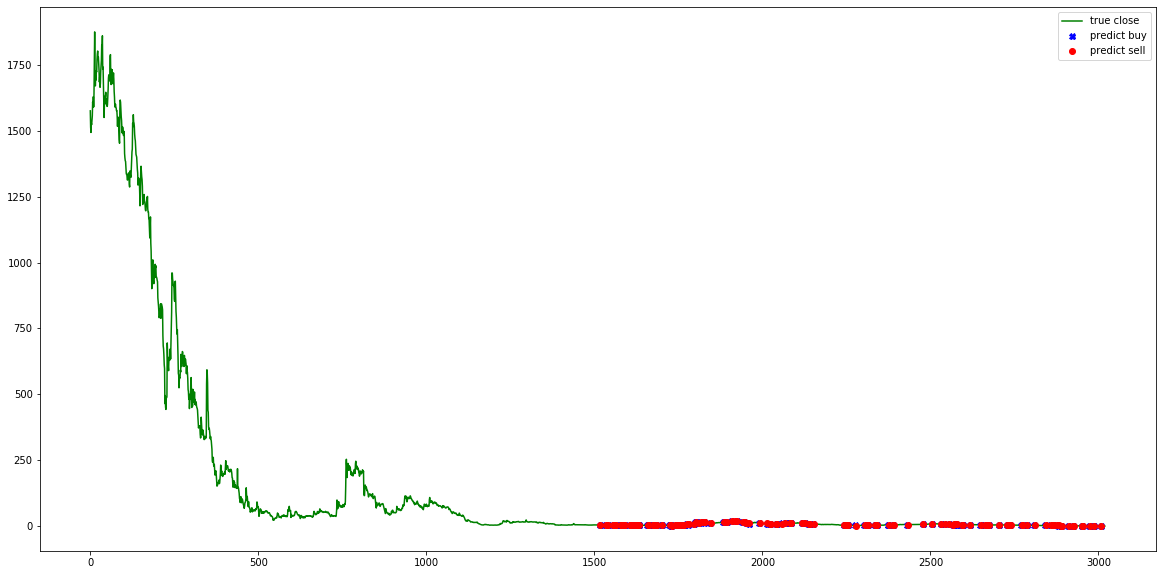

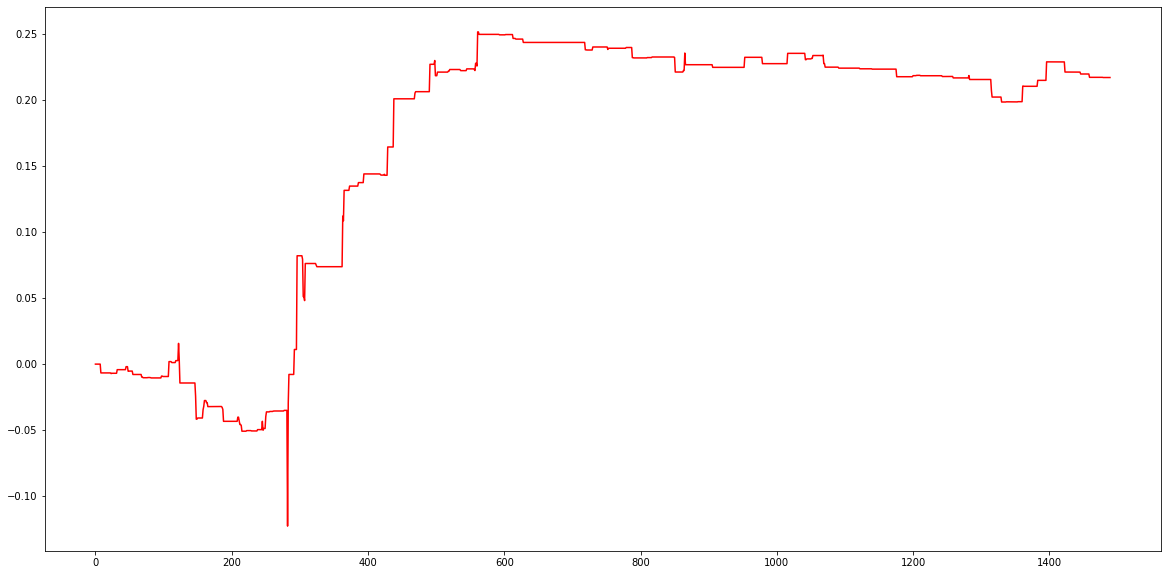

0.00018125491315340328
0.00018125491315340328
0.00018125491315340328
0.00018125491315340328
0.00018125491315340328
iter 100. reward: 18.918620
day 1517: buy 40 units at price 206.998965, total balance 99793.001035
day 1518, sell 40 units at price 199.799001, total balance 99992.800036,
day 1526: buy 1 units at price 4.874976, total balance 99987.925060
day 1527, sell 1 units at price 4.874976, total balance 99992.800036,
day 1532: buy 1 units at price 5.966970, total balance 99986.833066
day 1533, sell 1 units at price 5.459973, total balance 99992.293039,
day 1541: buy 13 units at price 78.974605, total balance 99913.318433
day 1542, sell 13 units at price 81.704591, total balance 99995.023025,
day 1554: buy 8 units at price 45.539772, total balance 99949.483253
day 1555, sell 8 units at price 46.751766, total balance 99996.235019,
day 1559: buy 1 units at price 6.046470, total balance 99990.188549
day 1560, sell 1 units at price 6.149969, total balance 99996.338518,
day 1577: buy 24 

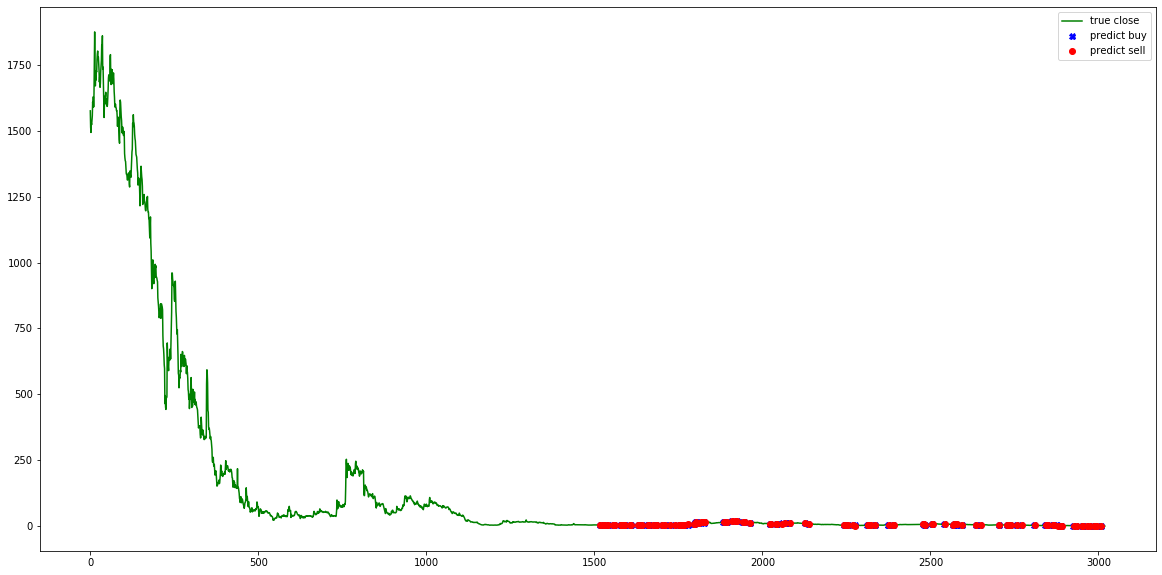

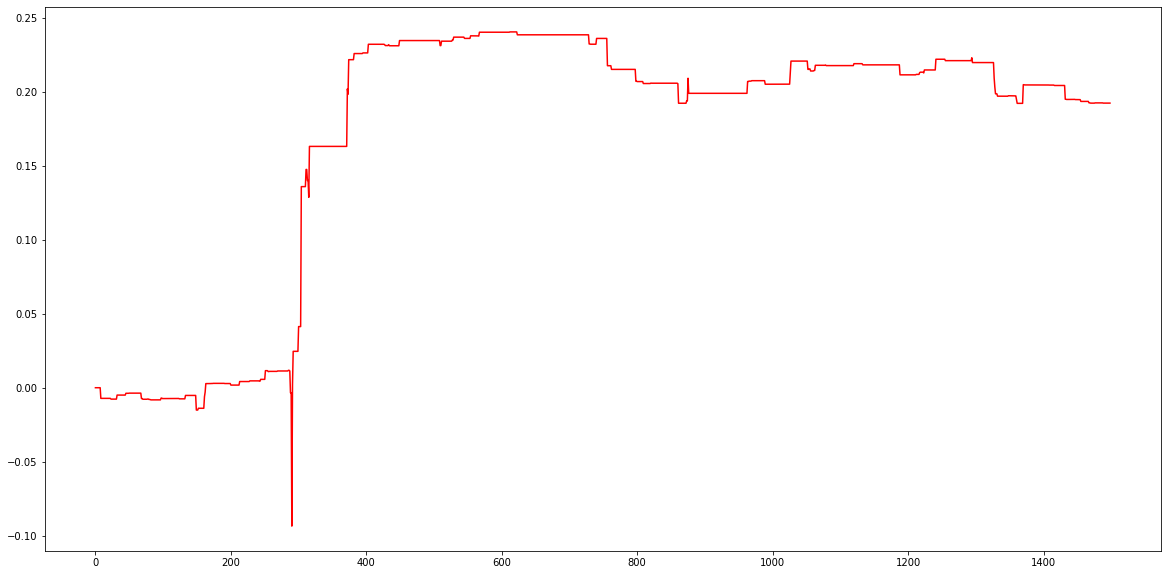

0.00018125491315340328
0.00018125491315340328
0.00018125491315340328
0.00018125491315340328
0.00018125491315340328
iter 105. reward: 18.626821
day 1517: buy 33 units at price 170.774146, total balance 99829.225854
day 1518, sell 33 units at price 164.834176, total balance 99994.060030,
day 1530: buy 73 units at price 394.198029, total balance 99599.862001
day 1532: buy 1 units at price 5.966970, total balance 99593.895031
day 1533, sell 74 units at price 404.037980, total balance 99997.933010,
day 1541: buy 4 units at price 24.299878, total balance 99973.633132
day 1542, sell 4 units at price 25.139874, total balance 99998.773006,
day 1577: buy 35 units at price 172.409138, total balance 99826.363868
day 1579, sell 35 units at price 163.431683, total balance 99989.795551,
day 1586: buy 1 units at price 4.129479, total balance 99985.666072
day 1587, sell 1 units at price 4.274979, total balance 99989.941050,
day 1608: buy 1 units at price 4.950000, total balance 99984.991050
day 1609, s

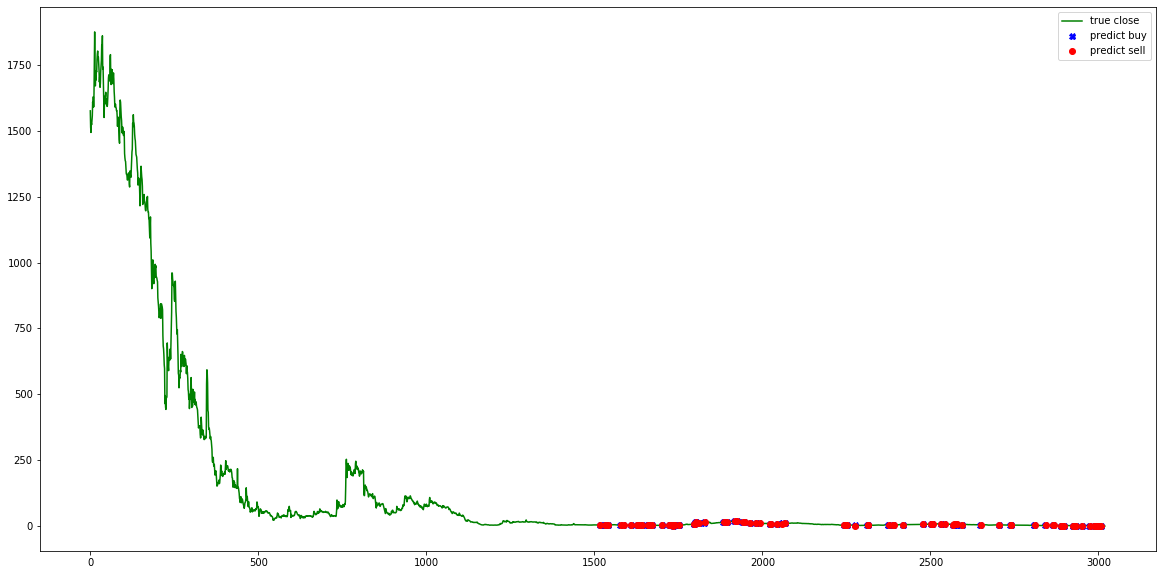

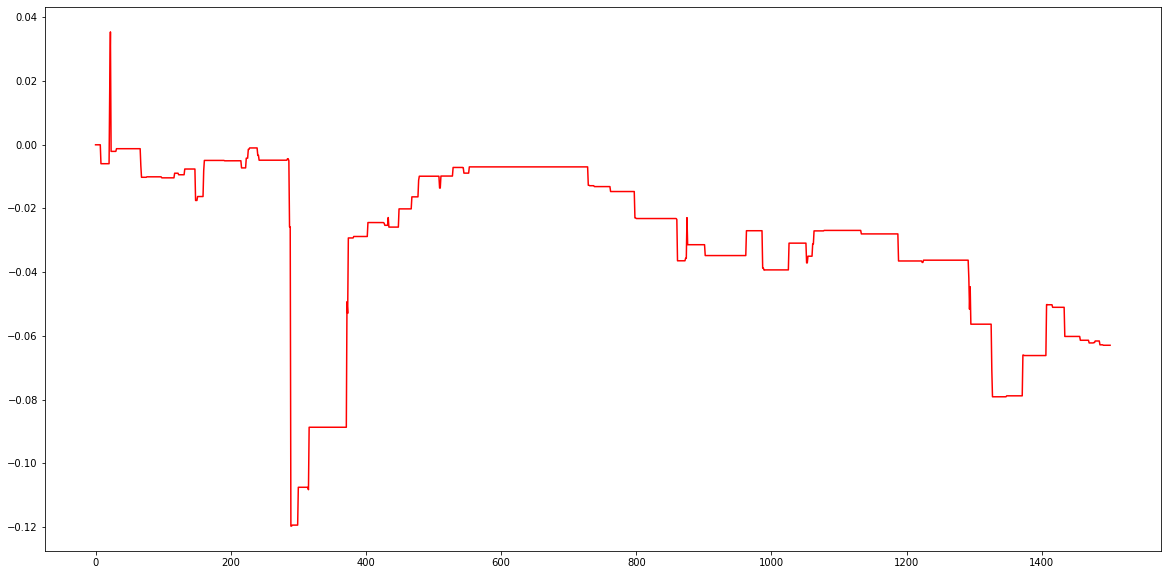

0.00018125491315340328
0.00018125491315340328
0.00018125491315340328
0.00018125491315340328
0.00018125491315340328
iter 110. reward: 17.915108
day 1530: buy 68 units at price 367.198164, total balance 99632.801836
day 1532: buy 1 units at price 5.966970, total balance 99626.834866
day 1533, sell 69 units at price 376.738116, total balance 100003.572982,
day 1541: buy 1 units at price 6.074970, total balance 99997.498013
day 1542, sell 1 units at price 6.284969, total balance 100003.782981,
day 1554: buy 5 units at price 28.462358, total balance 99975.320623
day 1555, sell 5 units at price 29.219854, total balance 100004.540477,
day 1559: buy 10 units at price 60.464698, total balance 99944.075780
day 1561, sell 10 units at price 58.514707, total balance 100002.590487,
day 1577: buy 33 units at price 162.557187, total balance 99840.033300
day 1579, sell 33 units at price 154.092730, total balance 99994.126029,
day 1590: buy 1 units at price 4.199979, total balance 99989.926050
day 1591,

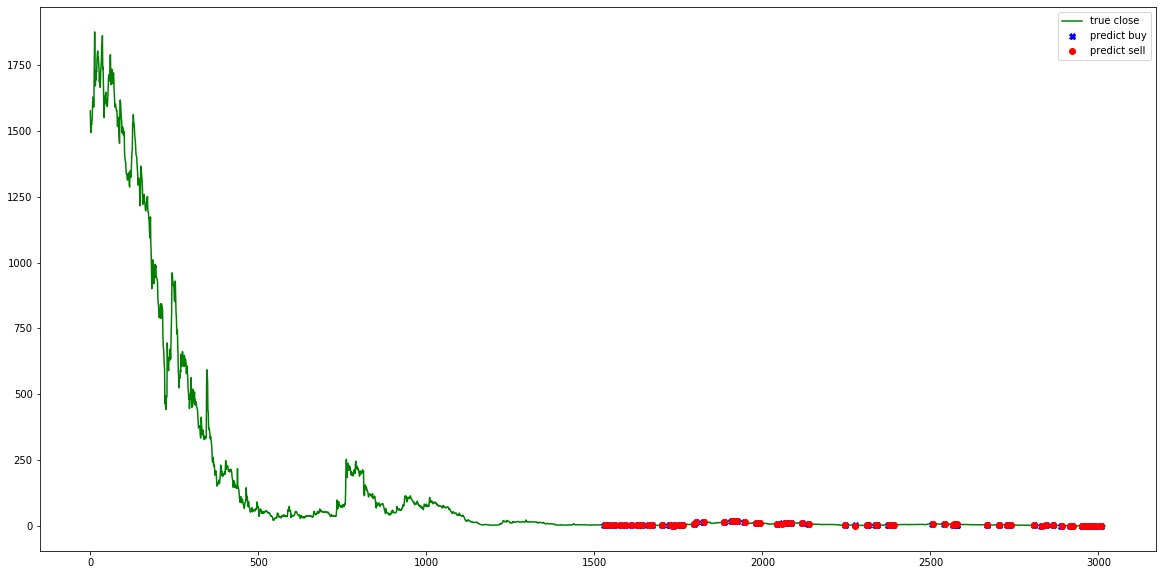

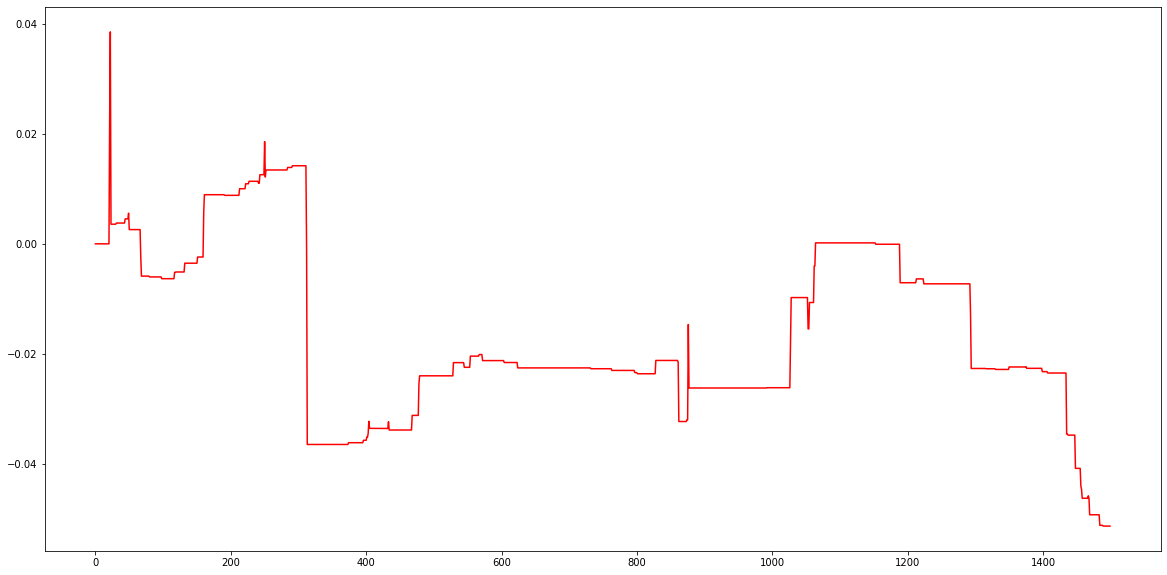

0.00018125491315340328
0.00018125491315340328
0.00018125491315340328
0.00018125491315340328
0.00018125491315340328
iter 115. reward: 7.675980
day 1532: buy 1 units at price 5.966970, total balance 99994.033030
day 1533, sell 1 units at price 5.459973, total balance 99999.493003,
day 1540: buy 2 units at price 12.629937, total balance 99986.863066
day 1541: buy 1 units at price 6.074970, total balance 99980.788096
day 1542, sell 3 units at price 18.854906, total balance 99999.643002,
day 1553: buy 15 units at price 80.999595, total balance 99918.643407
day 1555, sell 15 units at price 87.659562, total balance 100006.302968,
day 1556: buy 1 units at price 5.923470, total balance 100000.379498
day 1557, sell 1 units at price 6.224969, total balance 100006.604467,
day 1559: buy 6 units at price 36.278819, total balance 99970.325648
day 1560, sell 6 units at price 36.899816, total balance 100007.225464,
day 1577: buy 36 units at price 177.335113, total balance 99829.890351
day 1578, sell 36

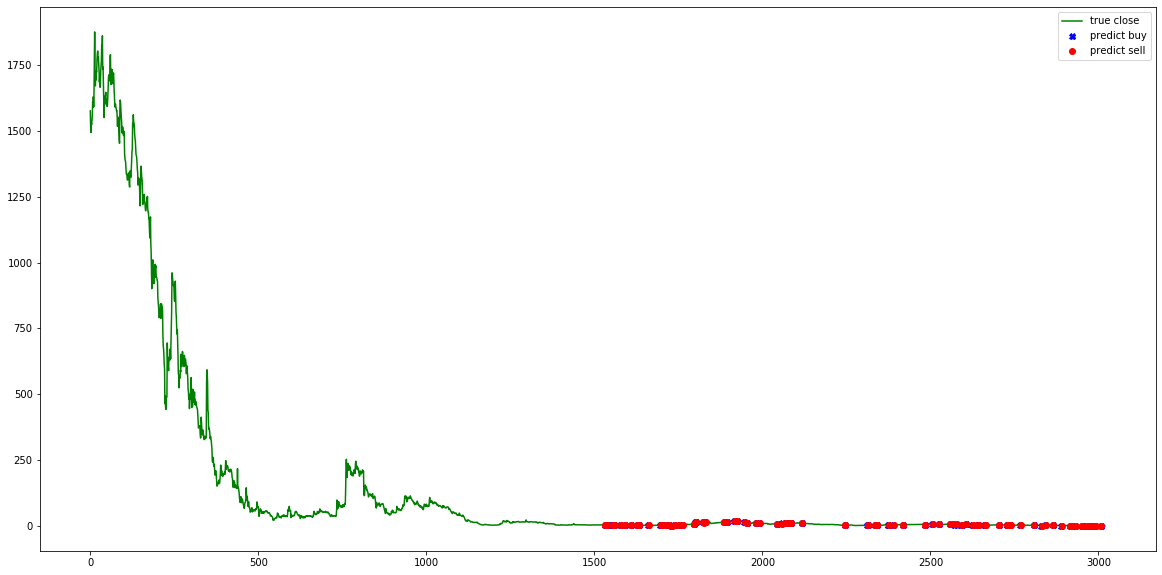

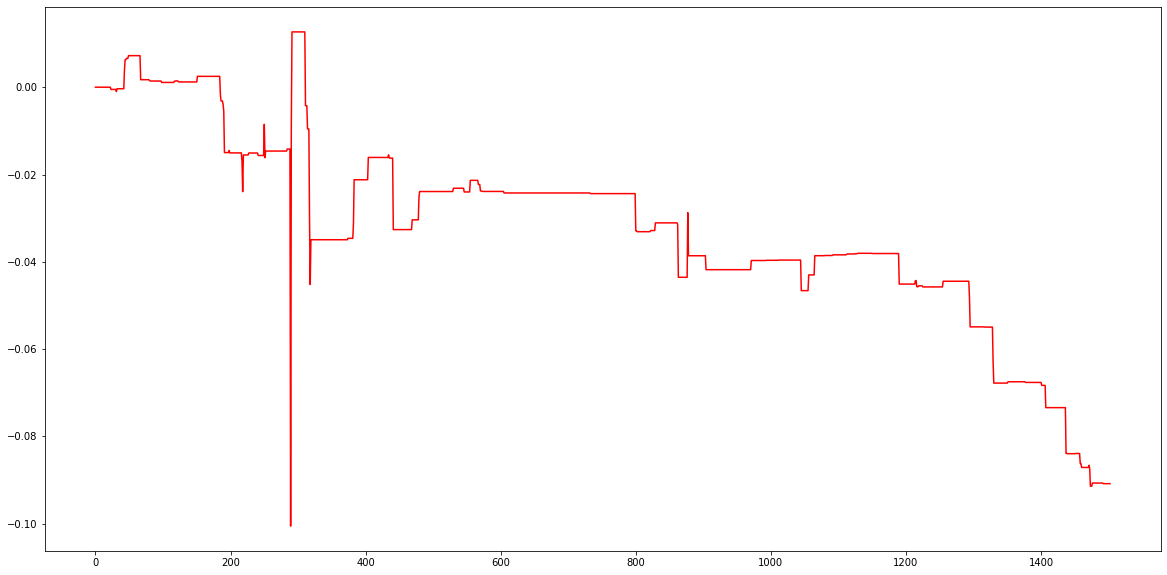

0.00018125491315340328
0.00018125491315340328
0.00018125491315340328
0.00018125491315340328
0.00018125491315340328
iter 120. reward: 12.923735
day 1532: buy 1 units at price 5.966970, total balance 99994.033030
day 1533, sell 1 units at price 5.459973, total balance 99999.493003,
day 1539: buy 1 units at price 5.947470, total balance 99993.545532
day 1540: buy 1 units at price 6.314968, total balance 99987.230564
day 1542, sell 2 units at price 12.569937, total balance 99999.800501,
day 1556: buy 4 units at price 23.693882, total balance 99976.106619
day 1557: buy 53 units at price 329.923350, total balance 99646.183269
day 1558, sell 57 units at price 350.548247, total balance 99996.731516,
day 1559: buy 6 units at price 36.278819, total balance 99960.452698
day 1560, sell 6 units at price 36.899816, total balance 99997.352513,
day 1564: buy 35 units at price 199.551502, total balance 99797.801011
day 1565, sell 35 units at price 194.249029, total balance 99992.050040,
day 1577: buy 3

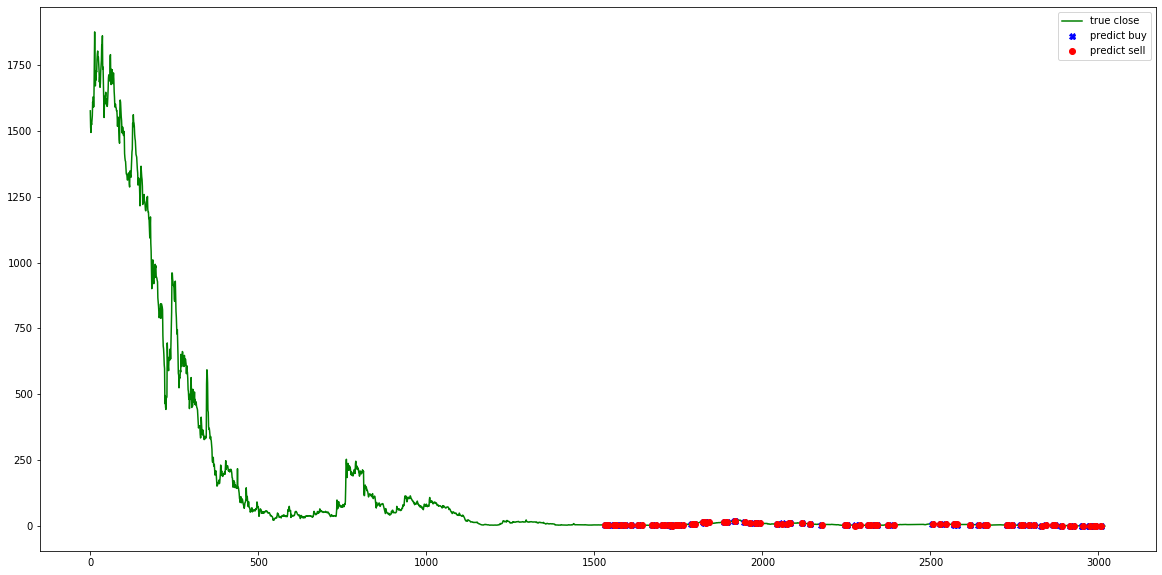

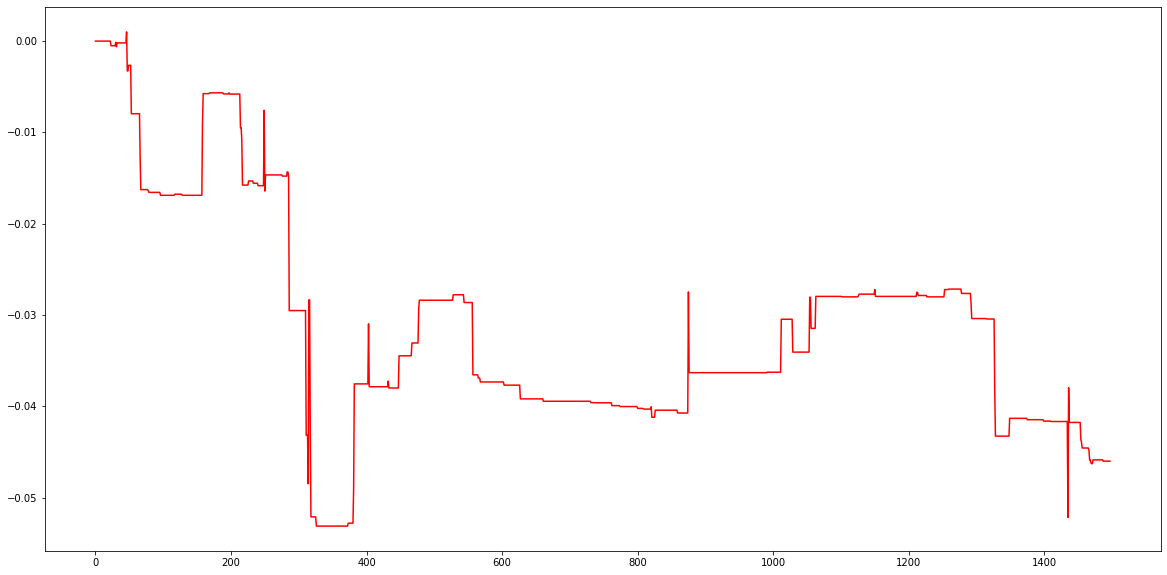

0.00018125491315340328
0.00018125491315340328
0.5005
0.525525
0.525525
iter 125. reward: 25.033990
day 1513: buy 12 units at price 64.709676, total balance 99935.290324
day 1518, sell 12 units at price 59.939700, total balance 99995.230024,
day 1519: buy 1 units at price 4.949975, total balance 99990.280049
day 1520, sell 1 units at price 4.964975, total balance 99995.245024,
day 1528: buy 28 units at price 137.129314, total balance 99858.115709
day 1529, sell 28 units at price 140.069300, total balance 99998.185009,
day 1532: buy 1 units at price 5.966970, total balance 99992.218039
day 1533, sell 1 units at price 5.459973, total balance 99997.678012,
day 1539: buy 1 units at price 5.947470, total balance 99991.730541
day 1540: buy 1 units at price 6.314968, total balance 99985.415573
day 1542, sell 2 units at price 12.569937, total balance 99997.985510,
day 1553: buy 4 units at price 21.599892, total balance 99976.385618
day 1555, sell 4 units at price 23.375883, total balance 99999.

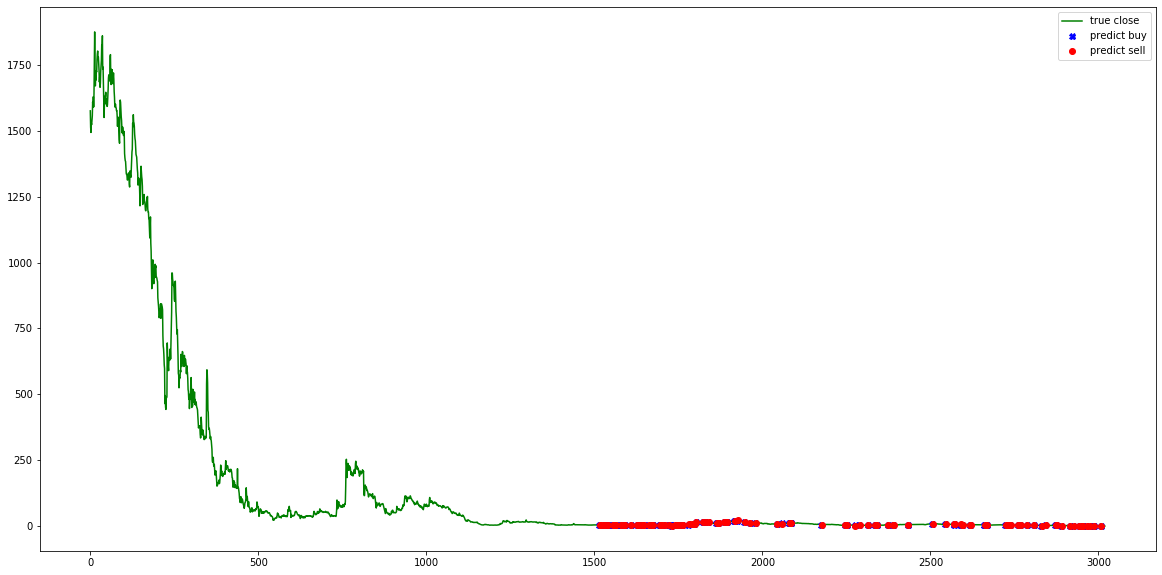

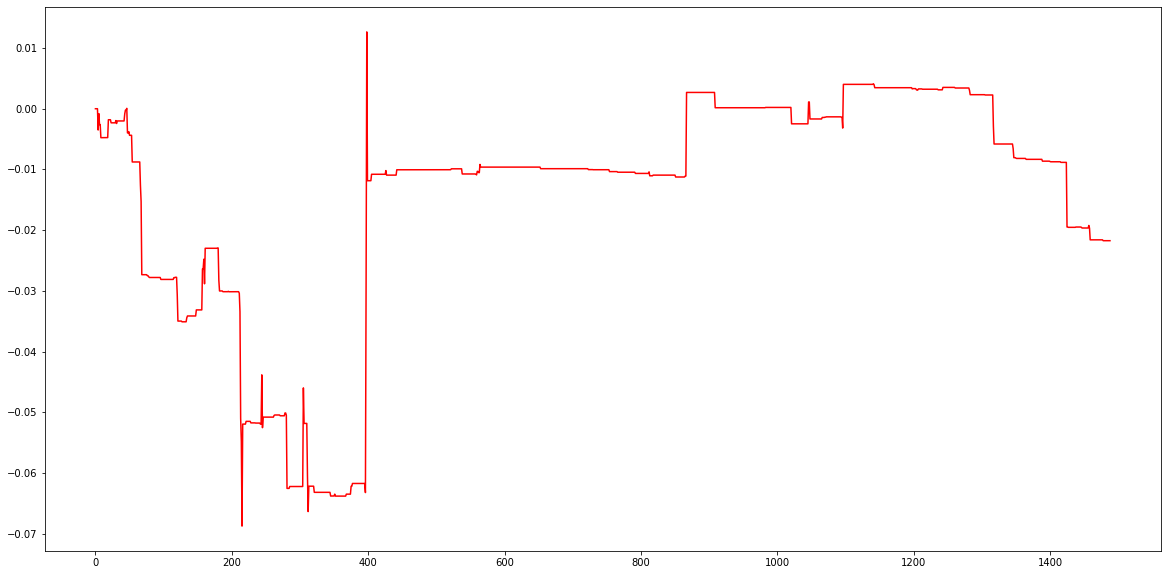

0.525525
0.55180125
0.5793913125000001
0.6083608781250002
0.6083608781250002
iter 130. reward: 23.648211
day 1513: buy 19 units at price 102.456988, total balance 99897.543012
day 1518, sell 19 units at price 94.904525, total balance 99992.447538,
day 1519: buy 1 units at price 4.949975, total balance 99987.497563
day 1520: buy 29 units at price 143.984280, total balance 99843.513282
day 1521, sell 30 units at price 151.649242, total balance 99995.162524,
day 1528: buy 31 units at price 151.821741, total balance 99843.340783
day 1529, sell 31 units at price 155.076725, total balance 99998.417508,
day 1532: buy 1 units at price 5.966970, total balance 99992.450538
day 1533, sell 1 units at price 5.459973, total balance 99997.910510,
day 1553: buy 1 units at price 5.399973, total balance 99992.510537
day 1555, sell 1 units at price 5.843971, total balance 99998.354508,
day 1556: buy 1 units at price 5.923470, total balance 99992.431038
day 1557: buy 60 units at price 373.498132, total ba

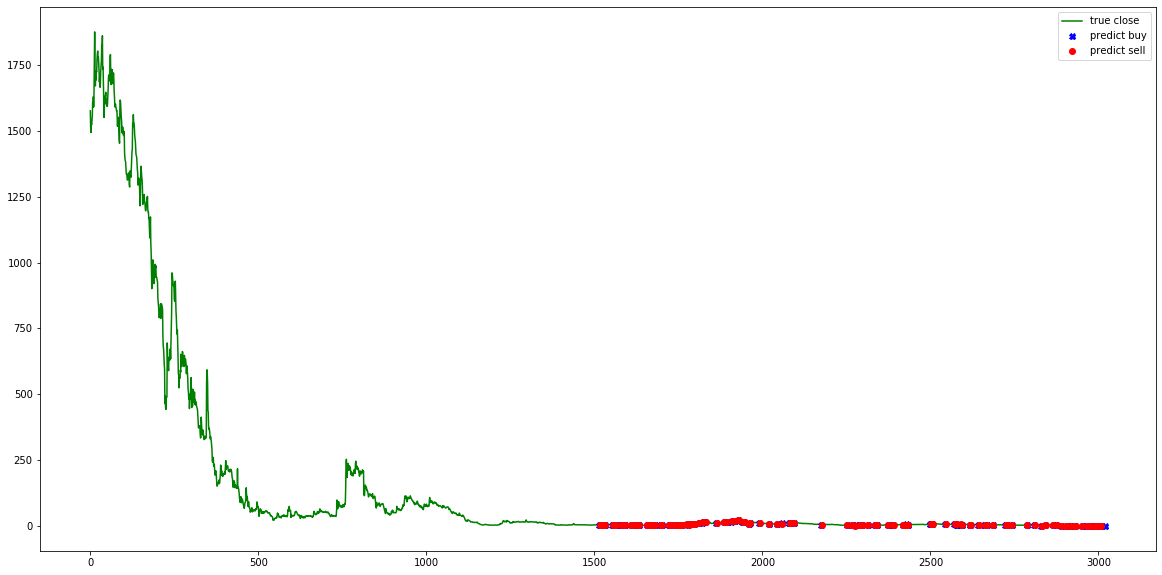

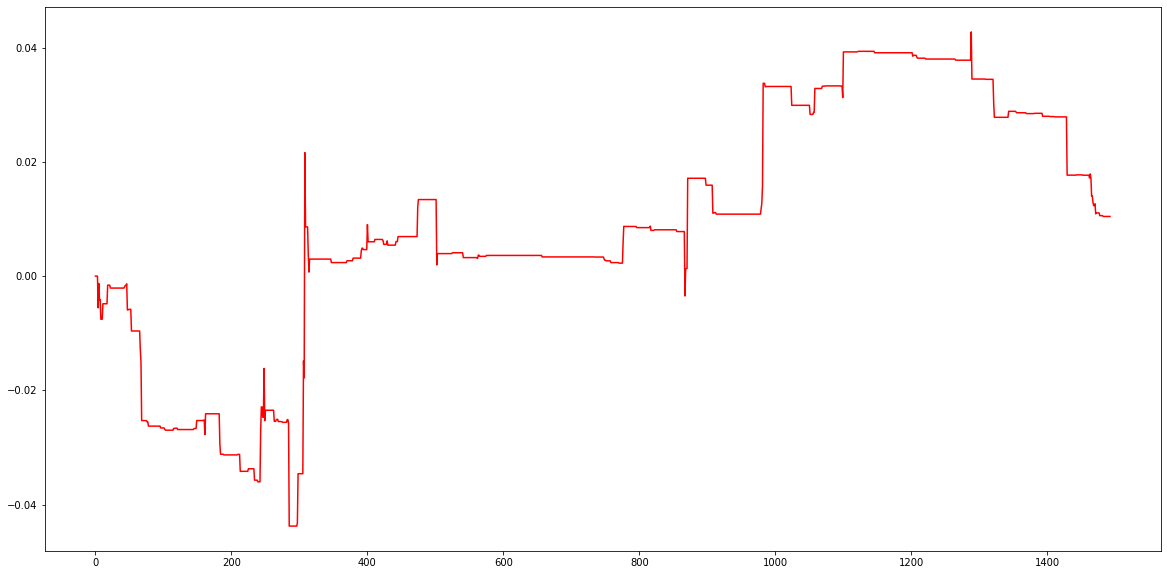

0.6083608781250002
0.6083608781250002
0.6083608781250002
0.6083608781250002
0.6083608781250002
iter 135. reward: 20.208801
day 1515: buy 1 units at price 5.324973, total balance 99994.675027
day 1518, sell 1 units at price 4.994975, total balance 99999.670002,
day 1520: buy 28 units at price 139.019305, total balance 99860.650697
day 1521, sell 28 units at price 141.539292, total balance 100002.189989,
day 1522: buy 1 units at price 5.024975, total balance 99997.165014
day 1525, sell 1 units at price 4.961975, total balance 100002.126989,
day 1532: buy 1 units at price 5.966970, total balance 99996.160019
day 1533, sell 1 units at price 5.459973, total balance 100001.619992,
day 1540: buy 1 units at price 6.314968, total balance 99995.305023
day 1542, sell 1 units at price 6.284969, total balance 100001.589992,
day 1553: buy 1 units at price 5.399973, total balance 99996.190019
day 1555, sell 1 units at price 5.843971, total balance 100002.033990,
day 1556: buy 1 units at price 5.92347

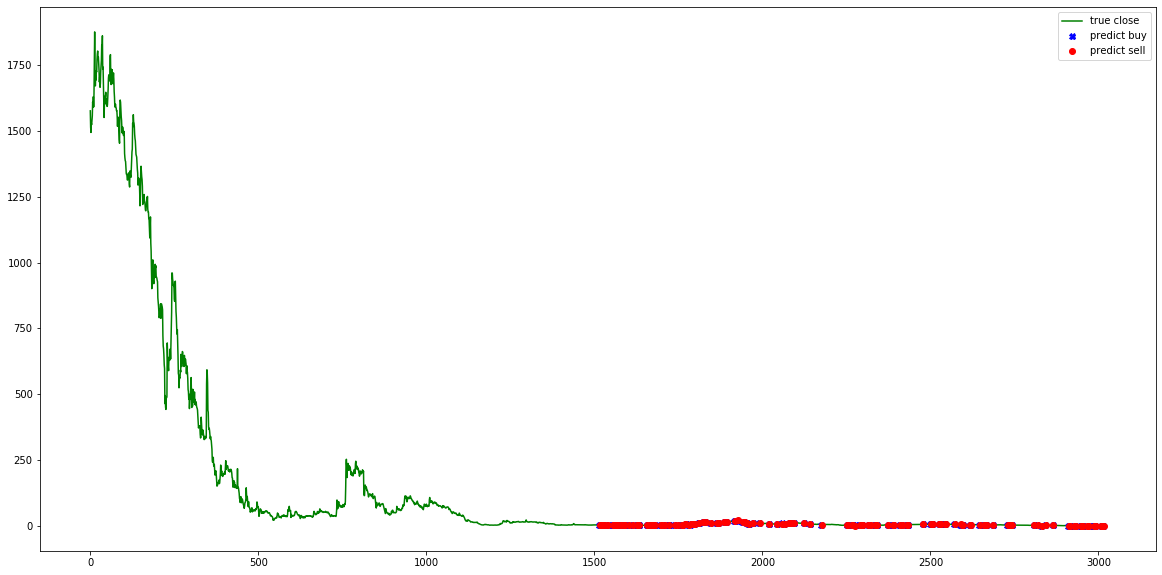

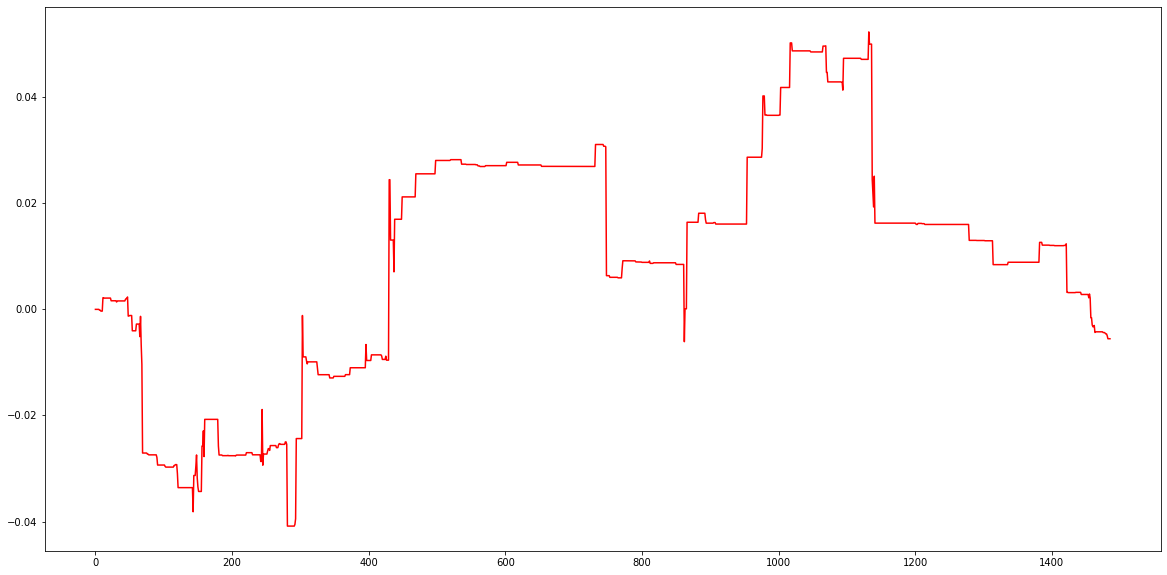

0.6083608781250002
0.6083608781250002
0.6083608781250002
0.6083608781250002
0.6083608781250002
iter 140. reward: 35.536831
day 1519: buy 1 units at price 4.949975, total balance 99995.050025
day 1521, sell 1 units at price 5.054975, total balance 100000.104999,
day 1528: buy 19 units at price 93.052035, total balance 99907.052965
day 1529, sell 19 units at price 95.047025, total balance 100002.099989,
day 1532: buy 1 units at price 5.966970, total balance 99996.133019
day 1533, sell 1 units at price 5.459973, total balance 100001.592992,
day 1540: buy 10 units at price 63.149684, total balance 99938.443308
day 1542, sell 10 units at price 62.849686, total balance 100001.292994,
day 1555: buy 24 units at price 140.255299, total balance 99861.037695
day 1556: buy 5 units at price 29.617352, total balance 99831.420343
day 1557: buy 43 units at price 267.673662, total balance 99563.746681
day 1558, sell 72 units at price 442.797786, total balance 100006.544467,
day 1559: buy 1 units at pri

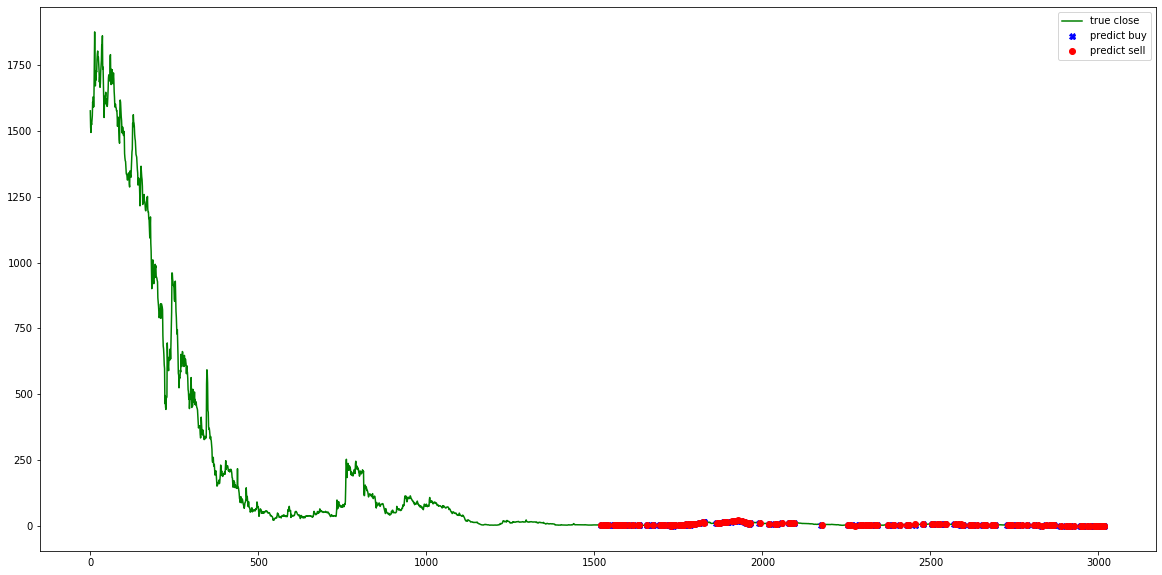

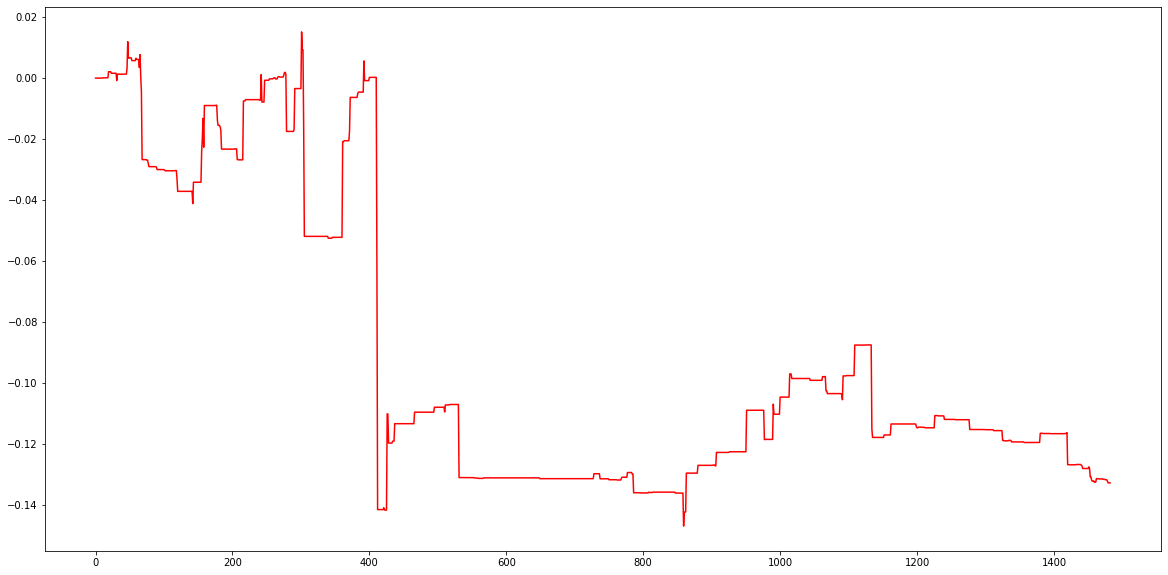

0.6083608781250002
0.6083608781250002
0.6083608781250002
0.6083608781250002
0.6083608781250002
iter 145. reward: 36.430438
day 1519: buy 1 units at price 4.949975, total balance 99995.050025
day 1520: buy 32 units at price 158.879206, total balance 99836.170819
day 1521, sell 33 units at price 166.814166, total balance 100002.984985,
day 1528: buy 25 units at price 122.436888, total balance 99880.548097
day 1532: buy 1 units at price 5.966970, total balance 99874.581127
day 1533, sell 26 units at price 141.959290, total balance 100016.540417,
day 1553: buy 2 units at price 10.799946, total balance 100005.740471
day 1555: buy 19 units at price 111.035445, total balance 99894.705026
day 1556: buy 1 units at price 5.923470, total balance 99888.781556
day 1557: buy 50 units at price 311.248444, total balance 99577.533112
day 1558, sell 72 units at price 442.797786, total balance 100020.330898,
day 1559: buy 1 units at price 6.046470, total balance 100014.284429
day 1560, sell 1 units at pr

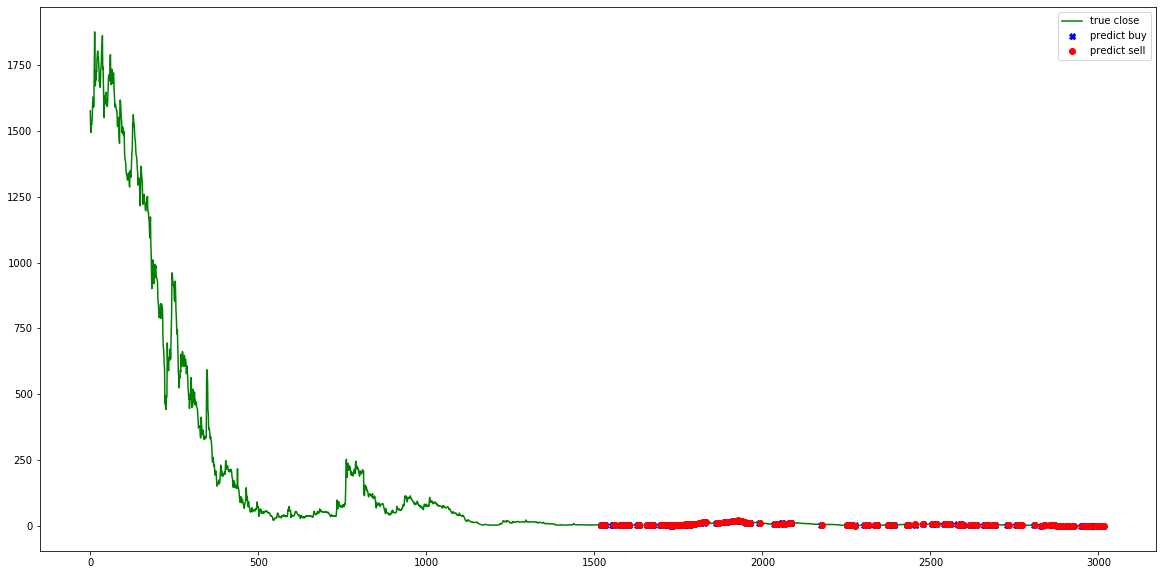

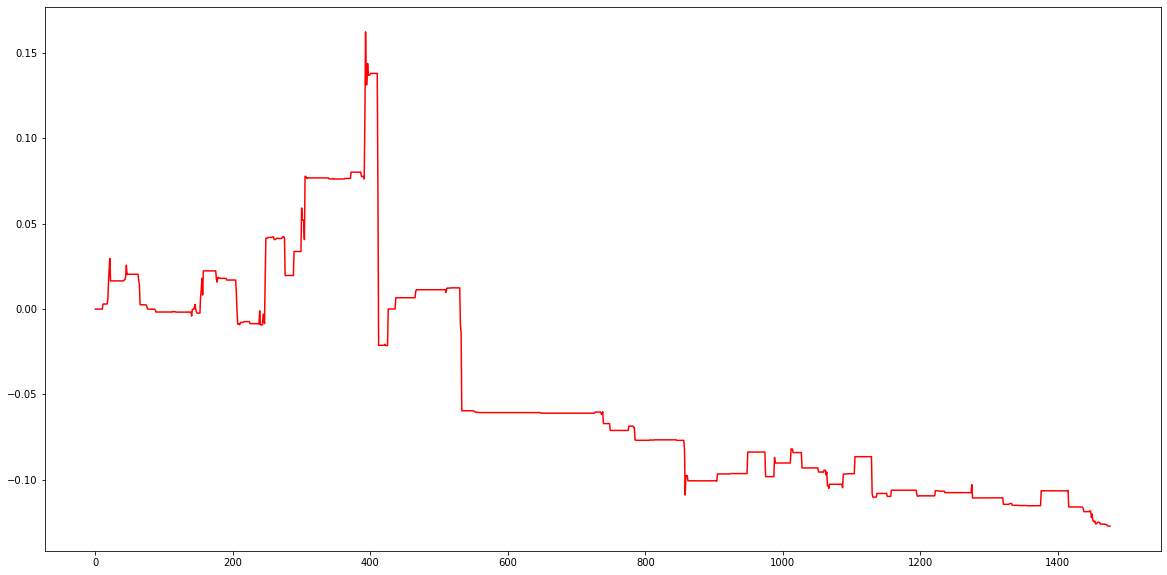

0.6083608781250002
0.6083608781250002
0.6083608781250002
0.6083608781250002
0.6083608781250002
iter 150. reward: 42.386204
day 1519: buy 1 units at price 4.949975, total balance 99995.050025
day 1520: buy 34 units at price 168.809156, total balance 99826.240869
day 1521, sell 35 units at price 176.924115, total balance 100003.164984,
day 1522: buy 1 units at price 5.024975, total balance 99998.140009
day 1524, sell 1 units at price 4.949975, total balance 100003.089985,
day 1530: buy 61 units at price 329.398353, total balance 99673.691632
day 1532: buy 1 units at price 5.966970, total balance 99667.724661
day 1533, sell 62 units at price 338.518307, total balance 100006.242969,
day 1551: buy 1 units at price 5.564972, total balance 100000.677997
day 1552: buy 19 units at price 105.762971, total balance 99894.915025
day 1554, sell 20 units at price 113.849431, total balance 100008.764456,
day 1555: buy 29 units at price 169.475153, total balance 99839.289304
day 1556: buy 7 units at pr

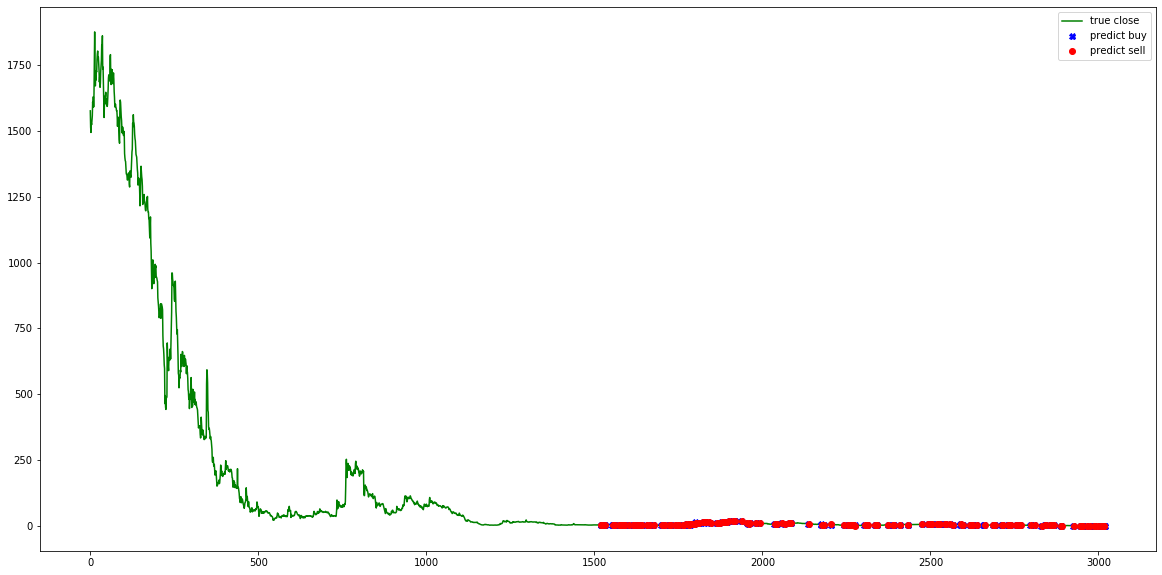

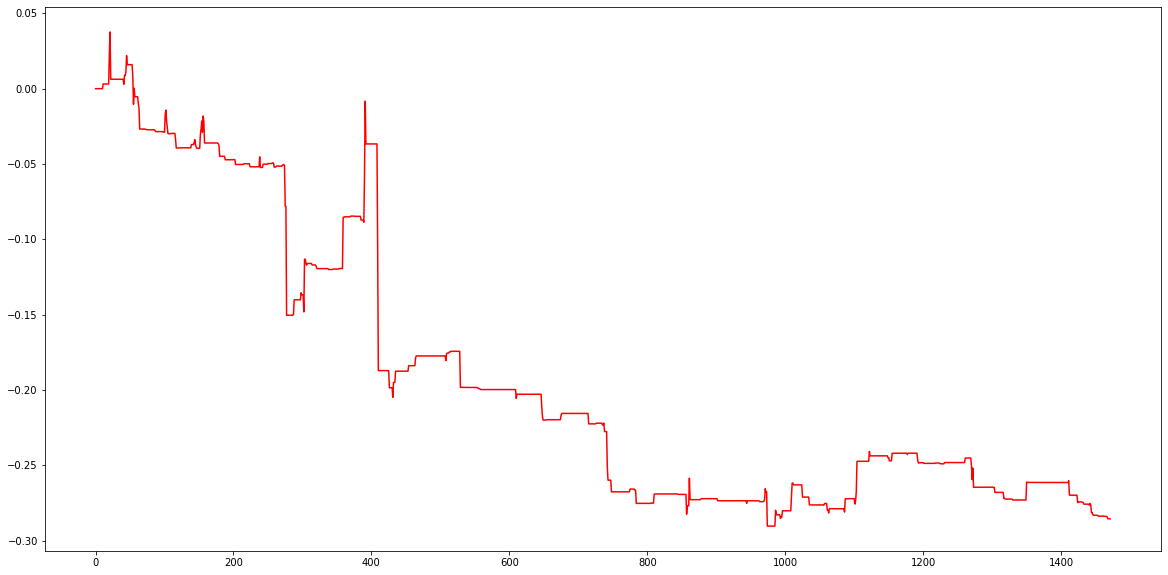

0.6083608781250002
0.6083608781250002
0.6083608781250002
0.6083608781250002
0.6083608781250002
iter 155. reward: 36.132368
day 1519: buy 1 units at price 4.949975, total balance 99995.050025
day 1520: buy 23 units at price 114.194429, total balance 99880.855596
day 1521, sell 24 units at price 121.319393, total balance 100002.174989,
day 1522: buy 1 units at price 5.024975, total balance 99997.150014
day 1524, sell 1 units at price 4.949975, total balance 100002.099989,
day 1530: buy 71 units at price 383.398083, total balance 99618.701907
day 1532: buy 1 units at price 5.966970, total balance 99612.734936
day 1533, sell 72 units at price 393.118034, total balance 100005.852971,
day 1540: buy 12 units at price 75.779621, total balance 99930.073350
day 1542, sell 12 units at price 75.419623, total balance 100005.492973,
day 1551: buy 1 units at price 5.564972, total balance 99999.928000
day 1552: buy 4 units at price 22.265889, total balance 99977.662112
day 1553: buy 15 units at price 

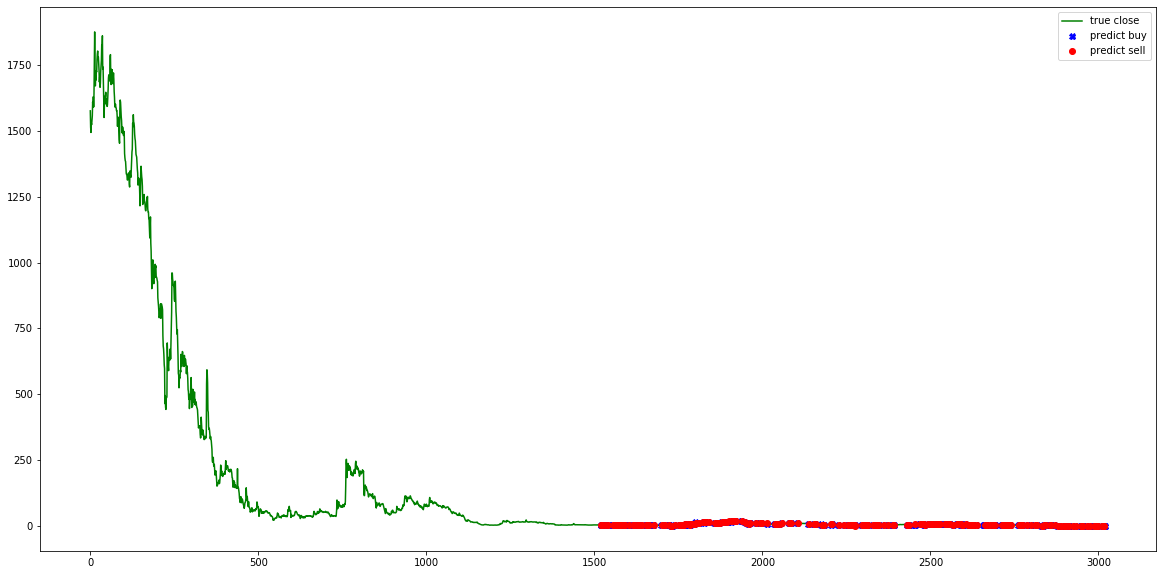

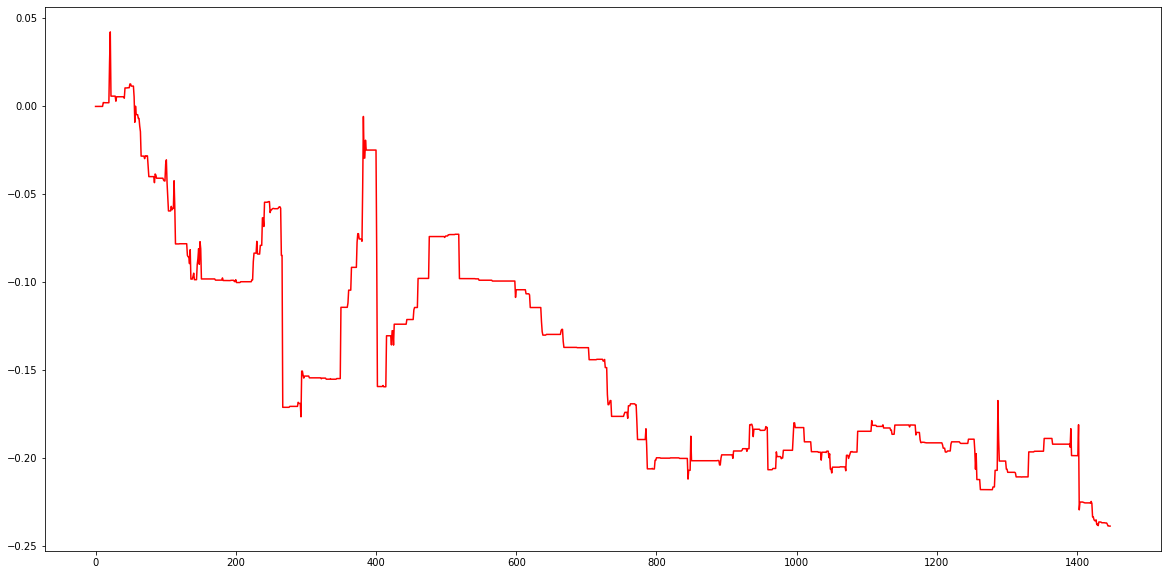

0.5779428342187501
0.5779428342187501
0.5779428342187501
0.5779428342187501
0.5779428342187501
iter 160. reward: 55.822805
day 1511: buy 40 units at price 218.998905, total balance 99781.001095
day 1512, sell 40 units at price 210.598947, total balance 99991.600042,
day 1517: buy 43 units at price 222.523887, total balance 99769.076155
day 1518, sell 43 units at price 214.783926, total balance 99983.860081,
day 1519: buy 1 units at price 4.949975, total balance 99978.910105
day 1520, sell 1 units at price 4.964975, total balance 99983.875081,
day 1522: buy 1 units at price 5.024975, total balance 99978.850106
day 1524, sell 1 units at price 4.949975, total balance 99983.800081,
day 1530: buy 77 units at price 415.797921, total balance 99568.002160
day 1531: buy 1 units at price 5.729971, total balance 99562.272189
day 1532: buy 1 units at price 5.966970, total balance 99556.305218
day 1533, sell 79 units at price 431.337843, total balance 99987.643062,
day 1540: buy 9 units at price 56

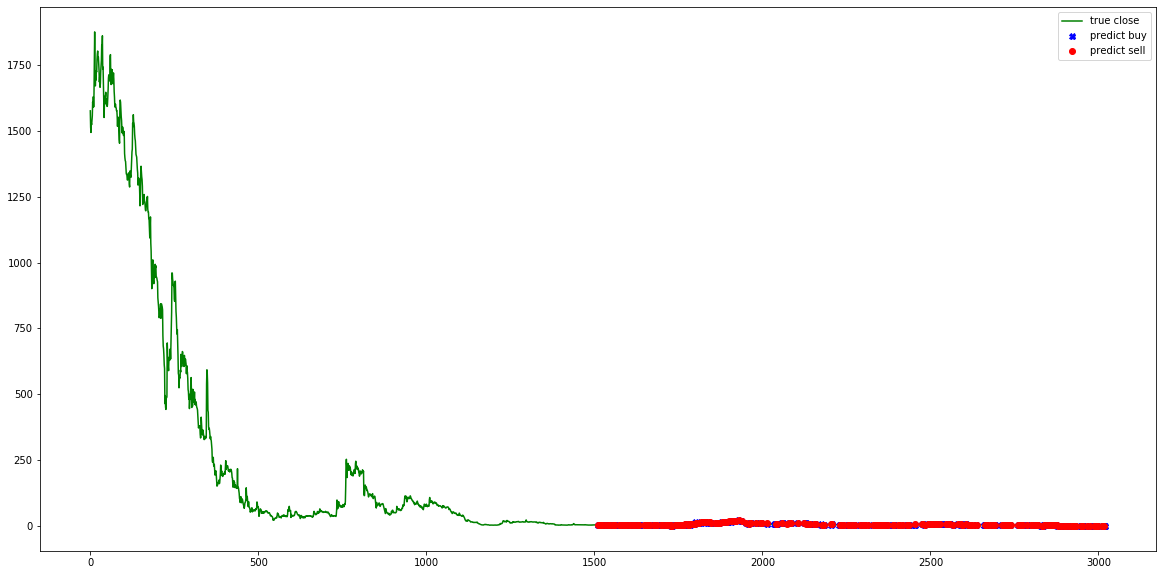

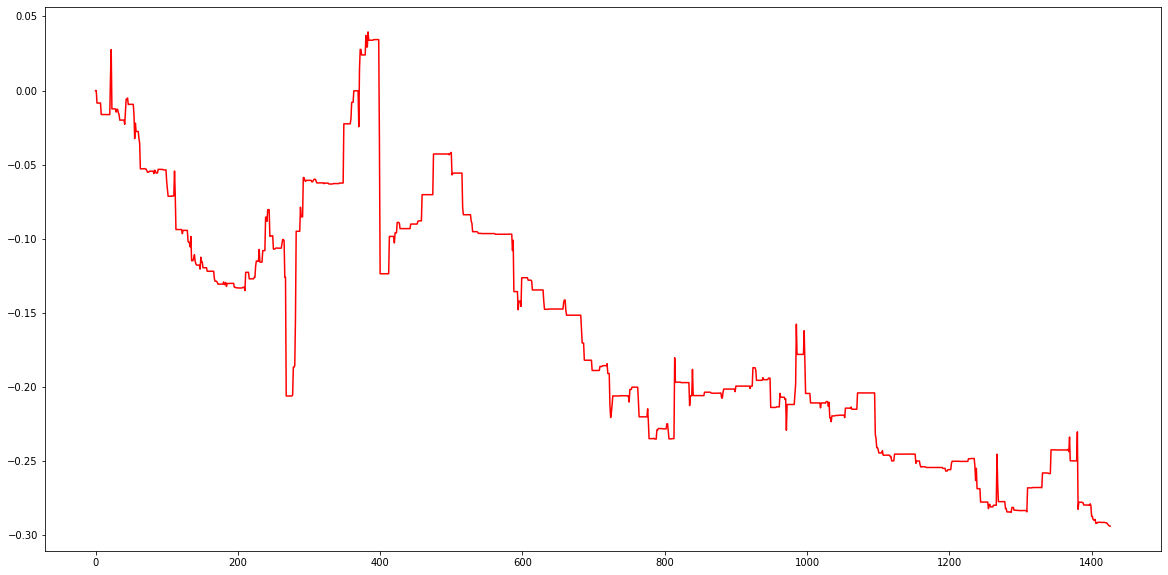

0.5779428342187501
0.5779428342187501
0.5490456925078127
0.5490456925078127
0.521593407882422
iter 165. reward: 88.743846
day 1511: buy 43 units at price 235.423823, total balance 99764.576177
day 1512, sell 43 units at price 226.393868, total balance 99990.970045,
day 1517: buy 42 units at price 217.348913, total balance 99773.621132
day 1518, sell 42 units at price 209.788951, total balance 99983.410083,
day 1519: buy 1 units at price 4.949975, total balance 99978.460108
day 1520, sell 1 units at price 4.964975, total balance 99983.425083,
day 1522: buy 1 units at price 5.024975, total balance 99978.400108
day 1524, sell 1 units at price 4.949975, total balance 99983.350083,
day 1528: buy 41 units at price 200.796496, total balance 99782.553587
day 1530: buy 82 units at price 442.797786, total balance 99339.755801
day 1531: buy 2 units at price 11.459943, total balance 99328.295859
day 1532: buy 1 units at price 5.966970, total balance 99322.328888
day 1533, sell 126 units at price 6

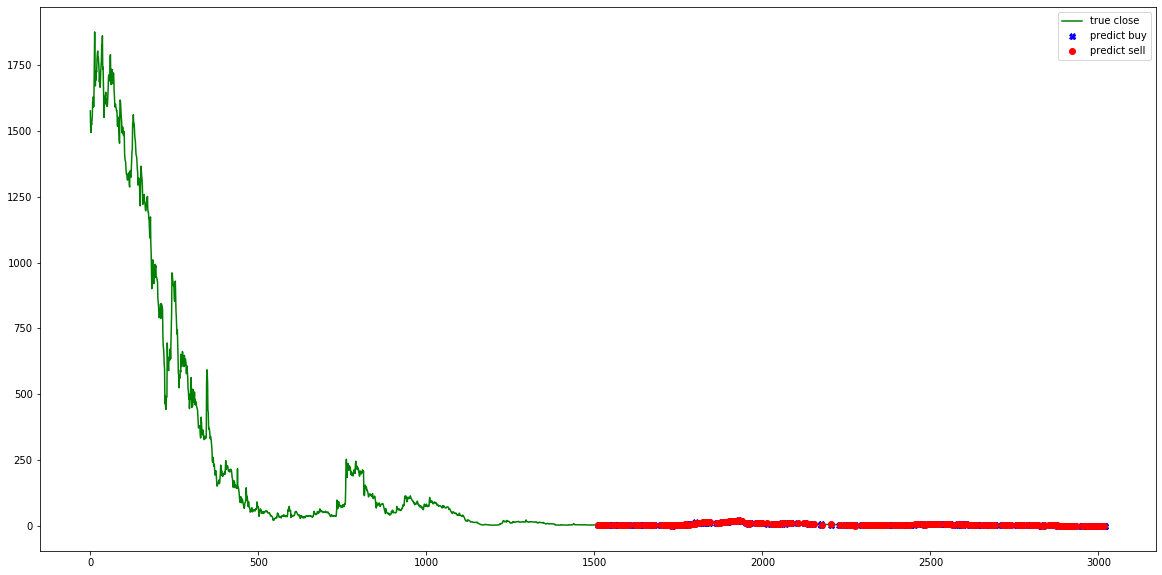

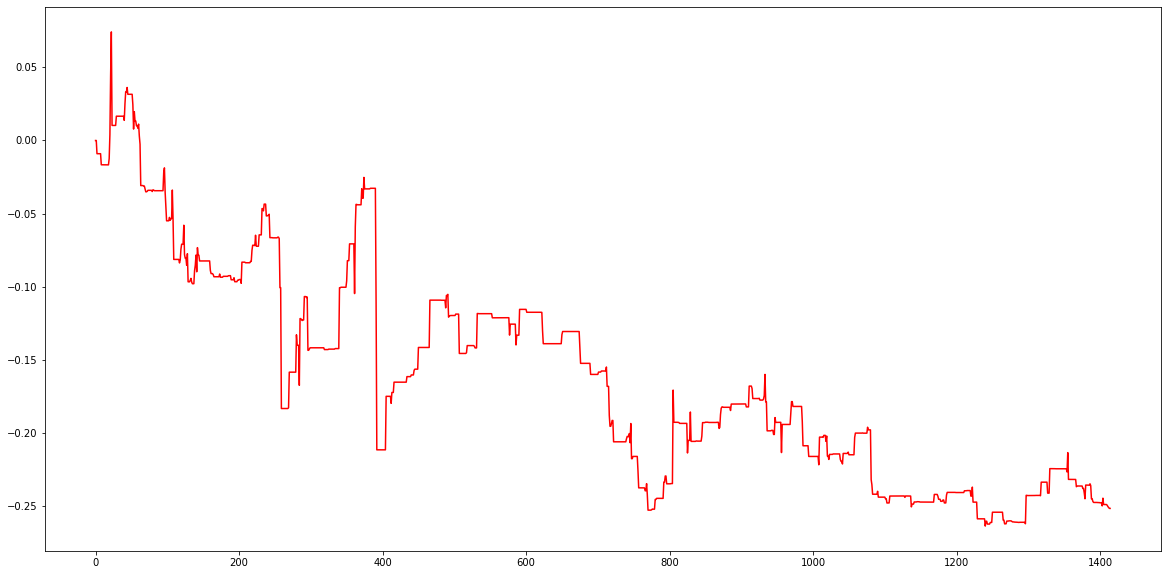

0.521593407882422
0.4955137374883009
0.4955137374883009
0.4955137374883009
0.4955137374883009
iter 170. reward: 74.333628
day 1511: buy 51 units at price 279.223604, total balance 99720.776396
day 1512, sell 51 units at price 268.513657, total balance 99989.290054,
day 1517: buy 52 units at price 269.098655, total balance 99720.191399
day 1518, sell 52 units at price 259.738701, total balance 99979.930100,
day 1520: buy 43 units at price 213.493933, total balance 99766.436168
day 1521, sell 43 units at price 217.363913, total balance 99983.800081,
day 1528: buy 52 units at price 254.668727, total balance 99729.131354
day 1530: buy 81 units at price 437.397813, total balance 99291.733541
day 1532: buy 1 units at price 5.966970, total balance 99285.766571
day 1533, sell 134 units at price 731.636342, total balance 100017.402913,
day 1540: buy 12 units at price 75.779621, total balance 99941.623292
day 1542, sell 12 units at price 75.419623, total balance 100017.042915,
day 1552: buy 40 u

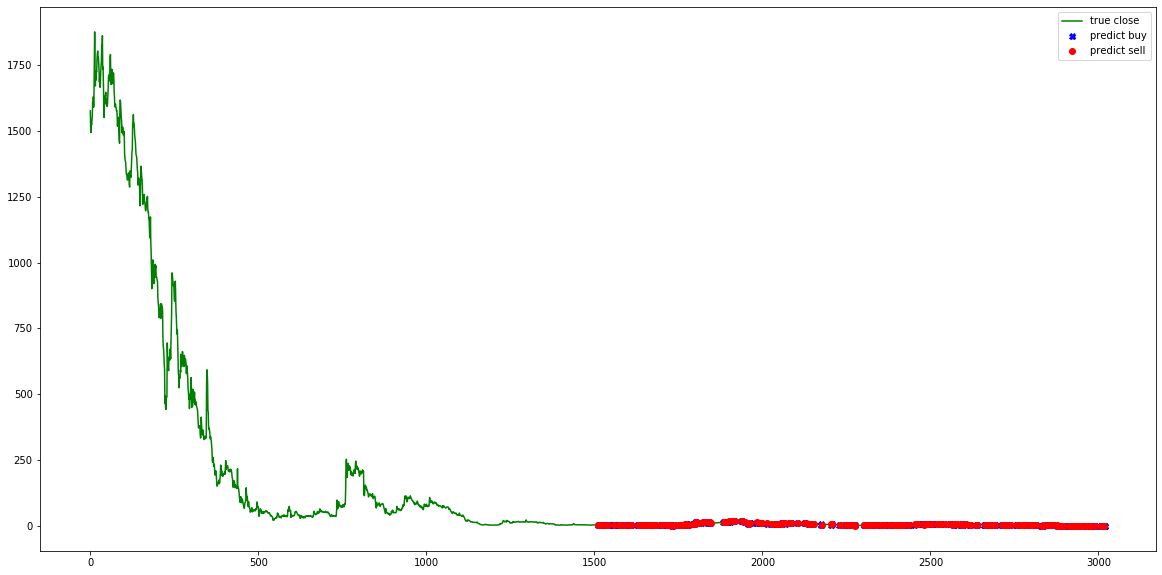

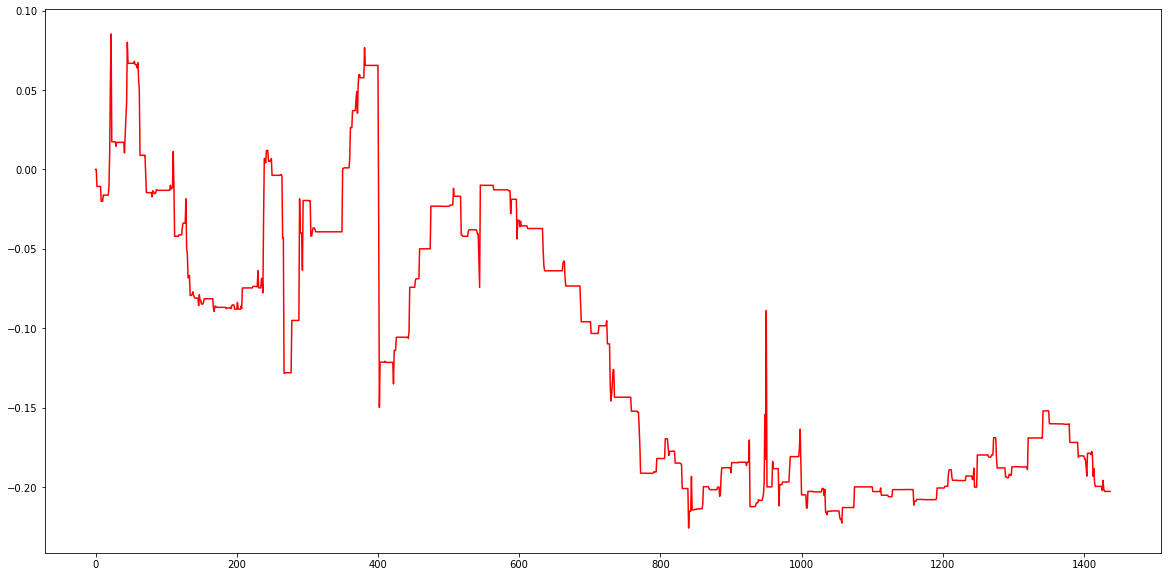

0.4955137374883009
0.4955137374883009
0.47073805061388585
0.44720114808319156
0.44720114808319156
iter 175. reward: 126.202408
day 1511: buy 41 units at price 224.473878, total balance 99775.526122
day 1512, sell 41 units at price 215.863921, total balance 99991.390043,
day 1517: buy 52 units at price 269.098655, total balance 99722.291389
day 1518, sell 52 units at price 259.738701, total balance 99982.030090,
day 1530: buy 82 units at price 442.797786, total balance 99539.232304
day 1531: buy 11 units at price 63.029685, total balance 99476.202619
day 1532: buy 1 units at price 5.966970, total balance 99470.235649
day 1533, sell 94 units at price 513.237434, total balance 99983.473083,
day 1537: buy 1 units at price 6.269969, total balance 99977.203114
day 1538, sell 1 units at price 6.016470, total balance 99983.219584,
day 1540: buy 21 units at price 132.614337, total balance 99850.605247
day 1542, sell 21 units at price 131.984340, total balance 99982.589587,
day 1550: buy 36 unit

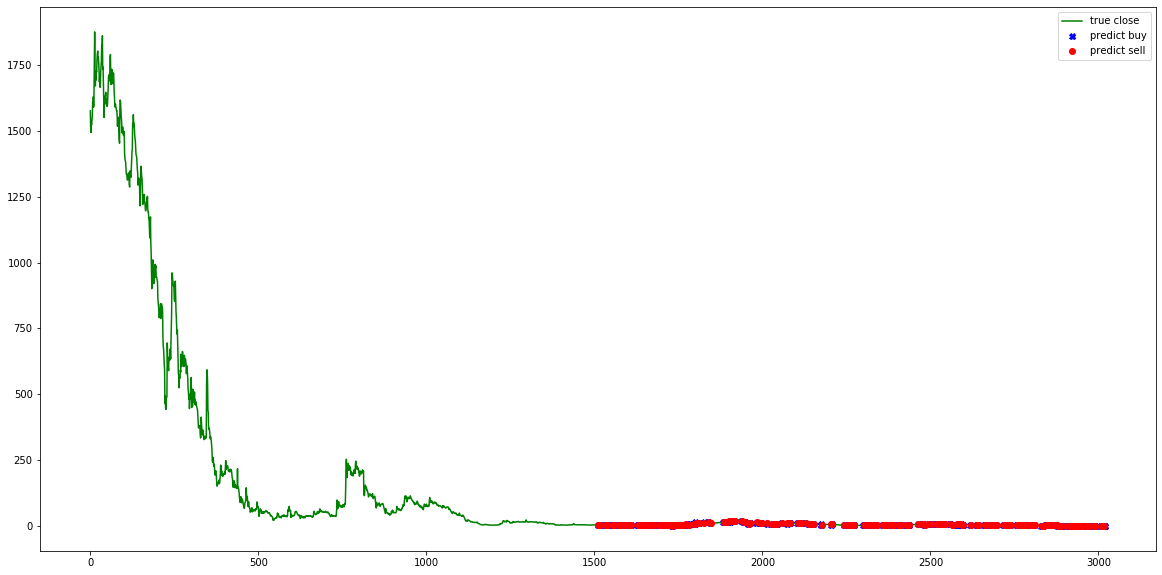

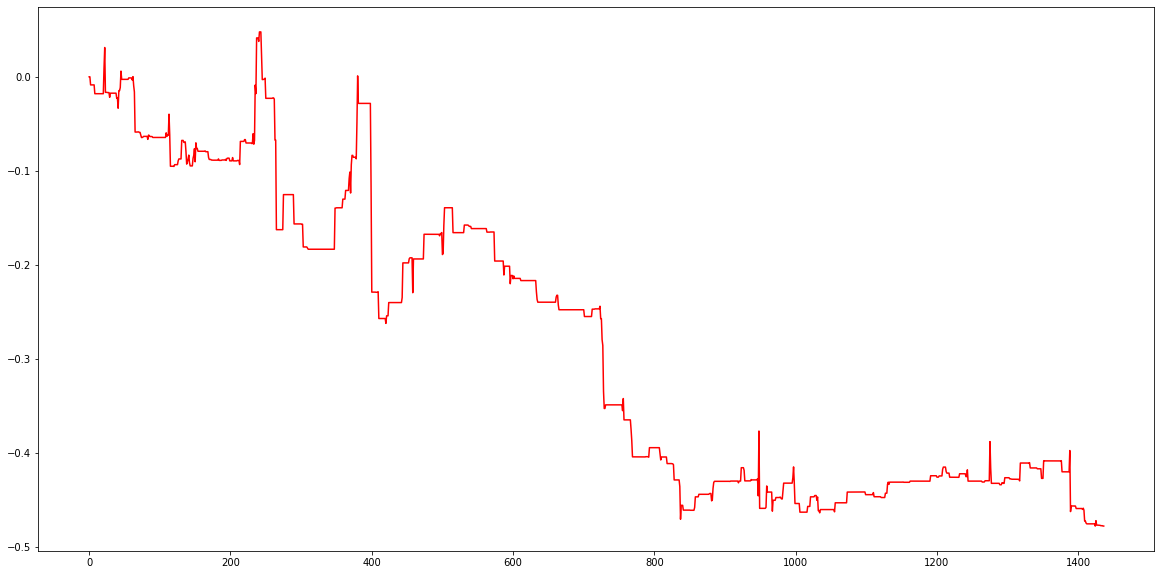

0.44720114808319156
0.44720114808319156
0.44720114808319156
0.44720114808319156
0.44720114808319156
iter 180. reward: 120.382787
day 1511: buy 38 units at price 208.048960, total balance 99791.951040
day 1512, sell 38 units at price 200.069000, total balance 99992.020040,
day 1517: buy 51 units at price 263.923680, total balance 99728.096360
day 1518, sell 51 units at price 254.743726, total balance 99982.840086,
day 1530: buy 86 units at price 464.397678, total balance 99518.442408
day 1532: buy 1 units at price 5.966970, total balance 99512.475438
day 1533, sell 87 units at price 475.017625, total balance 99987.493063,
day 1540: buy 1 units at price 6.314968, total balance 99981.178094
day 1542, sell 1 units at price 6.284969, total balance 99987.463063,
day 1552: buy 27 units at price 150.294749, total balance 99837.168314
day 1554: buy 25 units at price 142.311788, total balance 99694.856526
day 1555: buy 45 units at price 262.978685, total balance 99431.877841
day 1556: buy 30 uni

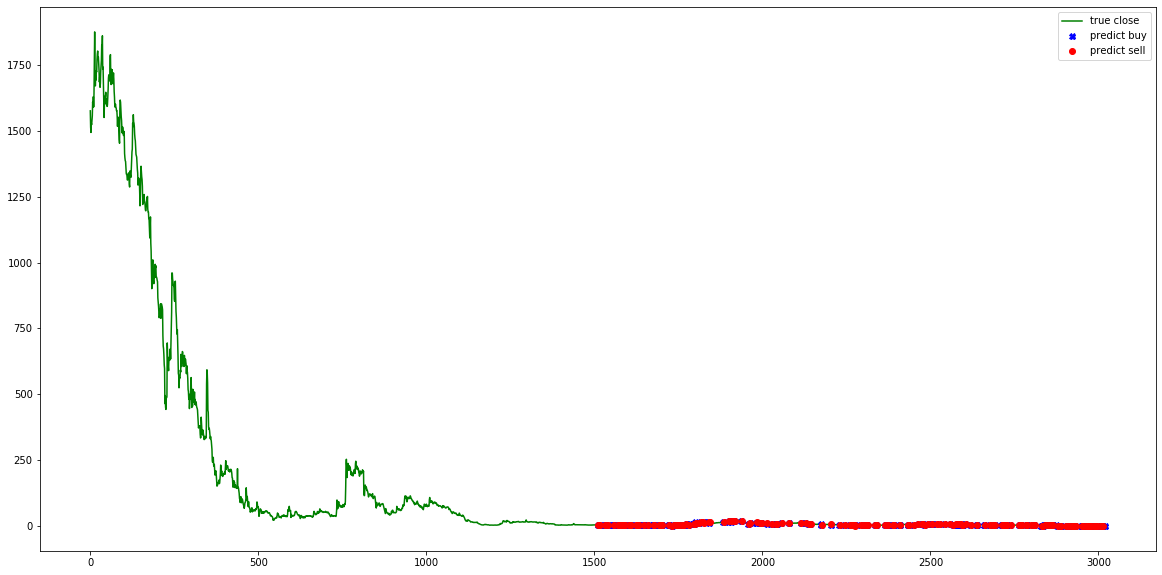

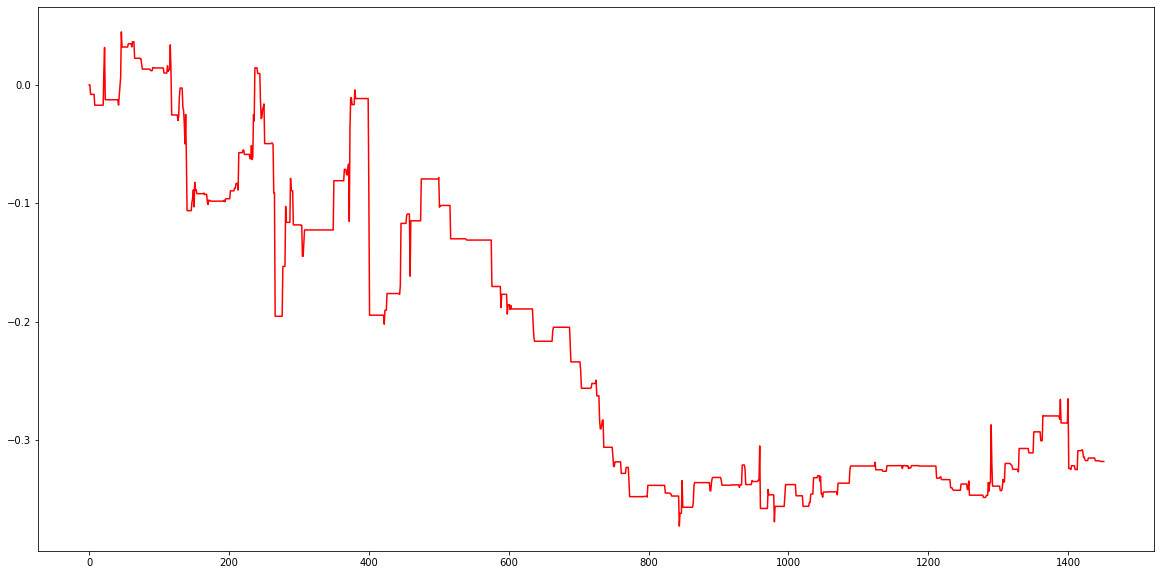

0.44720114808319156
0.44720114808319156
0.44720114808319156
0.44720114808319156
0.44720114808319156
iter 185. reward: 118.431327
day 1511: buy 42 units at price 229.948850, total balance 99770.051150
day 1513, sell 42 units at price 226.483868, total balance 99996.535017,
day 1517: buy 55 units at price 284.623577, total balance 99711.911440
day 1518, sell 55 units at price 274.723626, total balance 99986.635067,
day 1530: buy 86 units at price 464.397678, total balance 99522.237389
day 1531, sell 86 units at price 492.777536, total balance 100015.014925,
day 1532: buy 1 units at price 5.966970, total balance 100009.047955
day 1533, sell 1 units at price 5.459973, total balance 100014.507927,
day 1541: buy 52 units at price 315.898420, total balance 99698.609507
day 1542, sell 52 units at price 326.818366, total balance 100025.427873,
day 1552: buy 25 units at price 139.161804, total balance 99886.266069
day 1554: buy 23 units at price 130.926845, total balance 99755.339223
day 1555: b

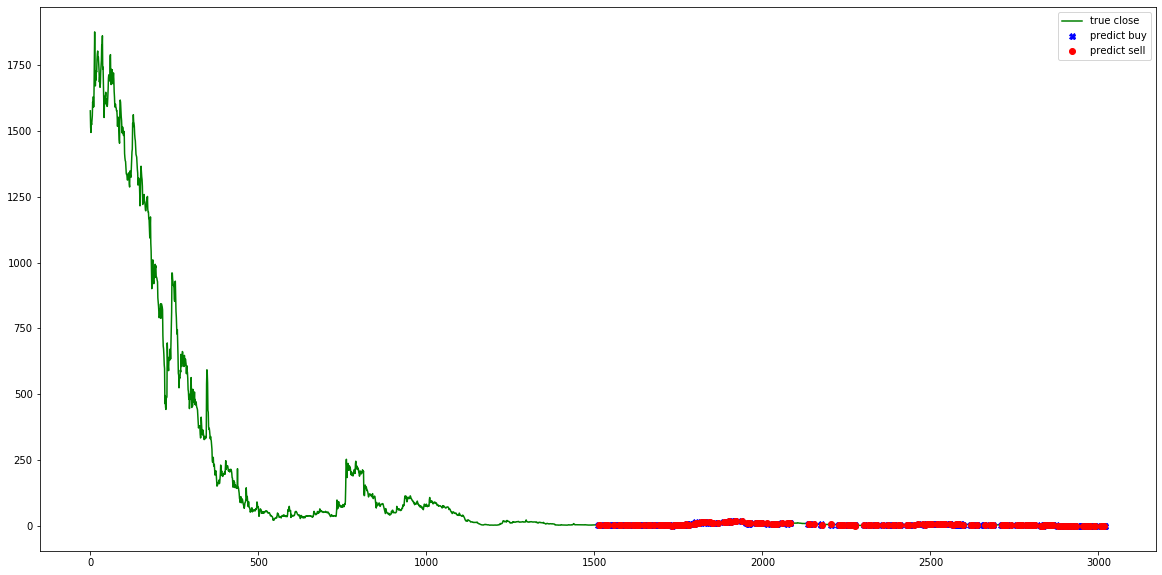

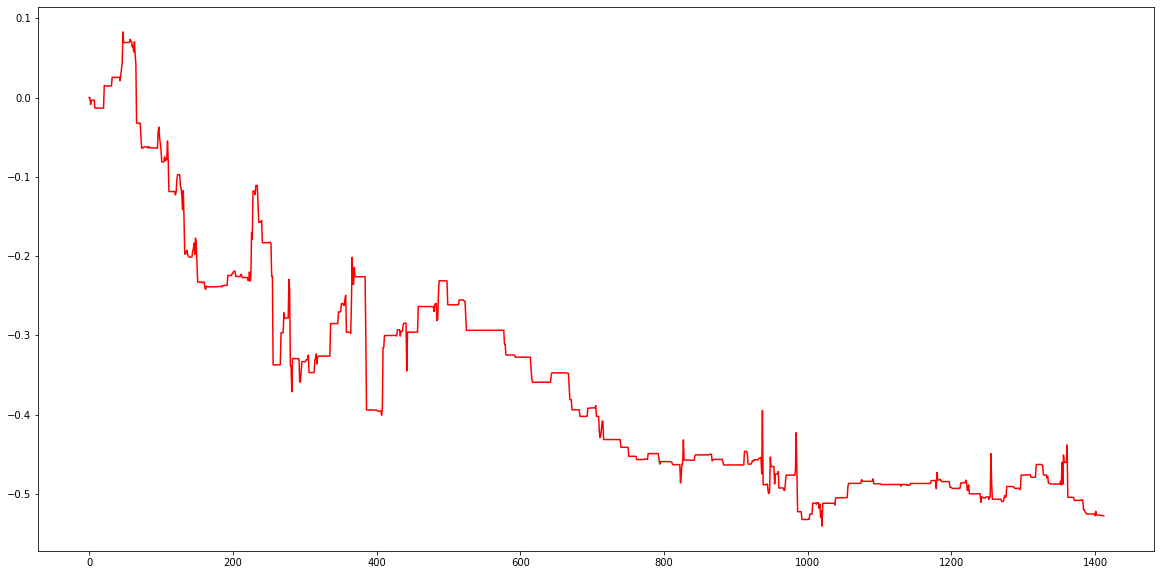

0.44720114808319156
0.44720114808319156
0.44720114808319156
0.44720114808319156
0.44720114808319156
iter 190. reward: 110.287783
day 1511: buy 38 units at price 208.048960, total balance 99791.951040
day 1513, sell 38 units at price 204.913975, total balance 99996.865016,
day 1517: buy 60 units at price 310.498447, total balance 99686.366568
day 1518, sell 60 units at price 299.698501, total balance 99986.065070,
day 1519: buy 25 units at price 123.749381, total balance 99862.315688
day 1520, sell 25 units at price 124.124379, total balance 99986.440068,
day 1530: buy 92 units at price 496.797516, total balance 99489.642552
day 1531: buy 24 units at price 137.519312, total balance 99352.123239
day 1532: buy 1 units at price 5.966970, total balance 99346.156269
day 1533, sell 117 units at price 638.816806, total balance 99984.973075,
day 1541: buy 42 units at price 255.148724, total balance 99729.824351
day 1542, sell 42 units at price 263.968680, total balance 99993.793031,
day 1550: b

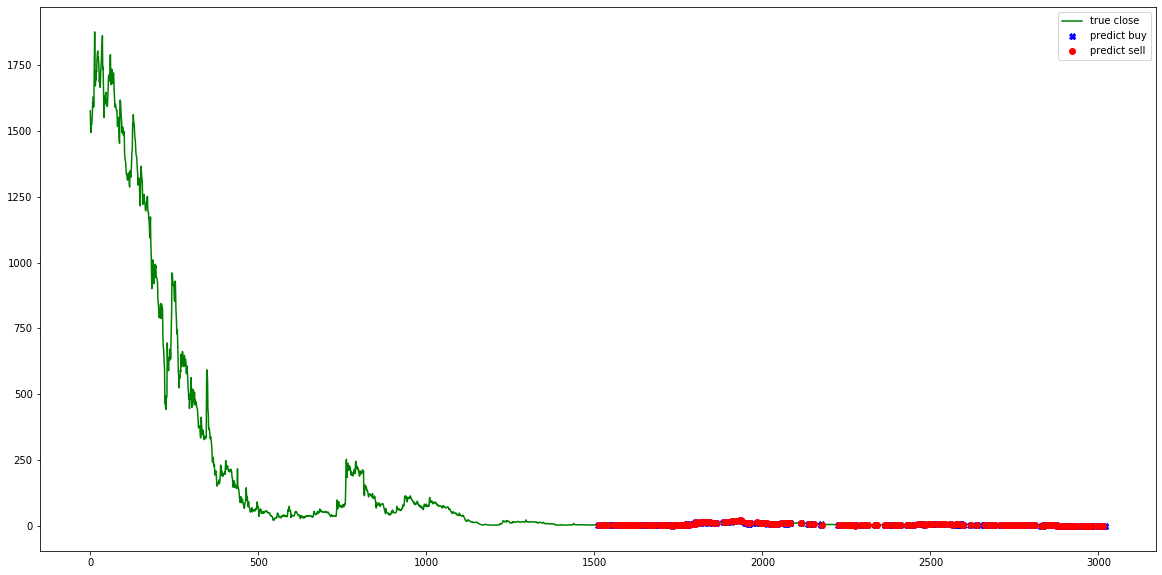

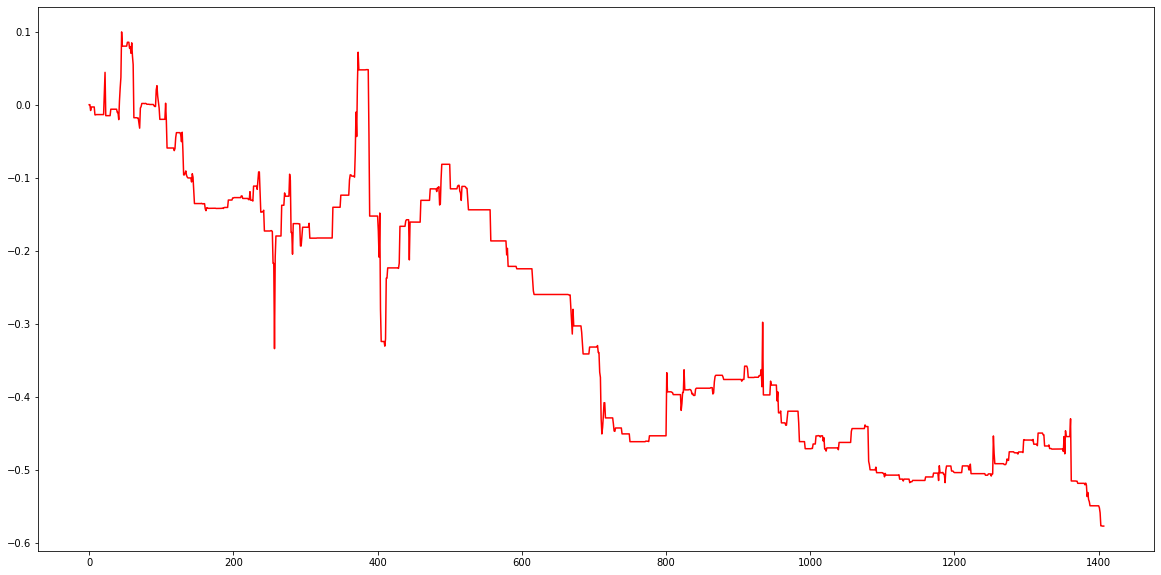

0.44720114808319156
0.44720114808319156
0.44720114808319156
0.44720114808319156
0.424841090679032
iter 195. reward: 133.690623
day 1511: buy 45 units at price 246.373768, total balance 99753.626232
day 1513, sell 45 units at price 242.661287, total balance 99996.287519,
day 1516: buy 4 units at price 20.699897, total balance 99975.587622
day 1517: buy 67 units at price 346.723266, total balance 99628.864356
day 1518, sell 71 units at price 354.643227, total balance 99983.507582,
day 1519: buy 18 units at price 89.099554, total balance 99894.408028
day 1520, sell 18 units at price 89.369553, total balance 99983.777581,
day 1528: buy 59 units at price 288.951055, total balance 99694.826526
day 1530: buy 95 units at price 512.997435, total balance 99181.829091
day 1531, sell 154 units at price 882.415588, total balance 100064.244679,
day 1532: buy 1 units at price 5.966970, total balance 100058.277709
day 1533, sell 1 units at price 5.459973, total balance 100063.737681,
day 1541: buy 52 

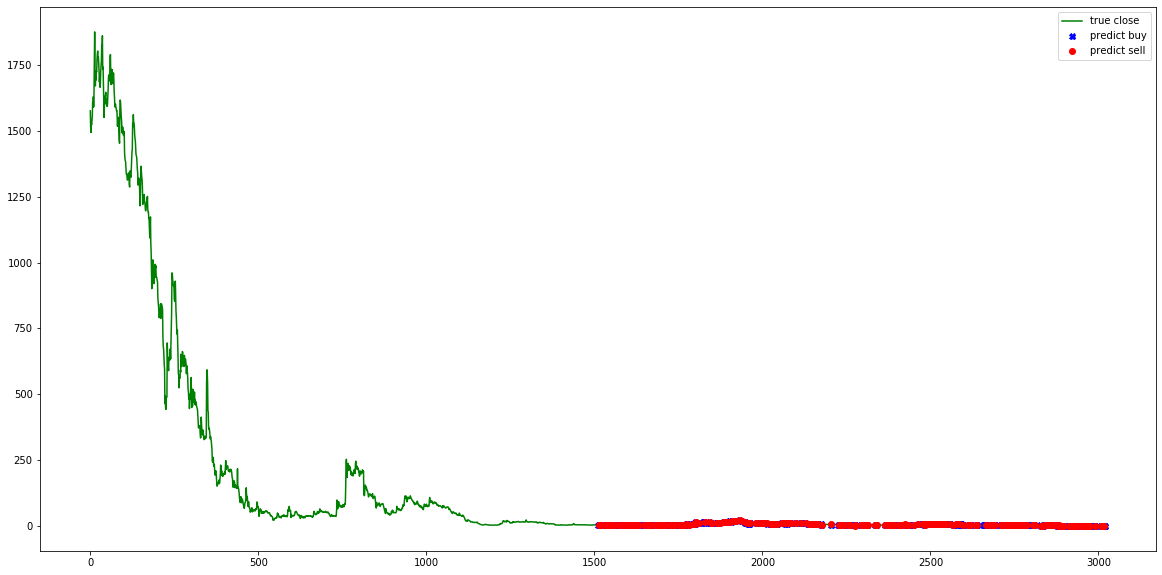

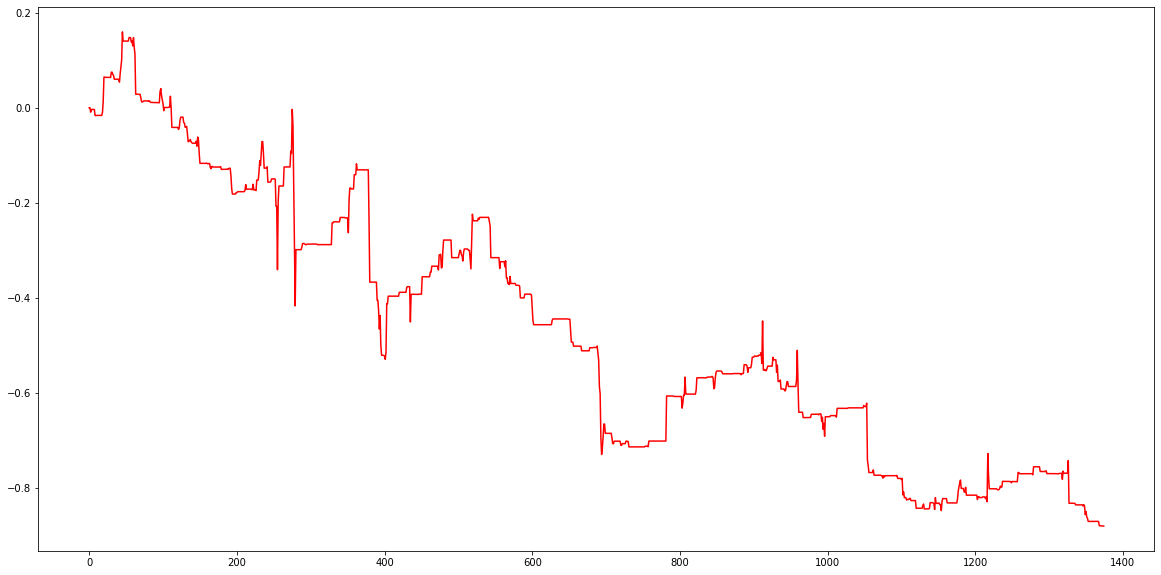

0.40359903614508036
0.40359903614508036
0.40359903614508036
0.40359903614508036
0.40359903614508036
iter 200. reward: 149.302603
day 1511: buy 33 units at price 180.674097, total balance 99819.325903
day 1512, sell 33 units at price 173.744131, total balance 99993.070035,
day 1517: buy 73 units at price 377.773111, total balance 99615.296924
day 1518, sell 73 units at price 364.633177, total balance 99979.930100,
day 1519: buy 13 units at price 64.349678, total balance 99915.580422
day 1520, sell 13 units at price 64.544677, total balance 99980.125099,
day 1522: buy 17 units at price 85.424573, total balance 99894.700526
day 1524, sell 17 units at price 84.149579, total balance 99978.850106,
day 1528: buy 44 units at price 215.488923, total balance 99763.361183
day 1530: buy 133 units at price 718.196409, total balance 99045.164774
day 1531: buy 23 units at price 131.789341, total balance 98913.375433
day 1532: buy 1 units at price 5.966970, total balance 98907.408463
day 1533, sell 20

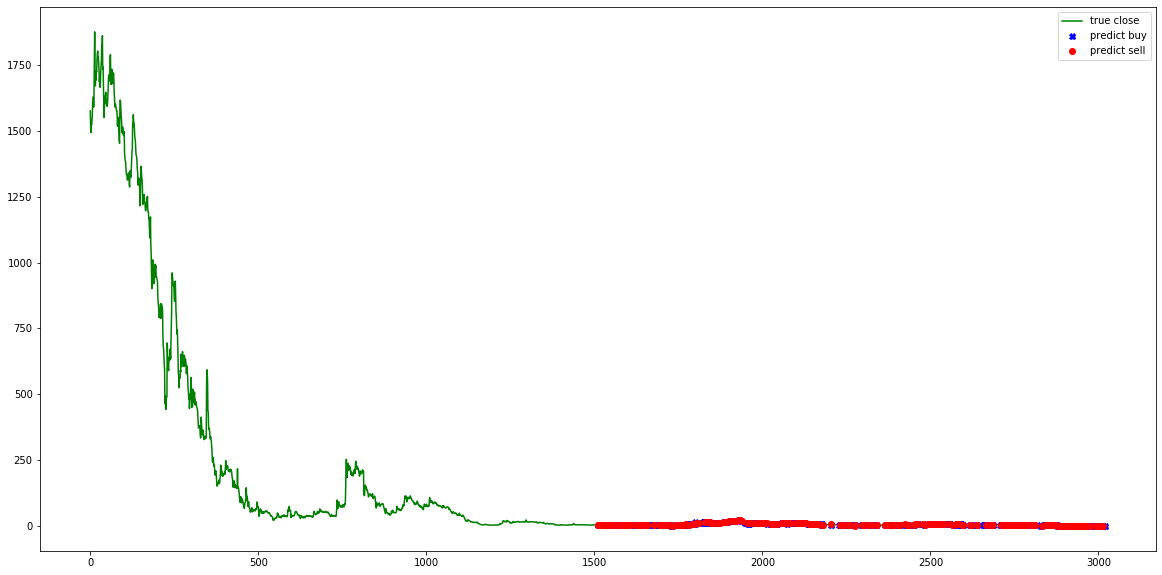

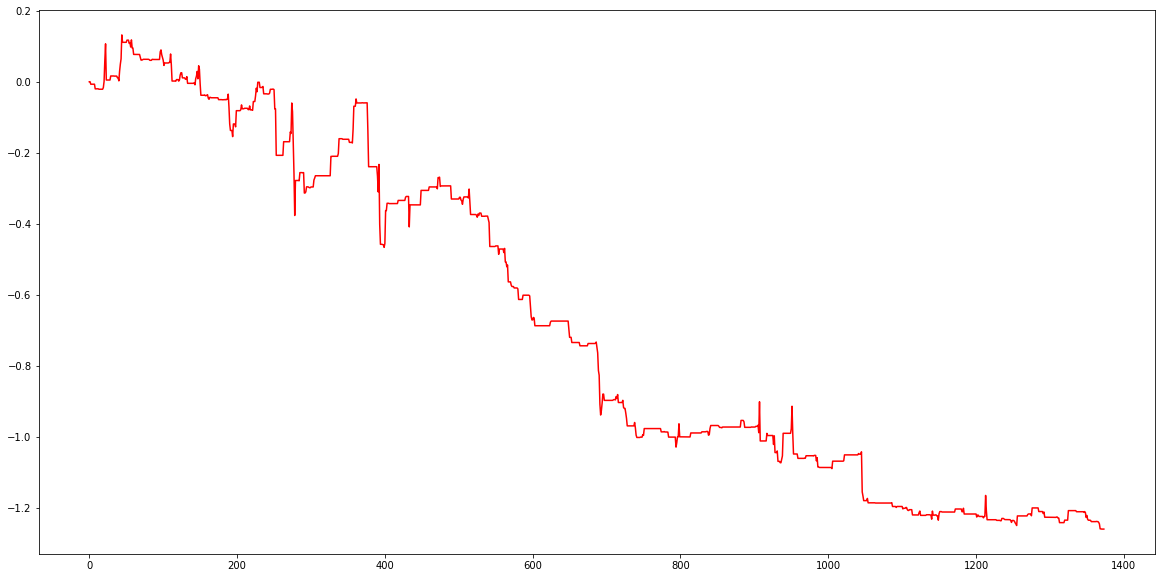

day 1511: buy 33 units at price 180.674097, total balance 99819.325903
day 1512, sell 33 units at price 173.744131, total balance 99993.070035,
day 1517: buy 73 units at price 377.773111, total balance 99615.296924
day 1518, sell 73 units at price 364.633177, total balance 99979.930100,
day 1519: buy 13 units at price 64.349678, total balance 99915.580422
day 1520, sell 13 units at price 64.544677, total balance 99980.125099,
day 1522: buy 17 units at price 85.424573, total balance 99894.700526
day 1524, sell 17 units at price 84.149579, total balance 99978.850106,
day 1528: buy 44 units at price 215.488923, total balance 99763.361183
day 1530: buy 133 units at price 718.196409, total balance 99045.164774
day 1531: buy 23 units at price 131.789341, total balance 98913.375433
day 1532: buy 1 units at price 5.966970, total balance 98907.408463
day 1533, sell 201 units at price 1097.454513, total balance 100004.862976,
day 1541: buy 54 units at price 328.048360, total balance 99676.814616

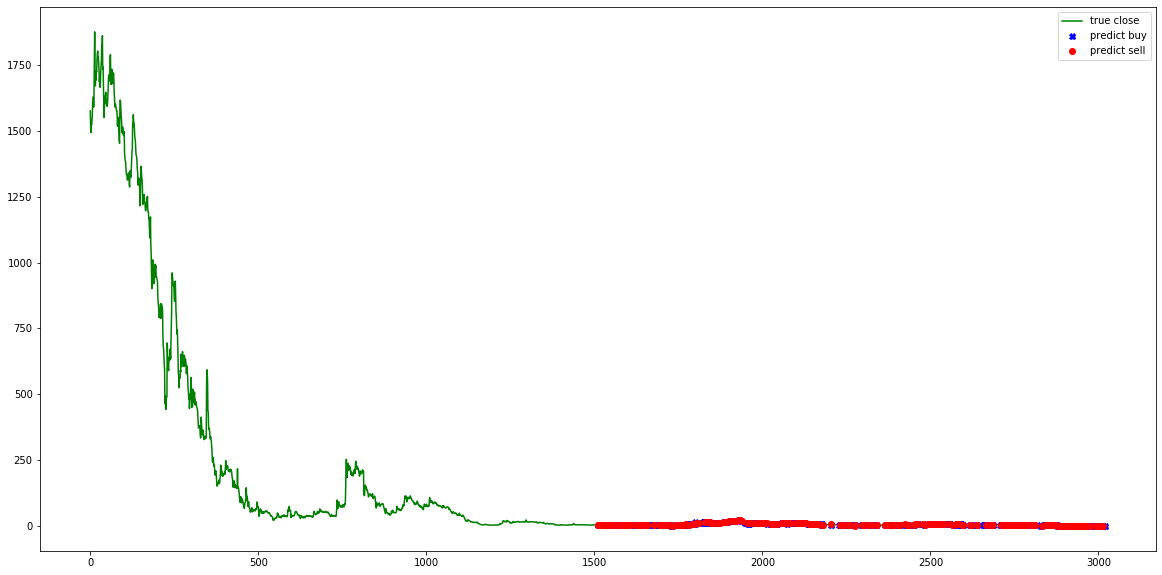

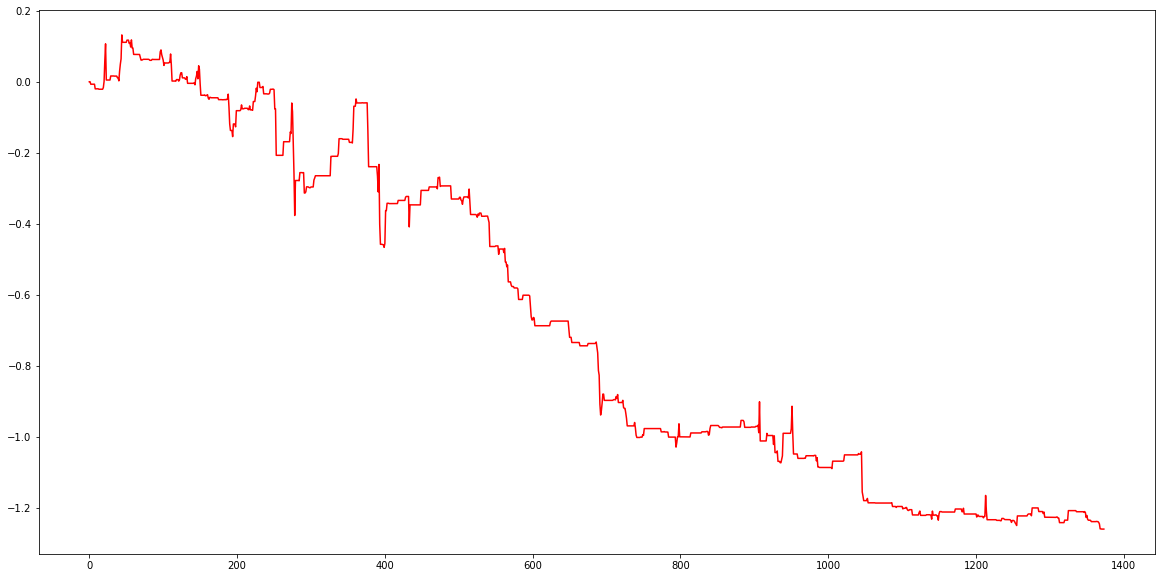

time taken to train: 844.3791255950928 seconds


In [86]:
model = Model(input_size = 30*3, 
              layer_size = 500, 
              output_size = 3)
agent = Agent(population_size = 15, 
              sigma = 0.5, 
              learning_rate = 0.02, 
              model = model, 
              money = 100000,  
              skip = 1, 
              window_size = 30)
agent.fit(200, 5)

In [50]:
model = Model(input_size = int(np.around(NN_BAYESIAN.max['params']['window_size']))*4, 
              layer_size = int(np.around(NN_BAYESIAN.max['params']['size_network'])), 
              output_size = 3)
agent = Agent(population_size = int(np.around(NN_BAYESIAN.max['params']['population_size'])), 
              sigma = NN_BAYESIAN.max['params']['sigma'], 
              learning_rate = NN_BAYESIAN.max['params']['learning_rate'], 
              model = model, 
              money = 100000, 
              skip = int(np.around(NN_BAYESIAN.max['params']['skip'])), 
              window_size = int(np.around(NN_BAYESIAN.max['params']['window_size'])))
agent.fit(500, 100)

NameError: ignored